In [454]:


## Cargar todas las librerias que me servirán a lo largo del análisis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

import re

from scipy.stats import iqr   ### para función que quita los outliers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold, ParameterGrid
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

import multiprocessing
from sklearn.svm import SVR
import xgboost


## PARA LAS TRANSFORMACIONES
from scipy.stats import shapiro
from scipy.stats import skew
from scipy import stats, special



import warnings
warnings.filterwarnings('once')


In [455]:
## para ver/cargar gráficos estáticos
%matplotlib inline

## para ver y cargar gráficos interactivos, tipo plotly
# %matplotlib notebook  

In [456]:
## como tengo columnas con mucho texto, quiero que se pueda leer
pd.set_option("display.max_colwidth", None)

## CONSIDERACIONES INICIALES:
- Durante la búsqueda y elección del tema, he encontrado varios datasets, pero los he ido viendo y descartando o por falta de información útil o por redundancia de datos. Finalmente me he quedado con éste, que tiene de partida unos 130000 aprox registros.  

- Al principio, viendo los NaNs de las varias columnas, había pensado en editarlos de varias formas, en vez de borrarlos sin más. Éstas eran:  

        1. rellenar con valor "Valor Desconocido" los NaNs relativos a region, tipo de uvas y nombre 
        del sommelier, ya que no tenía sentido rellenarlos con el valor más común de la columna en
        cuestión (= la moda), de hecho no hubiera sido algo realista en este caso y tampoco, por supuesto, 
        rellenarlos con valores numéricos, al ser de tipo object. De esta manera los hubiera tratado como otra variable más
        -  
        2. algun valor missing en la columna de precio, lo pensé rellenar con "valores predecidos", usando 
        el método KNN. Finalmente he descartado esta opción por una cuestión de optimización de los tiempos 
        (me duró el entrenamiento del modelo unas 8 horas), luego al hacer la predicción me dió unos fallos, 
        y finalmente, al no ser tampoco muy elevado el ratio de missing (apenas un 0.07), he decidio borrarlos.  

## SIGNIFICADO DE LAS COLUMNAS:
        - country : País de origen del vino
        - description: descripción hecha por el catador relativa al vino en cuestión
        - designation: viñedo de donde provienen las uvas
        - points: puntuación en una escala de 80 a 100, hecha por el catador (los datos son recopilados de la página web "Wine Enthusiast" (www.winemag.com))
        - price: precio de la botella
        - province: provincia o estado de proveniencia
        - region_1: área de proveniencia dentro de la provincia o estado
        - region_2 : área más específica de proveniencia. Este campo no siempre está relleno del todo, se podría combinar en 1 
        única columna con region_1
        - taster_name: nombre del catador (Es quien ha escrito la reseña y ha puntuado el vino. Todos los catadores son expertos 
        en materia, no usuarios "aficionados", y publican en "Wine Enthusiast")
        - taster_twitter_handle: twitter account del catador (tiene bastante missing values, probablemente prescinda de esta columna)
        - title: título de la reseña del vino, a menudo contiene el año, y lo puedo extraer en otra columna a parte para hacer más gráficas
        - variety: variedad de uvas hechas para elaborar el vino
        - winery: nombre de la bodega donde se hizo el vino  
        -  


## PRIMERA TOMA DE CONTACTO

In [457]:
## Cargo el dataset
df = pd.read_csv("..\\data\\raw\\winemag-data-130k-v2.csv", index_col=0) 

In [458]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks


In [459]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [460]:
## para hacerme una idea general de todas las variables, no solo las numericas
df.describe(include="all")

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,129908,129971,92506,129971.000000,120975.000000,129908,108724,50511,103727,98758,129971,129970,129971
unique,43,119955,37979,NaN,NaN,425,1229,17,19,15,118840,707,16757
top,US,"Seductively tart in lemon pith, cranberry and pomegranate, this refreshing, light-bodied quaff is infinitely enjoyable, both on its own or at the table. It continues to expand on the palate into an increasing array of fresh flavors, finishing in cherry and orange.",Reserve,NaN,NaN,California,Napa Valley,Central Coast,Roger Voss,@vossroger,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County),Pinot Noir,Wines & Winemakers
freq,54504,3,2009,NaN,NaN,36247,4480,11065,25514,25514,11,13272,222
mean,NaN,NaN,NaN,88.447138,35.363389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,3.039730,41.022218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,86.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,88.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,91.000000,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## DATA CLEANING y FEATURE ENGINEERING

In [461]:
## Gracias al info(), sé que hay missing values, pero quiero visualizarlos en una gráfica para entenderlos mejor
## aquí busco los missings, veo cuántos son por columnas y calculo su ratio (= los divido por la longitud del dataframe), para tener una visión más clara

df.isna().sum(axis = 0) ## veo cuántos valores nulos hay por cada columna
print("Valores nulos por columna: \n", df.isna().sum(axis = 0))
print("\nlongitud dataframe inicial: ", len(df.index))
print("\nratio de missing por columna:\n ", (df.isna().sum(axis = 0))/len(df.index))  ## esto más abajo lo enseño también con un gráfico

Valores nulos por columna: 
 country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

longitud dataframe inicial:  129971

ratio de missing por columna:
  country                  0.000485
description              0.000000
designation              0.288257
points                   0.000000
price                    0.069215
province                 0.000485
region_1                 0.163475
region_2                 0.611367
taster_name              0.201922
taster_twitter_handle    0.240154
title                    0.000000
variety                  0.000008
winery                   0.000000
dtype: float64


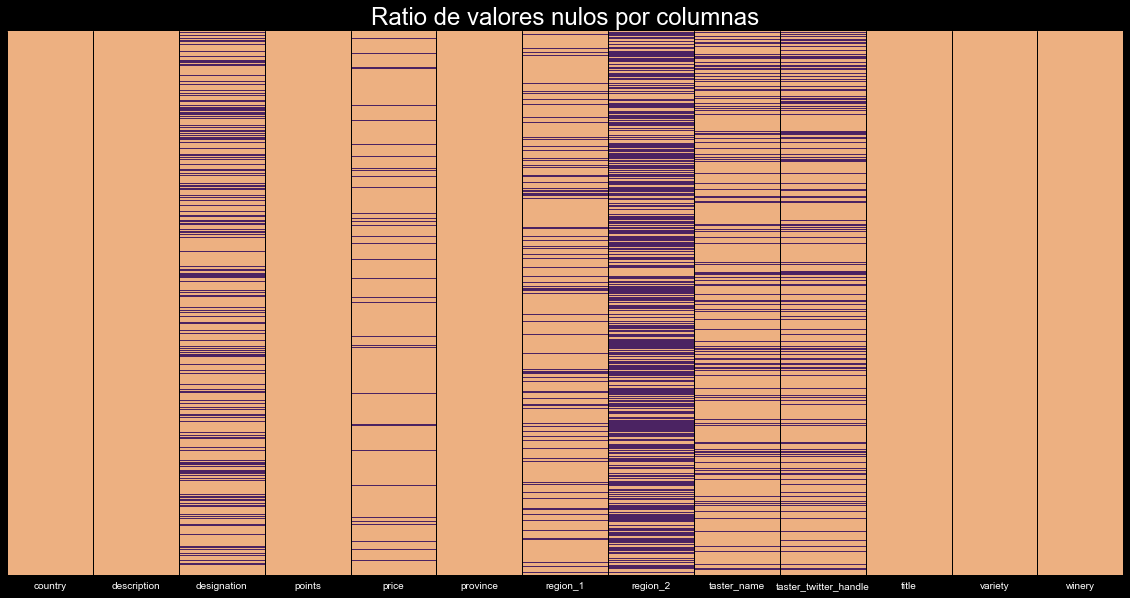

In [462]:
## quiero ver en un mapa de calor cómo se distribuye el ratio de los missings:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))

ax = sns.heatmap(df.isna(),yticklabels=False,xticklabels=df.columns,cbar=False,cmap='flare')

## para poder dibujar las líneas separadoras verticales, si no me daba fallo con el clásico "linewidth"
for i in range(df.isna().shape[1]+1):
    ax.axvline(i,color = "black", lw=1);
    
plt.title('Ratio de valores nulos por columnas', fontsize=24);
plt.show()

In [463]:
## es bastante claro, por el gráfico anterior, que la columna region_2 tiene un ratio muy alto de missing values (0.6), no merece la pena conservarla
## Además no me sirve para rellenar registros de region_1, de hecho
### aquí abajo se ve que de todas las filas de region_2 donde hay valores, TAMBIEN HAY VALORES en region_1, por lo tanto no tiene sentido mantener la columna region_2
region2_noregion1 = df.groupby("region_2")["region_1"].count()
print(pd.DataFrame(region2_noregion1))

                   region_1
region_2                   
California Other       2663
Central Coast         11065
Central Valley         1062
Columbia Valley        8103
Finger Lakes           1777
Long Island             680
Napa                   6814
Napa-Sonoma            1169
New York Other          231
North Coast             584
Oregon Other            727
Sierra Foothills       1462
Sonoma                 9028
South Coast             272
Southern Oregon         917
Washington Other        534
Willamette Valley      3423


In [464]:
## "taster_twitter_handle" tiene un ratio bastante grande de NaNs (0.24) y aquí abajo vemos que no me aporta ninguna
## info más para rellenar NaNs del "tester_name", por lo tanto es otra de las columnas que borraré (más abajo)
name_vs_twitter = df.groupby("taster_twitter_handle")["taster_name"].count()
print(pd.DataFrame(name_vs_twitter))

                       taster_name
taster_twitter_handle             
@AnneInVino                   3685
@JoeCz                        5147
@bkfiona                        27
@gordone_cellars              4177
@kerinokeefe                 10776
@laurbuzz                     1835
@mattkettmann                 6332
@paulgwine                    9532
@suskostrzewa                 1085
@vboone                       9537
@vossroger                   25514
@wawinereport                 4966
@wineschach                  15134
@winewchristina                  6
@worldwineguys                1005


In [465]:
### hay más columnas con NaNs, pero el ratio de missing es tan bajo comparado con los 130000 registros del dataset, que no merece la pena rellenarlas así que LES HARÉ UN DROPNA
## son las siguientes:
# country: 63 nulos, ratio de missing 0.000485
# designation: 37465 nulos, ratio de missing 0.288257 
# price: 8996 nulos, ratio de missing 0.069215
# province: 63 nulos, ratio de missing 0.000485
# region_1: 21247 nulos, ratio de missing 0.163475 
# taster_name : 26244 nulos, ratio de missing 0.201922 
# variety: 1 nulo, ratio de missing  0.000008
df = df.dropna(subset=["country","designation", "price" , "province", "region_1", "taster_name", "variety"])


In [466]:

## ahora borro las columnas que no me aportan ninguna utilidad y encima tienen missing values ("region_2" y "taster_twitter_handle")
df = df.drop(["region_2", "taster_twitter_handle"], axis = 1)

In [467]:
## volvemos a ver el df, y como se ha quedado el ratio de missing values

In [468]:
df.head()

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks
5,Spain,"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (Navarra),Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with aromas of candied berry, white pepper and savory herb that carry over to the palate. It's balanced with fresh acidity and soft tannins.",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,France,This has great depth of flavor with its fresh apple and pear fruits and touch of spice. It's off dry while balanced with acidity and a crisp texture. Drink now.,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris (Alsace),Pinot Gris,Jean-Baptiste Adam


In [469]:
print("#### Chequeo NaNs después de la primera limpieza ####")
print("Valores nulos por columna después de la primera limpieza de NaNs: \n", df.isna().sum(axis = 0))
print("\nratio de missing por columna:\n ", (df.isna().sum(axis = 0))/len(df.index))

#### Chequeo NaNs después de la primera limpieza ####
Valores nulos por columna después de la primera limpieza de NaNs: 
 country        0
description    0
designation    0
points         0
price          0
province       0
region_1       0
taster_name    0
title          0
variety        0
winery         0
dtype: int64

ratio de missing por columna:
  country        0.0
description    0.0
designation    0.0
points         0.0
price          0.0
province       0.0
region_1       0.0
taster_name    0.0
title          0.0
variety        0.0
winery         0.0
dtype: float64


In [17]:
## puedo confirmar que ya no tengo missing values(de momento) (a pesar de seguir teniendo muchísimos registros, he hecho un recorte bastante importante)

In [18]:
## veo que la columna "title" tiene en su interior el año de producción del vino (aunque no en todas las filas)
## voy a quedarme solo con ese valor, que meteré en una columna que llamaré "year" y voy a borrar la columna "title"
## El resto de info de esa columna no me importa perderlo, ya que lo encuentro repetido en otras columnas del dataframe
## puede que salgan más missing values relativos al año, ya que no todos los registros de esta columna contienen la información del año

year = []    
for value in df['title']:
    regexresult = re.search(r'19\d{2}|20\d{2}', value)   ## para quedarme solo con el año (valor numérico de 4 dígitos que empieza por 19 o por 20)
    if regexresult:
        year.append(regexresult.group())
    else: year.append(None)

df['year'] = year


print("Hay {} registros con el año y {} sin él. Estos últimos tendré que borrarlos del dataframe, en cuanto missing values".format(len(df[df['year'].notna()]), len(df[df['year'].isna()].index)))
df['year'].describe()


Hay 51550 registros con el año y 2620 sin él. Estos últimos tendré que borrarlos del dataframe, en cuanto missing values


count     51550
unique       39
top        2013
freq       8798
Name: year, dtype: object

In [19]:
## ya puedo borrar la columna "title"
df = df.drop(["title"], axis = 1)

In [20]:
## por lo que ví hace 2 celdas, sé que tengo 2620 missing values en la columna "year", así que haré un dropna
df = df.dropna(subset=["year"])

In [21]:
df.info()  ## con este info veo que ya no tengo ningun missing value, tengo pendiente buscar, si las hubiera, filas duplicadas (y si las encuentro, hacer un drop_duplicate)
            ## y también veo que tengo que pasar la columna "year" a número, actualmente está como "object"

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51550 entries, 3 to 129970
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      51550 non-null  object 
 1   description  51550 non-null  object 
 2   designation  51550 non-null  object 
 3   points       51550 non-null  int64  
 4   price        51550 non-null  float64
 5   province     51550 non-null  object 
 6   region_1     51550 non-null  object 
 7   taster_name  51550 non-null  object 
 8   variety      51550 non-null  object 
 9   winery       51550 non-null  object 
 10  year         51550 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.7+ MB


In [22]:
df["year"] = df["year"].astype(int)

In [23]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51550 entries, 3 to 129970
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      51550 non-null  object 
 1   description  51550 non-null  object 
 2   designation  51550 non-null  object 
 3   points       51550 non-null  int64  
 4   price        51550 non-null  float64
 5   province     51550 non-null  object 
 6   region_1     51550 non-null  object 
 7   taster_name  51550 non-null  object 
 8   variety      51550 non-null  object 
 9   winery       51550 non-null  object 
 10  year         51550 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(8)
memory usage: 4.5+ MB


In [24]:
## ahora busco a ver si hubiera filas duplicadas

filas_duplicadas = df[df.duplicated()]
print("Estas son las filas duplicadas: \n", filas_duplicadas.head())

Estas son las filas duplicadas: 
      country  \
2413  France   
3431  France   
3432      US   
3433      US   
4094      US   

                                                                                                                                                                                                                                                  description  \
2413                                                                           Fruity and lightly herbaceous, this has fine textured acidity along with a pink grapefruit flavor. The wine is bright and easy, and it will be ready to drink in a few months.   
3431                                             The wine is still young with its crisp red fruits and tense tannins. It is a structured wine, firm with a dry core and still developing its fruitiness. It will need to age a while yet, so drink from 2018.   
3432                                                                            The aromas are lig

In [25]:
## tengo que borrar los duplicados
df.drop_duplicates(keep= "first", inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47143 entries, 3 to 129970
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      47143 non-null  object 
 1   description  47143 non-null  object 
 2   designation  47143 non-null  object 
 3   points       47143 non-null  int64  
 4   price        47143 non-null  float64
 5   province     47143 non-null  object 
 6   region_1     47143 non-null  object 
 7   taster_name  47143 non-null  object 
 8   variety      47143 non-null  object 
 9   winery       47143 non-null  object 
 10  year         47143 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(8)
memory usage: 4.1+ MB


In [27]:
df.head()

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year
3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks,2012
5,Spain,"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tempranillo-Merlot,Tandem,2011
6,Italy,"Here's a bright, informal red that opens with aromas of candied berry, white pepper and savory herb that carry over to the palate. It's balanced with fresh acidity and soft tannins.",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Frappato,Terre di Giurfo,2013
9,France,This has great depth of flavor with its fresh apple and pear fruits and touch of spice. It's off dry while balanced with acidity and a crisp texture. Drink now.,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Pinot Gris,Jean-Baptiste Adam,2012


In [28]:
## veo como se han quedado los datos después de una limpieza bastante exhaustiva
df.describe(include="all")

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year
count,47143,47143,47143,47143.000000,47143.00000,47143,47143,47143,47143,47143,47143.000000
unique,7,47134,22726,NaN,NaN,59,987,17,428,8290,NaN
top,US,"Subtle aromas of dark berry, tilled earth and baking spice lead the nose. The ripe, juicy palate doles out mature plum, cassis, anise and black pepper alongside round, solid tannins. Drink through 2018.",Reserve,NaN,NaN,California,Columbia Valley (WA),Roger Voss,Pinot Noir,Columbia Crest,NaN
freq,23240,2,1062,NaN,NaN,12492,2240,7433,6076,144,NaN
mean,NaN,NaN,NaN,89.023227,39.61445,NaN,NaN,NaN,NaN,NaN,2011.477186
std,NaN,NaN,NaN,3.013516,36.94440,NaN,NaN,NaN,NaN,NaN,3.346852
min,NaN,NaN,NaN,80.000000,4.00000,NaN,NaN,NaN,NaN,NaN,1904.000000
25%,NaN,NaN,NaN,87.000000,20.00000,NaN,NaN,NaN,NaN,NaN,2010.000000
50%,NaN,NaN,NaN,89.000000,30.00000,NaN,NaN,NaN,NaN,NaN,2012.000000
75%,NaN,NaN,NaN,91.000000,49.00000,NaN,NaN,NaN,NaN,NaN,2014.000000


In [29]:
## vuelvo a comprobar si se hubiese quedado alguna fila duplicada, pero veo que no
## ya no tengo ni missing values, ni filas duplicadas, ni números con formato "object"
## puedo pasar a hacer los varios análisis y ver si hay correlaciones de algun tipo

filas_duplicadas = df[df.duplicated()]
print("Estas son las filas duplicadas: \n", filas_duplicadas)

Estas son las filas duplicadas: 
 Empty DataFrame
Columns: [country, description, designation, points, price, province, region_1, taster_name, variety, winery, year]
Index: []


In [30]:
## ULTIMA CONSIDERACIÓN ANTES DE PASAR CON EL ANÁLISIS: si bien estoy viendo que va a haber varios outlier en los precios, me está llamando mucho la atención él de 2013$
## así que lo aislo aquí para ver qué parametros más tiene y efectivamente descubro que justamente el año del vino es 2013, aquí está clarísimo que se trata de un error del dato, por lo tanto lo elimino del dataframe
err_out = df[df["price"] == 2013]
err_out

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year
120391,US,"The nose on this single-vineyard wine from a strong, often overlooked appellation is tight and minerally before showing a slightly tropical kiwi element. Brightly acidic on the lively palate, flavors range from Key lime and Meyer lemon to pear skins and apple flesh.",Roger Rose Vineyard,91,2013.0,California,Arroyo Seco,Matt Kettmann,Chardonnay,Blair,2013


In [31]:
## borro la línea relativa a ese precio de 2013$
df = df.drop(df[df["price"]== 2013].index)


In [32]:
df.describe()  ## veo que ya el precio máximo es 850$, que sigue siendo un precio altísimo, pero aún así,verosímil

,points,price,year
count,47142.000000,47142.000000,47142.000000
mean,89.023185,39.572589,2011.477154
std,3.013534,35.809319,3.346880
min,80.000000,4.000000,1904.000000
25%,87.000000,20.000000,2010.000000
50%,89.000000,30.000000,2012.000000
75%,91.000000,49.000000,2014.000000
max,100.000000,850.000000,2017.000000


In [33]:
## guardo este dataframe limpo como csv
df.to_csv("..\\data\\processed\\vinos_editado.csv", index=False)  ## todos los csv que cree los guardo en la carpeta "processed"

## ANÁLISIS VARIOS

### APUNTES MIOS PARA TENER CONTROLADOS LOS ANÁLISIS QUE VAYA HACIENDO

- 1  **PRECIOS / PUNTUACIÓN / AÑO**
    - ver la distribución de los precios por si solos
    - ver una distribución de los precios respecto a los countries
    - ver distribución de precios con respecto a la puntuación -->hay correlación de algun tipo? Yo creo que si pero a lo mejor me llevo alguna sorpresa
    - ver si hay correlación entre precios y años o precios/puntuación y años (puede que no, pero hay que intentarlo)
    - ver la distribución de los años (gráfico de barras) --> cuál es el año con más producción? el año con menos? hay algun outlier?
    - Más gráficos:
        - media de precios por País: (groupby(country)[price].mean()) --> puedo ver, ordenándolos, cuál es el País que produce el vino más caro
        - media de puntuación por País: (groupby(country)[points].mean()) --> puedo ver, ordenándolos, cuál es el País que produce el vino más puntuado
        - media de puntuación por bodega (winery): (groupby(winery)[points].mean()) --> puedo ver, ordenándolos, cuál es la bodega que produce el vino más puntuado
        - media de precios por variedad de uva: (groupby(variety)[price].mean()) --> puedo ver, ordenándolos, cuál es la variedad de uva más cara  
        - tambien puntuación por catador (groupby(taster_name)[points].mean())

- 2 **VARIEDADES DE UVAS**
    - ver qué tipos de uvas hay y con qué frecuencia aparecen. Puedo hacer un gráfico por sí solo con las uvas (de barras)
    - otro gráfico juntándo las variedades de uvas con los estados, ver si una variedad es típica de sólo un estado o si comparten variedades ?????
        - grafico: cuál es el País que tiene más variedades de uva -->  (groupby(country)[variety].mean())  -->> no sé si usar mean u otra medicion
        - 

- 3 **OUTLIERS**
    - seguramente encuentre ( o no) outliers en el precio y en la puntuación, tengo que ver si (para mi futuro modelo de ML) es mejor que los borre o no
    - hacer diagramas de caja y bigote para detectar todos los outliers y ver qué hacer con ellos
    - 
    
- 4 **PAÍS / MAPAS / DISTRIBUCCIÓN DEL VINO**
    - *puedo usar la columna country para sacar un mapa visual de distribución de los vinos en el mundo 
    - me podran servir las columnas de province/region_1 para hacer un análisis de distribución de los vinos???


### 1  **TODOS LOS ANÁLISIS A PARTIR DEL DATAFRAME LIMPIADO Y EDITADO:** df_limpio

#### 0 **CARGO df_limpio Y DEFINO ESTILO GRÁFICOS**

In [34]:
df_limpio = pd.read_csv("..\data\\processed\\vinos_editado.csv")
df_limpio

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year
0,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian,2013
1,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks,2012
2,Spain,"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tempranillo-Merlot,Tandem,2011
3,Italy,"Here's a bright, informal red that opens with aromas of candied berry, white pepper and savory herb that carry over to the palate. It's balanced with fresh acidity and soft tannins.",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Frappato,Terre di Giurfo,2013
4,France,This has great depth of flavor with its fresh apple and pear fruits and touch of spice. It's off dry while balanced with acidity and a crisp texture. Drink now.,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Pinot Gris,Jean-Baptiste Adam,2012
...,...,...,...,...,...,...,...,...,...,...,...
47137,France,"The granite soil of the Brand Grand Cru vineyard has produced a strongly structured wine that also has richness and ripe fruits. Off dry, it has a hint of honey as well as yellow fruits and pears. The aftertaste brings out the acidity and freshness that balance the wine. Drink from 2017.",Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Pinot Gris,Cave de Turckheim,2010
47138,Italy,"Blackberry, cassis, grilled herb and toasted aromas come together in the glass. On the palate, espresso, mint and black pepper add depth to the core of black cherry and blackberry flavors. It finishes on a licorice note.",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Nero d'Avola,Cusumano,2012
47139,France,"While it's rich, this beautiful dry wine also offers considerable freshness. Acidity cuts easily through the ripe white fruit, pear and red apples, allowing room for spice that provides a contrasting aftertaste.",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Pinot Gris,Domaine Rieflé-Landmann,2013
47140,France,"Well-drained gravel soil gives this wine its crisp and dry character. It is ripe and fruity, although the spice is subdued in favor of a more serious structure. This is a wine to age for a couple of years, so drink from 2017.",Kritt,90,30.0,Alsace,Alsace,Roger Voss,Gewürztraminer,Domaine Gresser,2013


In [392]:
## defino el estilo de fondo de las gráficas
sns.set_style('darkgrid')

#### 1 **ANALISIS UNIVARIANTE DE CADA COLUMNA**

In [36]:
df_no_descr = df_limpio.drop("description", axis = 1)
df_no_descr

,country,designation,points,price,province,region_1,taster_name,variety,winery,year
0,US,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian,2013
1,US,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks,2012
2,Spain,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tempranillo-Merlot,Tandem,2011
3,Italy,Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Frappato,Terre di Giurfo,2013
4,France,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Pinot Gris,Jean-Baptiste Adam,2012
...,...,...,...,...,...,...,...,...,...,...
47137,France,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Pinot Gris,Cave de Turckheim,2010
47138,Italy,Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Nero d'Avola,Cusumano,2012
47139,France,Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Pinot Gris,Domaine Rieflé-Landmann,2013
47140,France,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Gewürztraminer,Domaine Gresser,2013


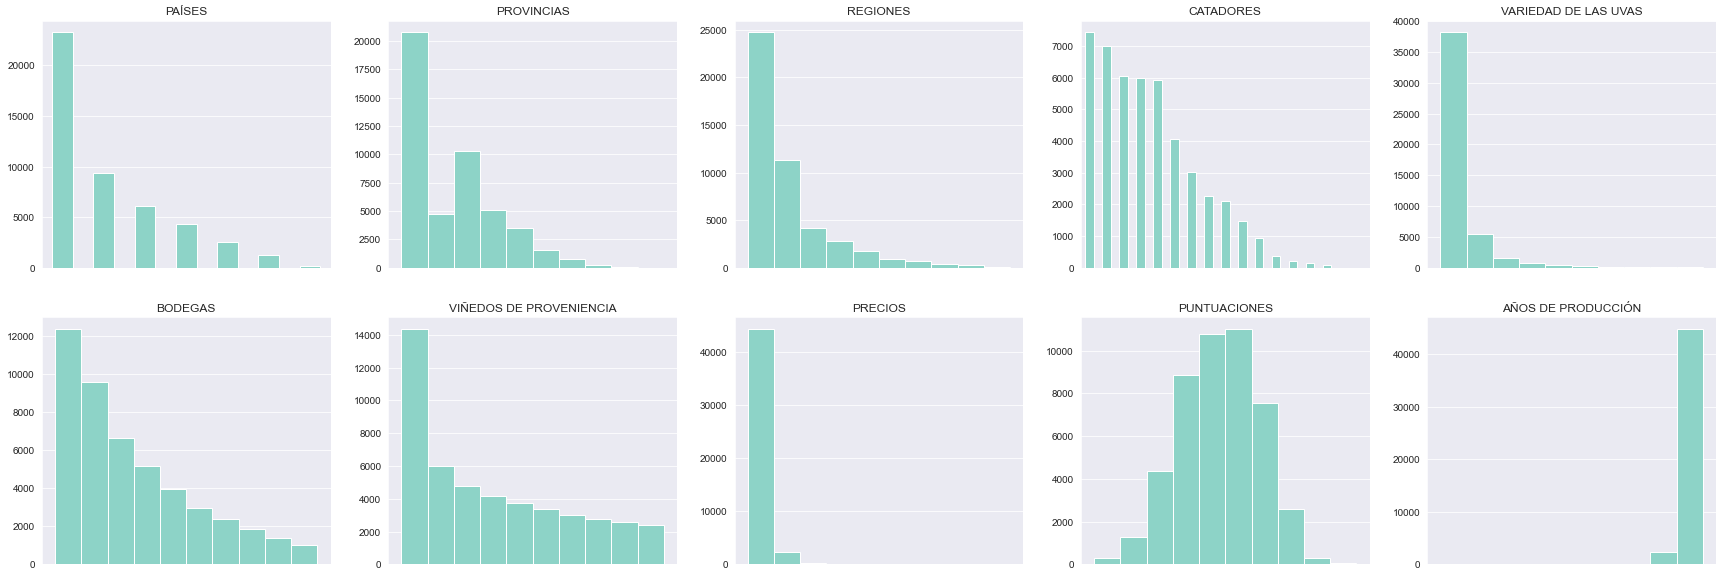

In [37]:
## pinto unos gráficos para cada columna, para hacerme una idea general de las distribuciones
## por supuesto la columna "description" no entra en este análisis
fig = plt.figure(figsize=(30,10))
#2 rows 5 columns

ax1 = plt.subplot2grid((2,5),(0,0))
df_limpio["country"].value_counts().plot(kind="bar")
plt.xticks([])
plt.title("PAÍSES")

ax2 = plt.subplot2grid((2,5),(0,1))
df_limpio["province"].hist()
plt.xticks([])
plt.title("PROVINCIAS")

ax3 = plt.subplot2grid((2,5),(0,2))
df_limpio["region_1"].hist()
plt.xticks([])
plt.title("REGIONES")

ax4 = plt.subplot2grid((2,5),(0,3))
df_limpio["taster_name"].value_counts().plot(kind="bar")
plt.xticks([])
plt.title("CATADORES")

ax5 = plt.subplot2grid((2,5),(0,4))
df_limpio["variety"].hist()
plt.xticks([])
plt.title("VARIEDAD DE LAS UVAS");

ax6 = plt.subplot2grid((2,5),(1,0))
df_limpio["winery"].hist()
plt.xticks([])
plt.title("BODEGAS")

ax7 = plt.subplot2grid((2,5),(1,1))
df_limpio["designation"].hist()
plt.xticks([])
plt.title("VIÑEDOS DE PROVENIENCIA")

ax8 = plt.subplot2grid((2,5),(1,2))
df_limpio["price"].hist()
plt.xticks([])
plt.title("PRECIOS")

ax9 = plt.subplot2grid((2,5),(1,3))
df_limpio["points"].hist()
plt.xticks([])
plt.title("PUNTUACIONES")

ax10 = plt.subplot2grid((2,5),(1,4))
df_limpio["year"].hist()
plt.xticks([])
plt.title("AÑOS DE PRODUCCIÓN");

#### 2  **PRECIOS Y PUNTOS, VARIOS ANÁLISIS Y RELACIONES CON LAS DEMÁS COLUMNAS**

In [38]:
## empiezo mirando la puntuación: son valores que van del 80 al 100
points = df['points'].value_counts()   ## cuento todas las valoraciones
points = points.sort_index()  ## aquí las ordeno de la más baja (80) a la más alta (100)
points  ## defino el nombre de la variable para que el gráfico abajo sea más limpio

80      122
81      174
82      449
83      847
84     1656
85     2716
86     3658
87     5196
88     6021
89     4785
90     5932
91     5086
92     4345
93     3202
94     1878
95      721
96      228
97       77
98       32
99       11
100       6
Name: points, dtype: int64

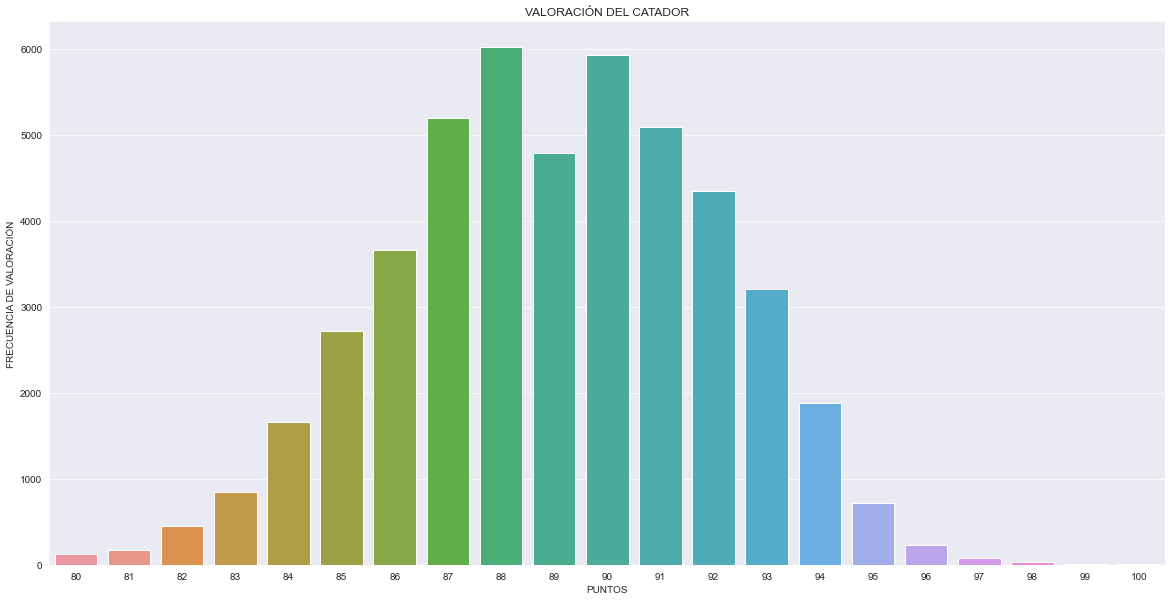

In [39]:
## saco el gráfico

plt.figure(figsize=(20,10))
sns.barplot(x=points.index, y=points)
plt.xlabel("PUNTOS")
plt.ylabel("FRECUENCIA DE VALORACIÓN")
plt.title('VALORACIÓN DEL CATADOR');

In [40]:
## NOTAS SOBRE EL GRÁFICO: 
# 1- La mayoría de las puntuaciones se concentran en la mitad, (de las aprox 6000 valoraciones, más de 3000 han sido con valores de entre el 86 y el 93)
# 2- Entre valoraciones más bajas (80-85) y más altas (94-100), ganan las más bajas, teniendo 122 valoraciones de "80" y solo 6 de "100"
# 3- La puntuación más usada ha sido el "88" (6021 valoraciones), seguido por el "90" (5932)
# 4- Hay que especificar que en general son valoraciones buenas, siendo el valor mínimo un 80 sobre 100. Valoraciones de usuarios de "Wine Enthusiasm" (expertos, no aficionados)

In [41]:
## Análisis bivariante para ver la relación entre la puntuación y el precio, considerando para cada valor de puntuación, el vino de menor precio, él de mayor, 
# y la media de precios
## por ejemplo aquí veo que los vinos valorados con un "86" tenian un precio medio de casi 24 dólares, siendo de 6$ el más barato y 160$ el más caro
precios_vs_puntos = df_limpio.groupby("points")["price"].agg(["min", "max", "mean"])
precios_vs_puntos   


,min,max,mean
points,,,
80,5.0,40.0,15.622951
81,5.0,130.0,18.252874
82,4.0,80.0,19.688196
83,5.0,225.0,19.749705
84,4.0,200.0,20.103865
85,4.0,200.0,21.691826
86,6.0,160.0,23.862767
87,6.0,800.0,26.923018
88,6.0,325.0,30.648065


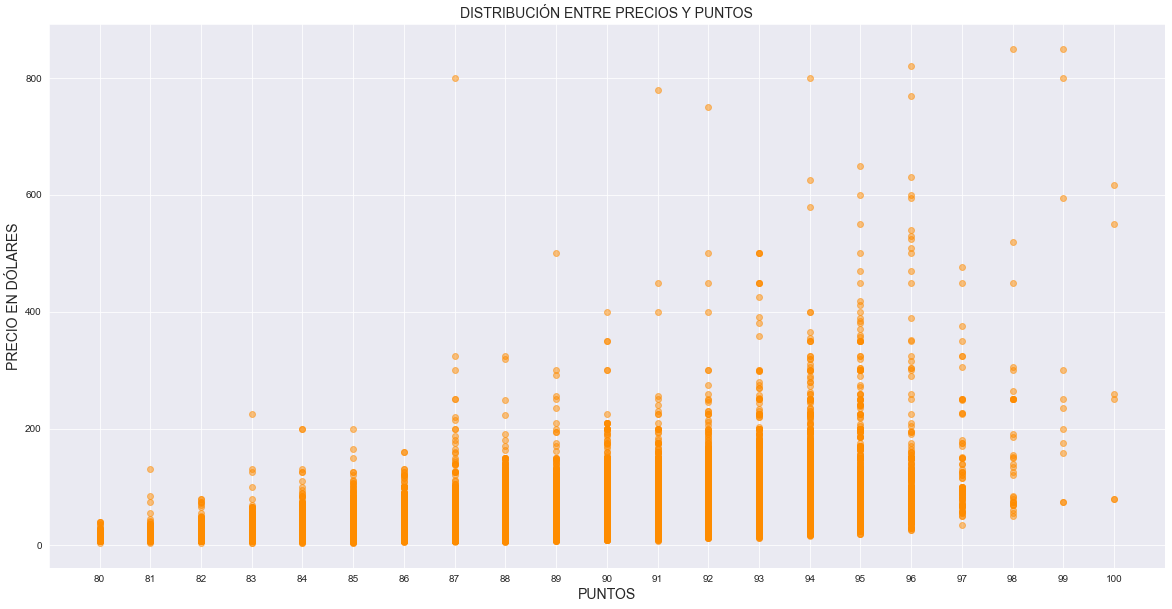

In [42]:
plt.figure(figsize=(20,10))
plt.scatter(df_limpio["points"], df_limpio["price"], color="darkorange", alpha = 0.5)
plt.xticks(np.arange(80,101))
plt.xlabel("PUNTOS", fontsize= 14)
plt.ylabel("PRECIO EN DÓLARES", fontsize= 14)
plt.title('DISTRIBUCIÓN ENTRE PRECIOS Y PUNTOS', fontsize= 14);

## vemos que hay varios OUTLIERs y es probable que luego los borre para la parte de machine learning, pero ahora para el análisis general me interesa más bien dejarlos

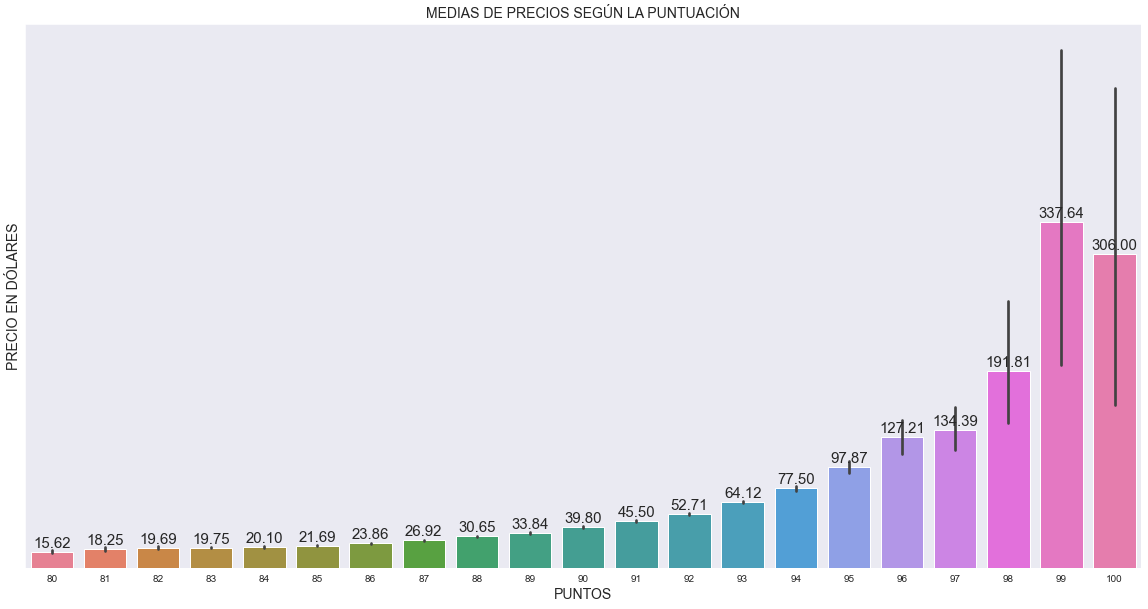

In [447]:
plt.figure(figsize=(20,10))
plots = sns.barplot(x=df_limpio["points"], y=df_limpio["price"], palette="husl")

plt.yticks([])

for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
# plt.yticks(np.arange(0, 550, 50));
plt.xlabel("PUNTOS", fontsize= 14)
plt.ylabel("PRECIO EN DÓLARES", fontsize= 14)
plt.title('MEDIAS DE PRECIOS SEGÚN LA PUNTUACIÓN', fontsize= 14);


In [44]:
## aquí arriba se ve claramente como a más precio corresponde una puntuación mayor 
# (AUNQUE HAY UNA PEQUEÑA BAJADA ENTRE LA PUNTUACIÓN 99 Y LA 100,
# COSTANDO 850 DÓLARES EL VINO MÁS CARO PUNTADO CON 99 Y 617 DÓLARES EL VINO MÁS CARO PUNTUADO CON 100)


## Más consideraciones sobre precio y puntos:
# De las 5 puntuaciones más altas (de 96 a 100), el vino con precio más bajo vale 27$, que ya es un precio alto a mi parecer, y en este rango está también el vino más caro (850$)
# De las 5 puntuaciones más bajas (de 80 a 85), el vino de precio más bajo es de 4$ (coincide con el precio mínimo de todo el df), y él más caro no supera los 225$ (que aún siendo muy caro, es casi 4 veces menos que el vino más caro del df)
# En las valoraciones medianas (de 86 a 95), el vino más barato va desde los 6$ hasta los 20, mientras que de los más caros espacia entre 160$ y 800$

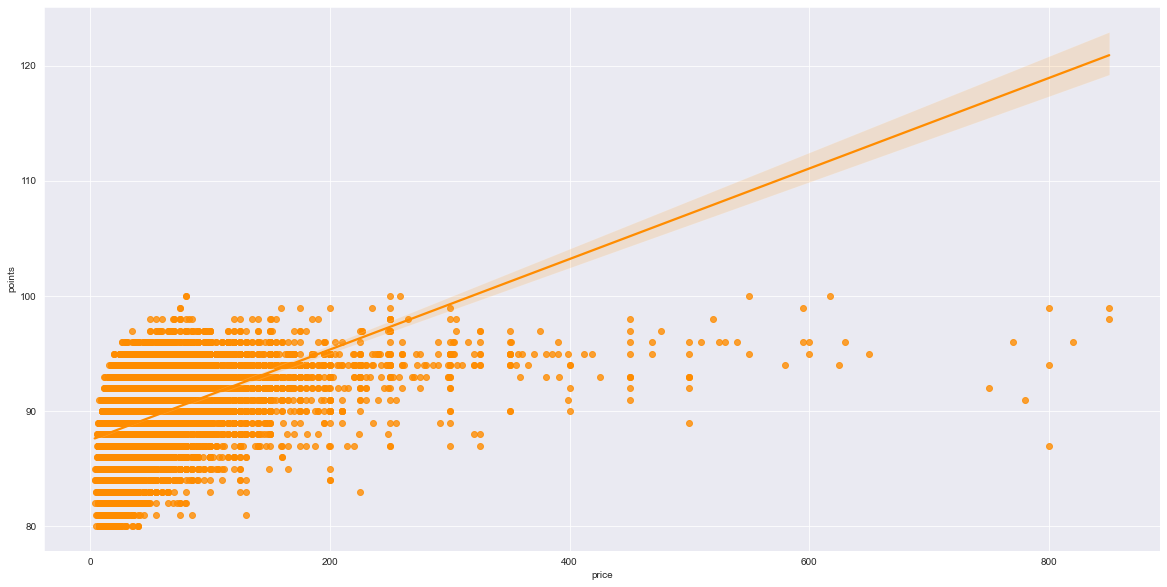

In [397]:
## ahora la correlación
plt.figure(figsize=(20,10))
sns.regplot(x = "price", y = "points", color= "darkorange", data = df_limpio);


<Figure size 1440x720 with 0 Axes>

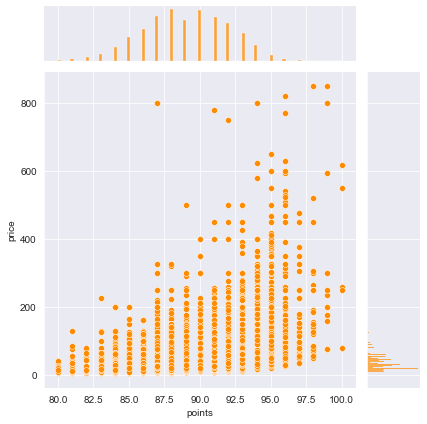

In [402]:
plt.figure(figsize =(20,10))

sns.jointplot(x = 'points', y = "price", color= "darkorange", data = df_limpio);


## AUNQUE EL GRAFICO SE VEA MUY PEQUEÑO (TENGO QUE VER QUÉ PASA) se ve que los precios están concentrados todos hacia un lado, está claro que esto es debido a los outliers

In [47]:
## voy a sacar los boxplot de las variables numéricas (price, points, year)

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


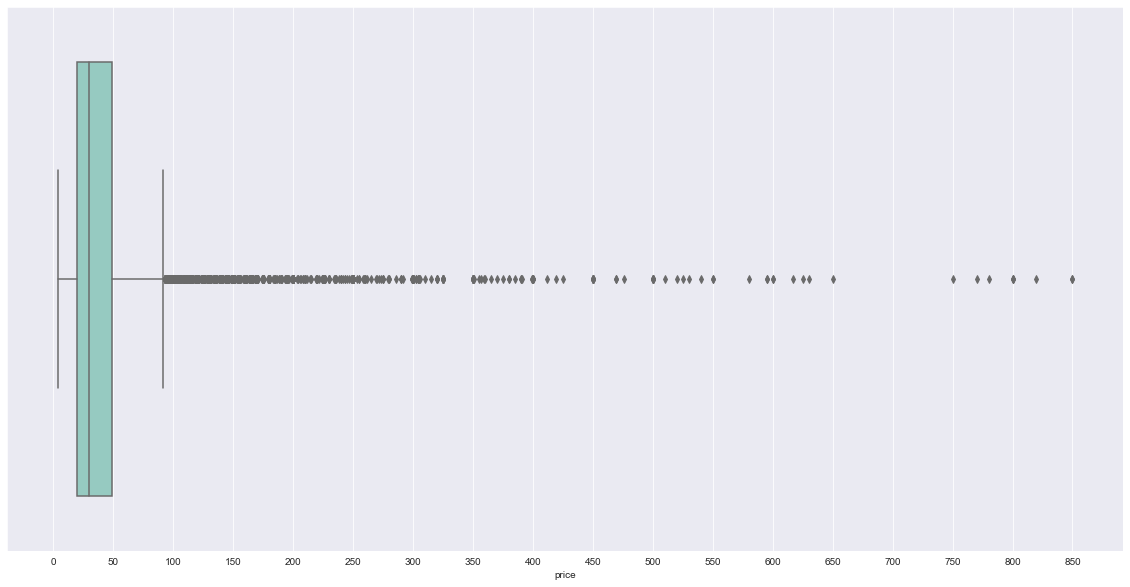

In [48]:
plt.figure(figsize=(20,10))
sns.boxplot(df_limpio["price"]);
plt.xticks(np.arange(0,900, 50));

## Aquí se ven muy claramente los outliers. A partir de aprox 90$
## He de decir que, si bien no mucha gente se gastaría mas de 200$ en un vino(y probablemente mucho menos), esto no significa que no haya vinos que cuesten 200 $ o más
## De hecho, considerando esto, mantedré todos los precios para el análisis principal, y, solo llegado a definir el/los modelos de machine learning, es cuando
## quitarè todos los outliers, para que no influyan en el modelo (aún así, para cada modelo miraré si es sensible o no a los outliers, y dependiendo de eso decidiré si quitarlos o dejarlos)

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


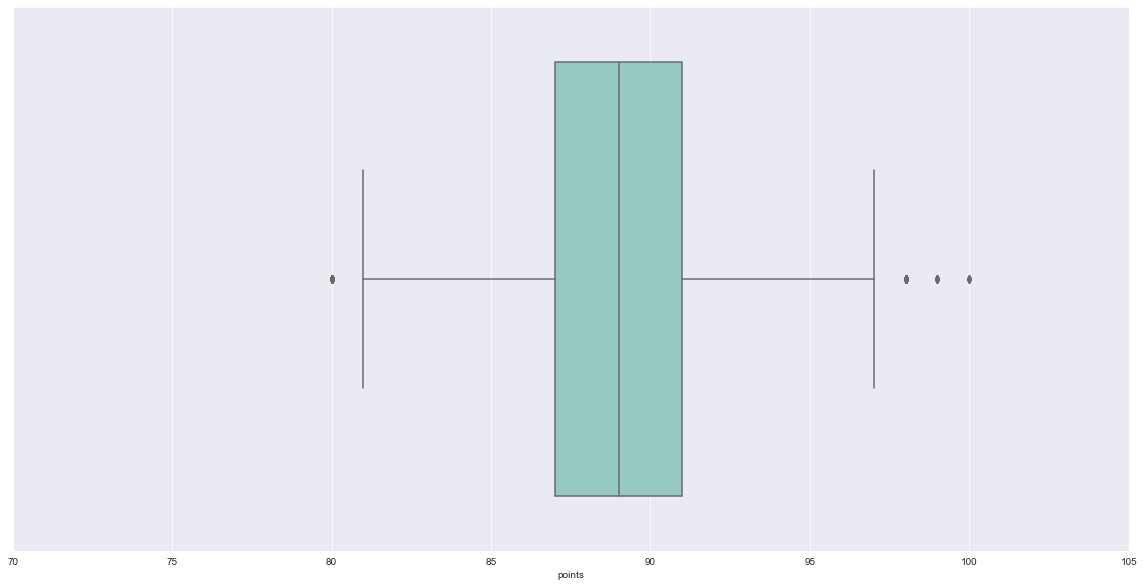

In [49]:
## veo que también las valoraciones tienen outliers, pero nada en absoluto comparado con los precios
plt.figure(figsize=(20,10))
sns.boxplot(df_limpio["points"]);
plt.xticks(np.arange(70,110, 5));

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


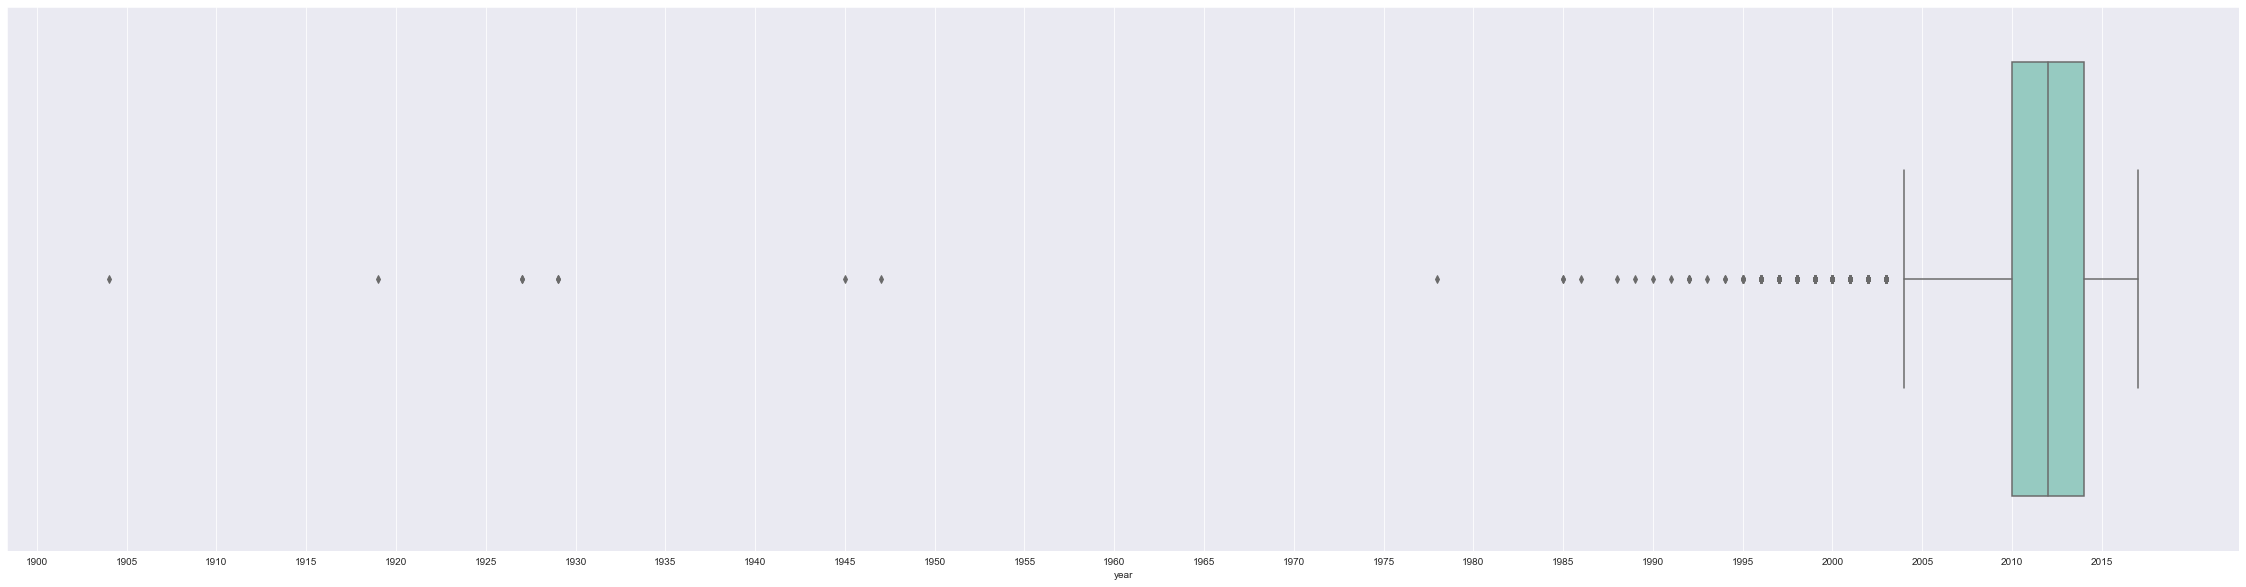

In [50]:
## veo que también los años tienen outliers, de 1904 a 2004 (se referirán seguramente a las producciones "vintage", y me imagino que luego descubriré que a 
# estos outliers les corresponderán los precios más altos
# pero de momento es solo una consideración mía, puede que esté equivocada y que no tenga nada que ver. 
# Lo que sí suele pasar, es que cuánto más "vintage"es un vino, más caro suele ser)

plt.figure(figsize=(40,10))
sns.boxplot(df_limpio["year"])
plt.xticks(np.arange(1900,2020, 5));

In [51]:
### Media de puntuación y precio por País:
## Aunque precio y puntuación parecen crecer a la par, quiero ver si efectivamente es así
## Así que primero haré una grafica con "points" por "country" y luego otra con "price" por "country"
## para ver si efectivamente el País con los vinos más puntuados es también el País con los vinos más caros


In [52]:
## US es el País con los vinos más puntuados (de media), aunque las diferencias son mínimas, estando los primeros 5 países en 89 y pico, la diferencia solo está en los decimales
country_points = df_limpio.groupby("country")["points"].mean().sort_values(ascending=False)
country_points

country
US           89.410345
Canada       89.318182
Australia    89.179526
Italy        89.169716
France       89.162628
Spain        87.515012
Argentina    87.113953
Name: points, dtype: float64

In [53]:
## Italia es el País con los vinos más caros (de media), aquí se ve algo más marcada la diferencia entre primer y segundo puesto, unos 4$ entre los dos valores medios
country_price = df_limpio.groupby("country")["price"].mean().sort_values(ascending=False)
country_price

country
Italy        46.538876
Australia    42.671505
US           40.343733
Canada       40.162338
France       39.831633
Spain        31.475058
Argentina    27.134496
Name: price, dtype: float64

In [54]:
## aquí he querido añadir tambien el valor minimo y máximo de los puntos y de los precios, aunque no he sabido ordenar el dataframe, por lo tanto mantiene el orden por defecto, alfabético, de la columna "country"
country_points_price = df_limpio.groupby("country")["points","price"].agg(["min", "max", "mean"])
country_points_price

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


points                 price                  
             min  max       mean   min    max       mean
country                                                 
Argentina     80   97  87.113953   4.0  230.0  27.134496
Australia     81   99  89.179526   7.0  850.0  42.671505
Canada        82   94  89.318182  12.0  120.0  40.162338
France        80  100  89.162628   6.0  800.0  39.831633
Italy         80  100  89.169716   6.0  800.0  46.538876
Spain         80   98  87.515012   4.0  770.0  31.475058
US            80  100  89.410345   5.0  750.0  40.343733

In [55]:
### AHORA LOS GRÁFICOS:
## aquí se ve mucho mejor como en la puntuacion está más nivelada la cosa, respecto que en el precio
## como explicaba más arriba en el dataframe, apenas hay diferencia entre los 5 primeros países

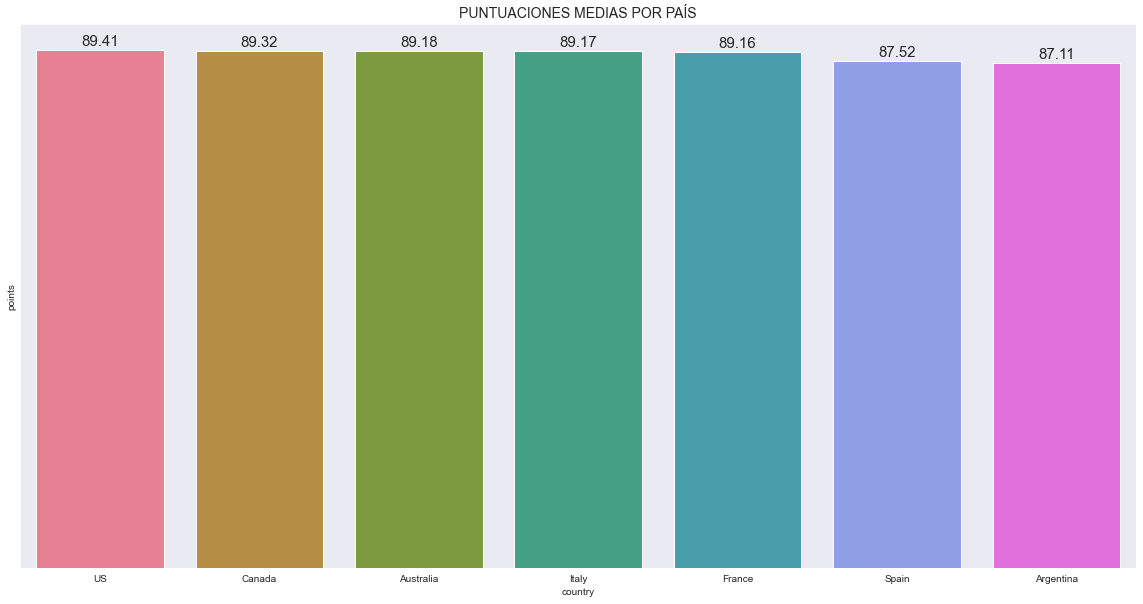

In [422]:
plt.figure(figsize=(20,10))

puntos_por_pais = df_limpio.groupby("country")["points"].mean().sort_values(ascending=False)
puntos_por_pais

plots = sns.barplot(x=puntos_por_pais.index, y=puntos_por_pais, palette="husl")
plt.yticks([])
for bar in plots.patches: 
    
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.title("PUNTUACIONES MEDIAS POR PAÍS", fontsize=14);


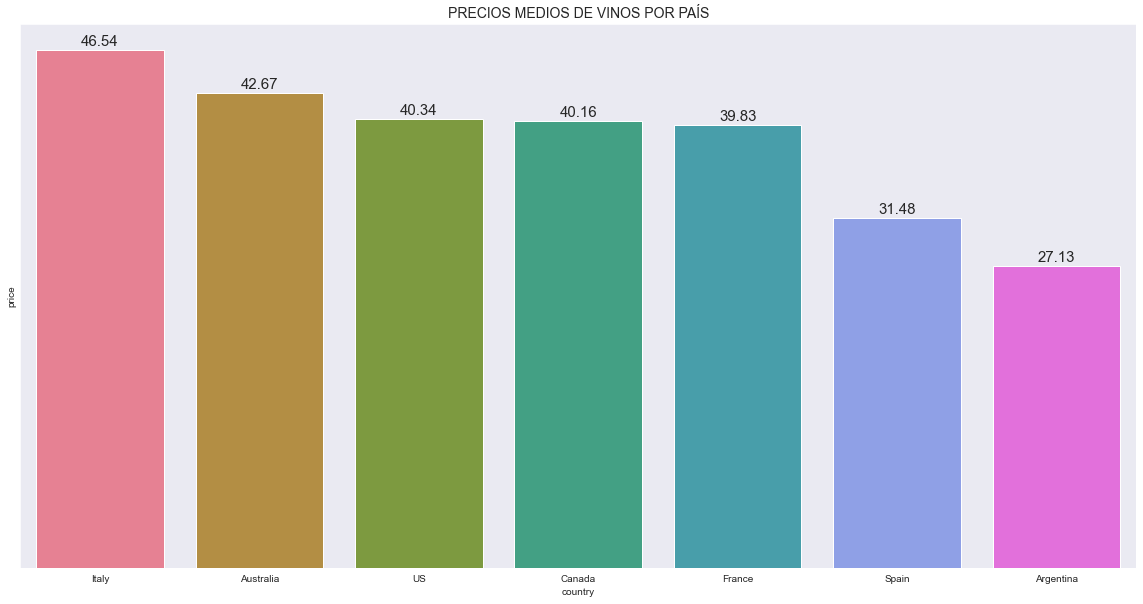

In [424]:
plt.figure(figsize=(20,10))

precios_por_pais = df_limpio.groupby("country")["price"].mean().sort_values(ascending=False)
precios_por_pais

plots = sns.barplot(x=precios_por_pais.index, y=precios_por_pais, palette="husl")
plt.yticks([])
for bar in plots.patches: 
    
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.title("PRECIOS MEDIOS DE VINOS POR PAÍS", fontsize=14);

### Veo que el país que produce vinos con una media de precios más alta es Italia (mi País), y él que tiene los vinos con la media de precio más baja es Argentina
## No sé si luego, en mi modelo de ML, la proveniencia de vino pueda influir en su precio. Lo veré cuando pruebe los varios modelos

In [58]:
## De los países que tengo en mi dataframe, quiero ver cuánto vino produce cada uno

countries = df_limpio['country'].value_counts().sort_values(ascending=False)
countries

US           23239
France        9408
Italy         6122
Spain         4330
Argentina     2580
Australia     1309
Canada         154
Name: country, dtype: int64

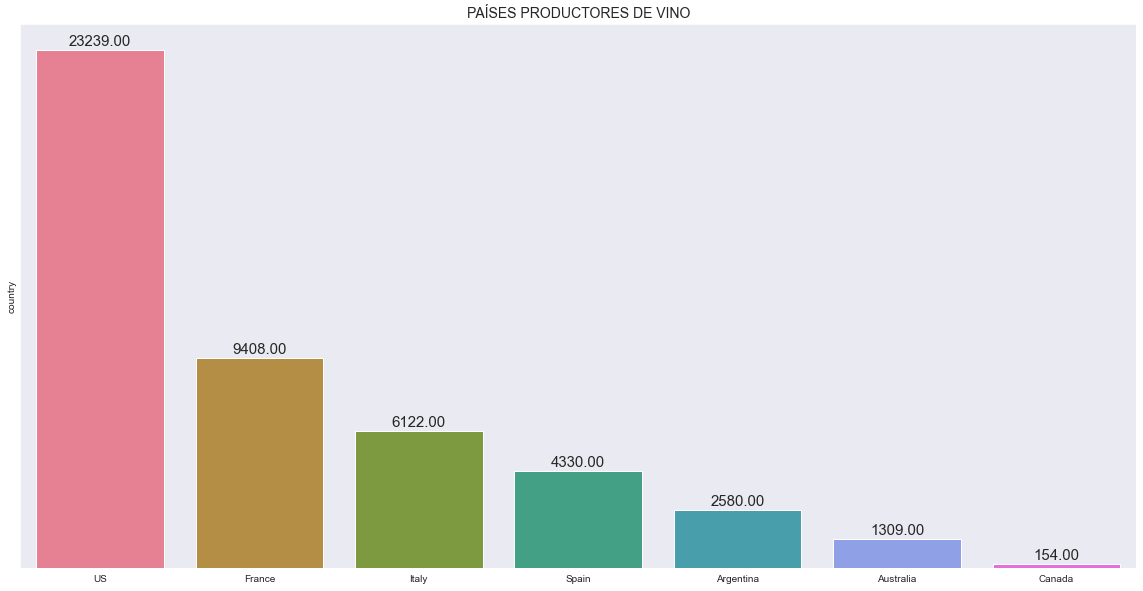

In [425]:
# aquí en un gráfico:

plt.figure(figsize=(20,10))
plots = sns.barplot(x=countries.index, y=countries, palette="husl")
plt.yticks([])
for bar in plots.patches: 
    
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.title("PAÍSES PRODUCTORES DE VINO", fontsize=14);

In [60]:
### ALGUNA CONSIDERACIÓN SOBRE LOS PAÍSES Y LOS PRECIOS
## Italia es el País que produce los vinos de media más caros, aunque no es él qué más vinos produce, estando USA en primera posición
## Aunque probablemente esto se deba a la extensión del País y, a cuánta más superficie, más viñedos y, por consecuencia, más producción

In [61]:
## análisis muy rápido para ver, para cada provincia italiana, cuáles son las medias de precios
provincias_it = df_limpio[df_limpio['country']=='Italy'].sort_values(['price'], ascending = False)[['province', "price"]]
provincias_it

,province,price
39794,Tuscany,800.0
17157,Piedmont,595.0
23937,Tuscany,550.0
17508,Tuscany,550.0
10596,Tuscany,540.0
...,...,...
43882,Sicily & Sardinia,8.0
14236,Sicily & Sardinia,8.0
25581,Northeastern Italy,7.0
23098,Tuscany,7.0


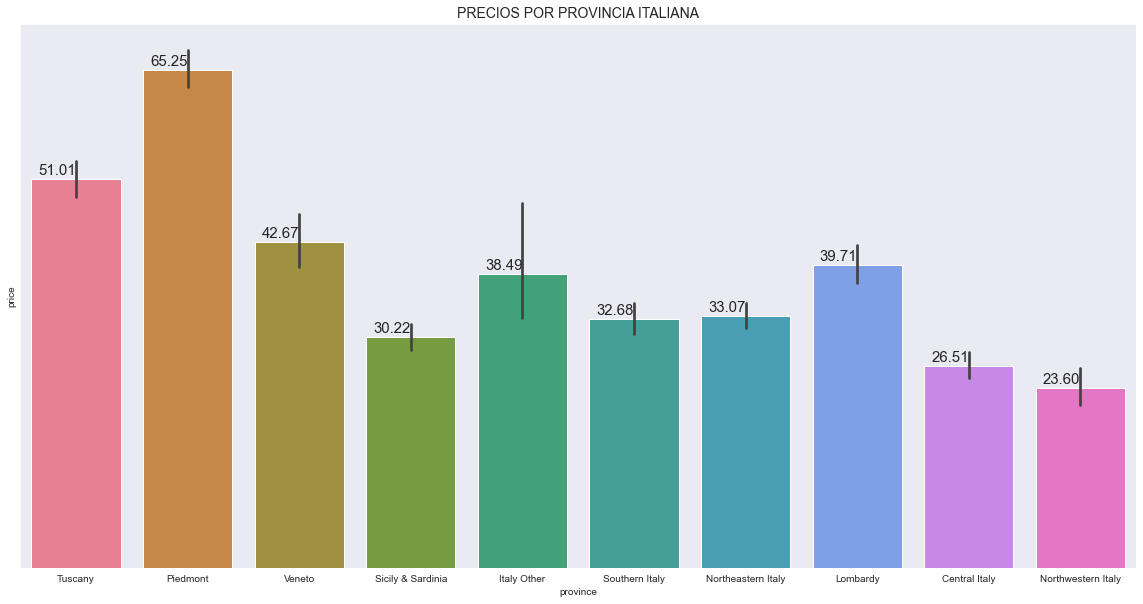

In [432]:
## Aquí lo traslado a un gráfico, para que sea más visual
## Pequeña anecdota: mi región (Veneto) está en tercera posición, siendo Piemonte la región con los vinos más caros y el noroeste de Italia la con los vinos más baratos
plt.figure(figsize=(20,10))

provincias_it = df_limpio[df_limpio['country']=='Italy'].sort_values(['price'], ascending = False)[['province', "price"]]
provincias_it
plots = sns.barplot(x=provincias_it["province"], y=provincias_it["price"], palette="husl")
plt.yticks([])
for bar in plots.patches: 
    
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='right', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.title("PRECIOS POR PROVINCIA ITALIANA", fontsize=14);

In [63]:
bodega_price = df_limpio.groupby("winery")["price"].mean().sort_values(ascending=False)
bodega_price

winery
Yao Ming           625.00
Poggio di Sotto    500.00
Gaja               470.00
Krug               439.75
Salon              421.75
                    ...  
Iranzo Fields        6.00
Earth's Harvest      5.00
Viña Decana          5.00
Terrenal             4.75
Broke Ass            4.00
Name: price, Length: 8290, dtype: float64

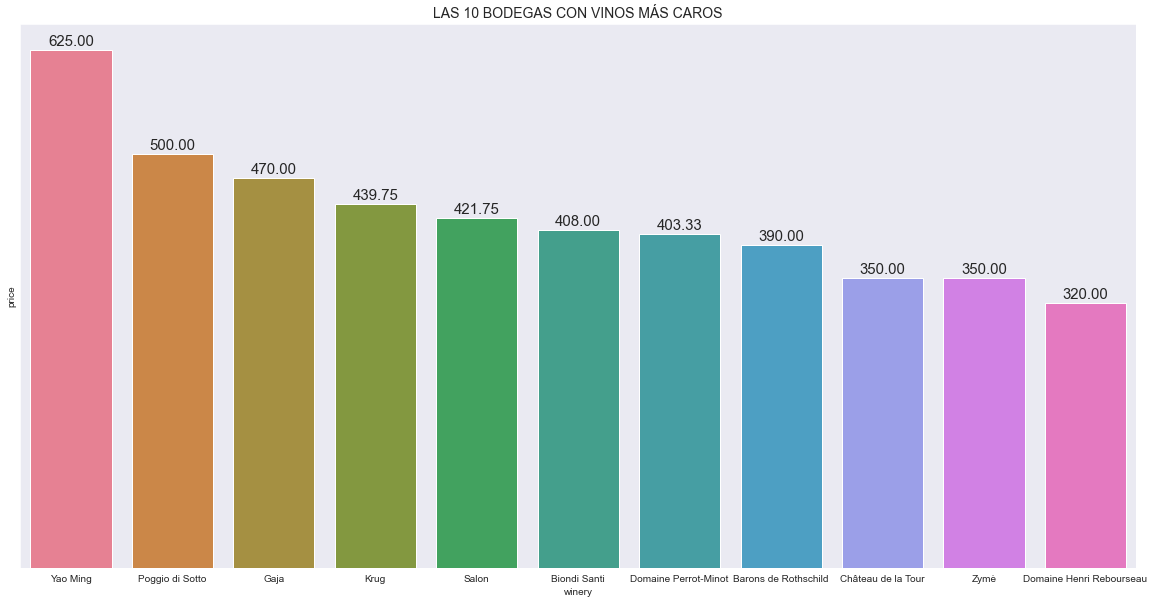

In [433]:
### precios por bodegas (winery)
### Para sacar el gráfico me quedo con las 10 bodegas que producen el vino más caro, de media (es imposible que pueda ponerlas todas, son más de 8000, por lo tanto me quedo con el top 10)
plt.figure(figsize=(20,10))

bodega_price_top10 = df_limpio.groupby("winery")["price"].mean().sort_values(ascending=False)[:11]
bodega_price_top10

plots = sns.barplot(x=bodega_price_top10.index, y=bodega_price_top10, palette="husl")
plt.yticks([])

for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.title("LAS 10 BODEGAS CON VINOS MÁS CAROS", fontsize=14);


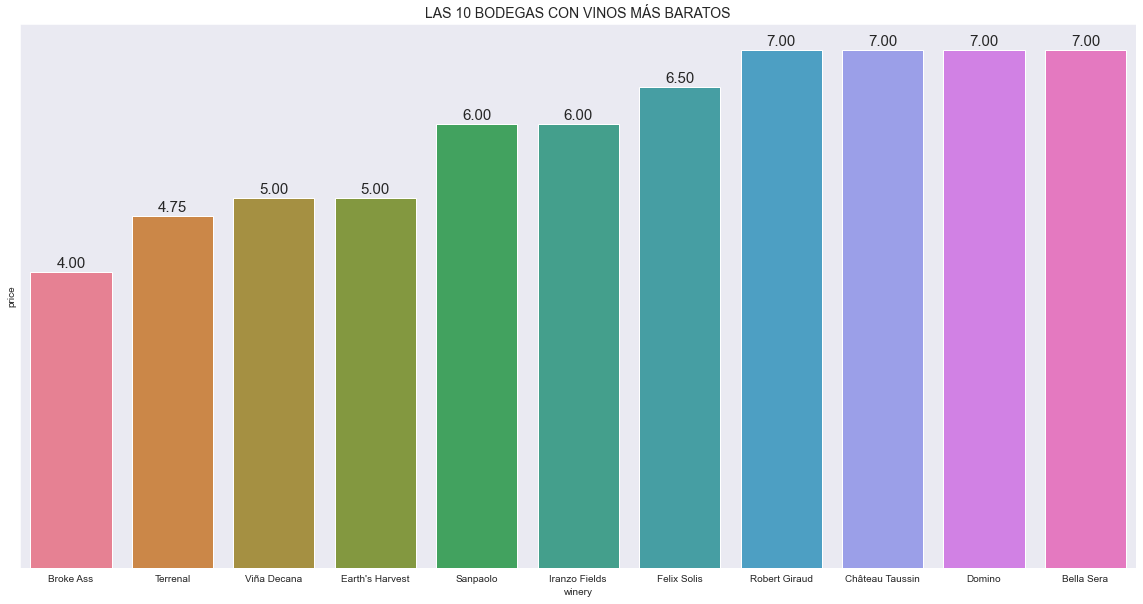

In [434]:
### Hago lo mismo pero con las 10 bodegas que producen el vino más barato (de media)
plt.figure(figsize=(20,10))

bodega_price_barato = df_limpio.groupby("winery")["price"].mean().sort_values(ascending=True)[:11]
bodega_price_barato

plots = sns.barplot(x=bodega_price_barato.index, y=bodega_price_barato, palette="husl")
plt.yticks([])

for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.title("LAS 10 BODEGAS CON VINOS MÁS BARATOS", fontsize=14);

In [66]:
## Alguna consideración sobre el rango de precios
## Veo que en este dataframe el rango va de los 4$ para el vino más barato hasta los 625$ para el más caro

In [67]:
## al igual que he sacado , respecto a las bodegas, los 10 vinos más caros y los 10 más baratos, ahroa quiero hacer lo mismo pero con respecto a las puntuaciones

In [68]:
## TODO EL DATAFRAME, BODEGAS/PUNTUACIONES, ordenado de las más altas a las más bajas
bodega_points = df_limpio.groupby("winery")["points"].mean().sort_values(ascending=False)
bodega_points

winery
Conti Costanti     98.000000
Baricci            98.000000
Krug               97.500000
Alpha Omega        97.111111
Standish           97.000000
                     ...    
Campo Marin        80.000000
Sierra Virgen      80.000000
Cristobal 1492     80.000000
Familia Montaña    80.000000
Ardales            80.000000
Name: points, Length: 8290, dtype: float64

In [69]:
## TOP 10 MEJOR PUNTUADOS
bodega_points_top10 = df_limpio.groupby("winery")["points"].mean().sort_values(ascending=False)[:11]
bodega_points_top10

winery
Conti Costanti           98.000000
Baricci                  98.000000
Krug                     97.500000
Alpha Omega              97.111111
Standish                 97.000000
Gianni Brunelli          97.000000
Salon                    97.000000
Château Pape Clément     96.000000
Tenuta dell'Ornellaia    96.000000
Barons de Rothschild     96.000000
Il Marroneto             96.000000
Name: points, dtype: float64

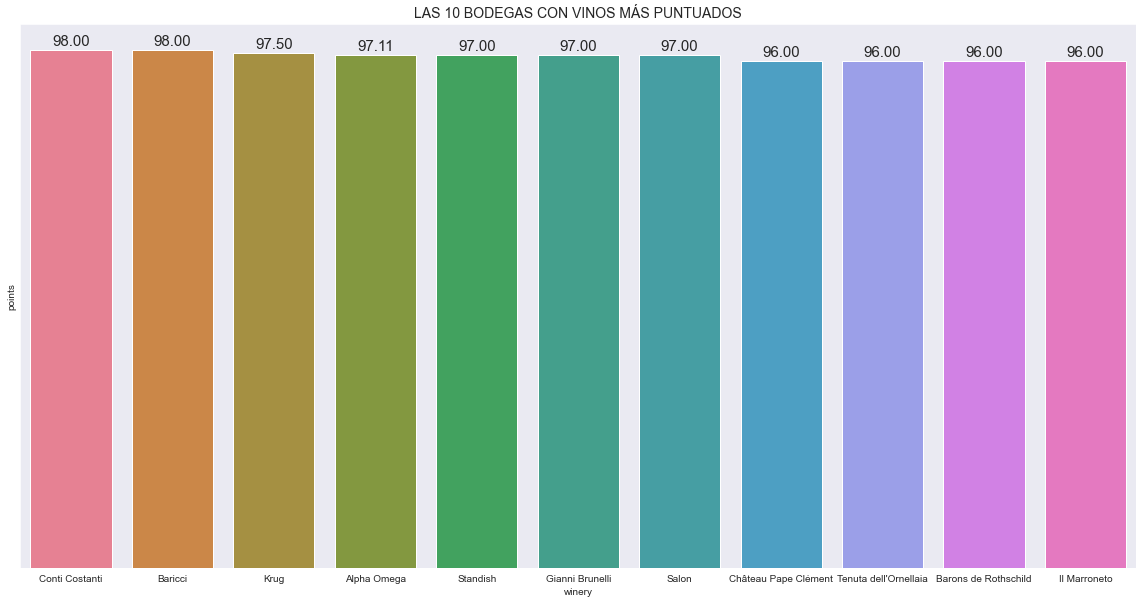

In [435]:
### puntuación por bodegas (winery)
### los 10 vinos mejor puntuados
plt.figure(figsize=(20,10))

bodega_points_top10 = df_limpio.groupby("winery")["points"].mean().sort_values(ascending=False)[:11]
bodega_points_top10

plots = sns.barplot(x=bodega_points_top10.index, y=bodega_points_top10, palette="husl")
plt.yticks([])

for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.title("LAS 10 BODEGAS CON VINOS MÁS PUNTUADOS", fontsize=14);

In [71]:
# TOP 10 MENOR PUNTUADOS
bodega_points_peor_10 = df_limpio.groupby("winery")["points"].mean().sort_values(ascending=True)[:11]
bodega_points_peor_10

winery
Vega de Tera         80.0
Reyter               80.0
Familia Montaña      80.0
Namasté Vineyards    80.0
Cristobal 1492       80.0
Bodegas del Mundo    80.0
La Val               80.0
Baroncini            80.0
Baron Herzog         80.0
3 Steves Winery      80.0
Moss Roxx            80.0
Name: points, dtype: float64

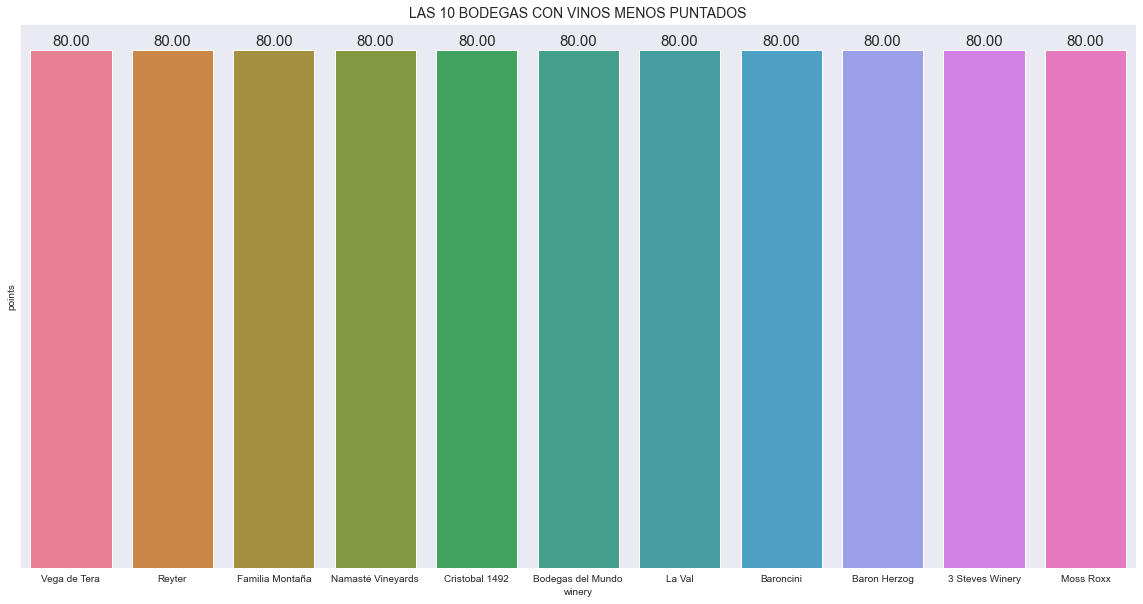

In [436]:
### puntuación por bodegas (winery)
### los 10 vinos peor puntuados
plt.figure(figsize=(20,10))

bodega_points_peor_10 = df_limpio.groupby("winery")["points"].mean().sort_values(ascending=True)[:11]
bodega_points_peor_10

plots = sns.barplot(x=bodega_points_peor_10.index, y=bodega_points_peor_10, palette="husl")
plt.yticks([])

for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.title("LAS 10 BODEGAS CON VINOS MENOS PUNTADOS", fontsize=14);

In [73]:
#### ahora voy a ver las puntuaciones y los precios según el catador

In [74]:
taster_point = df_limpio.groupby("taster_name")["points"].mean().sort_values(ascending=False)
taster_point

taster_name
Christina Pickard     93.000000
Anne Krebiehl MW      91.062567
Matt Kettmann         90.534546
Virginie Boone        89.582921
Paul Gregutt          89.503888
Kerin O’Keefe         89.191304
Jim Gordon            89.182663
Sean P. Sullivan      89.129064
Roger Voss            89.052200
Joe Czerwinski        88.928268
Anna Lee C. Iijima    87.608054
Michael Schachner     87.368301
Lauren Buzzeo         87.220779
Fiona Adams           86.875000
Carrie Dykes          86.702381
Alexander Peartree    85.860870
Susan Kostrzewa       84.696552
Name: points, dtype: float64

In [75]:
taster_price = df_limpio.groupby("taster_name")["price"].mean().sort_values(ascending=False)
taster_price

taster_name
Virginie Boone        51.272832
Christina Pickard     50.000000
Kerin O’Keefe         46.909030
Matt Kettmann         42.063929
Roger Voss            41.310373
Joe Czerwinski        40.619632
Fiona Adams           39.375000
Paul Gregutt          37.943205
Sean P. Sullivan      37.549436
Anne Krebiehl MW      34.738943
Carrie Dykes          32.916667
Jim Gordon            31.273330
Alexander Peartree    31.056522
Michael Schachner     29.929304
Susan Kostrzewa       25.048276
Anna Lee C. Iijima    24.748993
Lauren Buzzeo         21.984416
Name: price, dtype: float64

In [76]:
## y también pinto sus respectivos gráficos

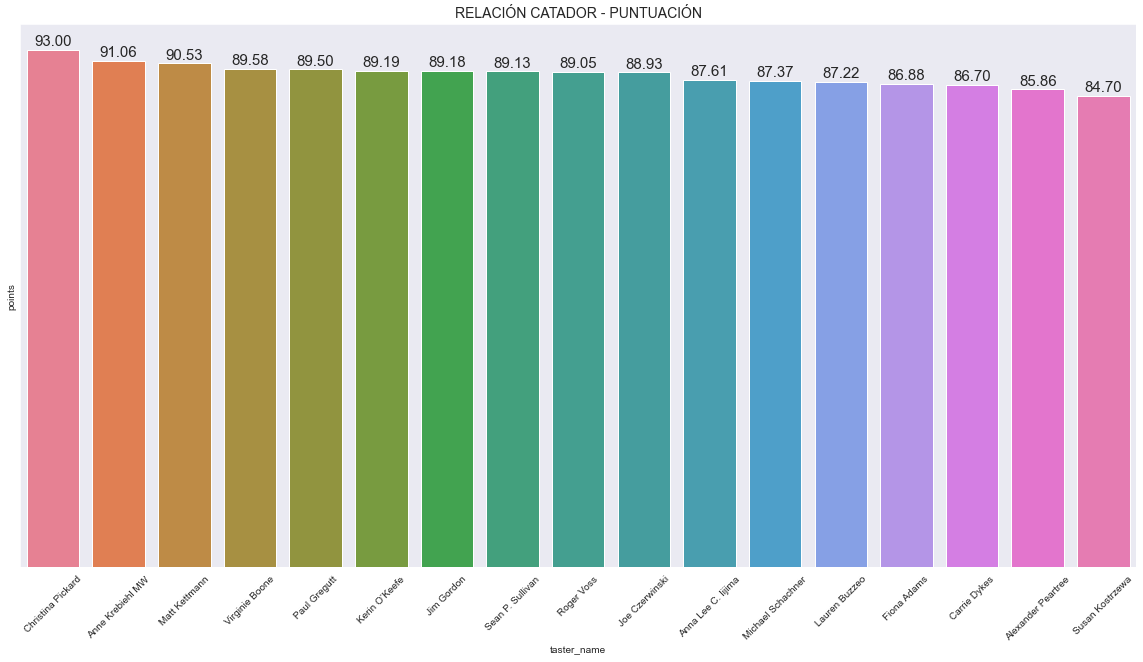

In [437]:
### puntuación por catador

plt.figure(figsize=(20,10))

taster_point = df_limpio.groupby("taster_name")["points"].mean().sort_values(ascending=False)
taster_point

plots = sns.barplot(x=taster_point.index, y=taster_point, palette="husl")
plt.xticks(rotation= 45)

plt.yticks([])

for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.title("RELACIÓN CATADOR - PUNTUACIÓN", fontsize=14);

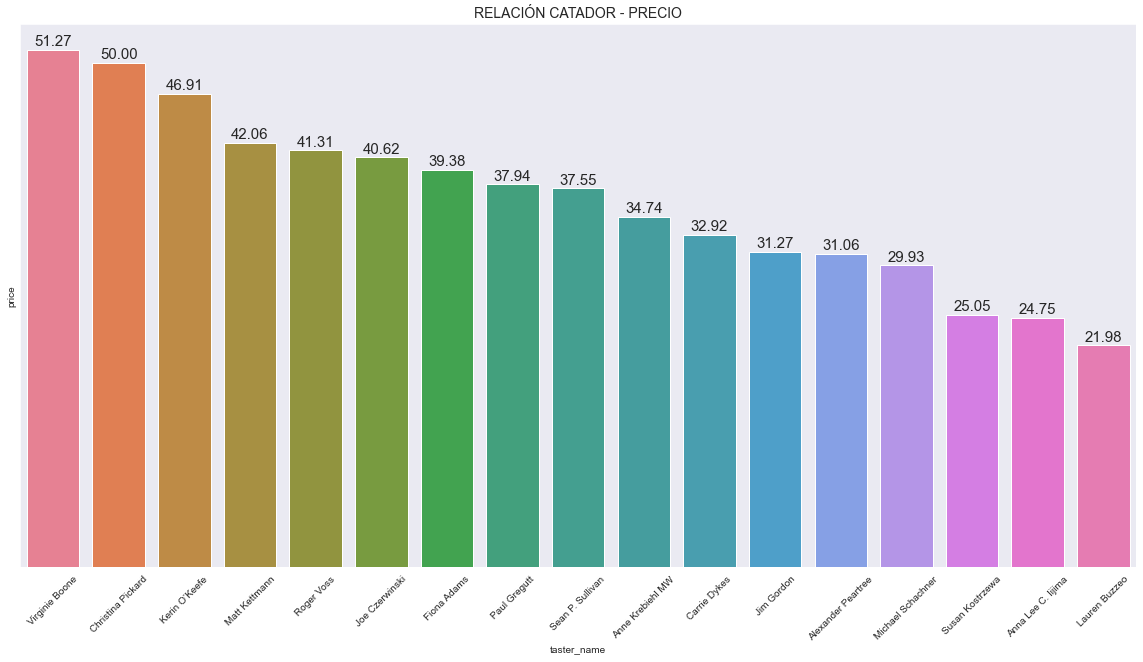

In [439]:
### precio por catador

plt.figure(figsize=(20,10))

taster_price = df_limpio.groupby("taster_name")["price"].mean().sort_values(ascending=False)
taster_price

plots= sns.barplot(x=taster_price.index, y=taster_price, palette="husl")
plt.xticks(rotation= 45)

plt.yticks([])

for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.title("RELACIÓN CATADOR - PRECIO", fontsize=14);

In [79]:
## recordemos las estadísticas de los valores numéricos
## precio medio 39.57$ / primer cuartil 20$ / mediana 30$ /  tercer cuartil 49$
## puntuación media 89.02$ / primer cuartil 87$ / mediana 89$ /  tercer cuartil 91$
df_limpio.describe()

,points,price,year
count,47142.000000,47142.000000,47142.000000
mean,89.023185,39.572589,2011.477154
std,3.013534,35.809319,3.346880
min,80.000000,4.000000,1904.000000
25%,87.000000,20.000000,2010.000000
50%,89.000000,30.000000,2012.000000
75%,91.000000,49.000000,2014.000000
max,100.000000,850.000000,2017.000000


In [80]:
## CONSIDEARCIONES sobre las relaciones entre los catadores y la puntuación/precio:

###### personas que han puntuado los vinos más caros (primeras 3 posiciones, precios medios):
## La catadora que puntua más alto (93.0, por encima del 3º cuartil), ha puntuado los vinos que están en segunda posición en cuanto a los precios medios más altos (también por encima del 3º cuartil, 50$)
## La catadora que está en cuarta posición en cuanto a puntuación (89.58, más cercano a la mediana), es la que ha puntuado los vinos de media más caros (51.27, por encima del 3º cuartil)
## la catadora que está en tercera posción en cuanto a precios (puntuando con una media de 46.9$, que está entre la mediana y el tercer cuartil), en cuanto a puntuaciones está en el sexto puesto (puntuando con una media de 89.19, que corresponde a la mediana)

###### personas que han puntuado los vinos más baratos (últimas 3 posiciones, precios medios):
## los 3 catadores de los vinos con precios más bajos (25.04, 24.74, 21.98) están en la escala de las puntuaciones, respectivamente en última posición(84.69), posición 11(87.60) y 13(87.22) (en toro al primer cuartil de las puntuaciones)

## Aunque no sea una relación súper estricta, pero sí que vemos una tendencia de que los que puntuan los vinos con precios más bajos también usan unas valoraciones más bajas
## mientras que los que puntuan los vinos más caros, suelen dar valoraciones más altas



In [81]:
## ahora quiero ver cómo se relaciónan los precios de los vinos según el año de producción
year_price = df_limpio.groupby("year")["price"].mean()
year_price

year
1904     40.000000
1919     13.000000
1927     27.500000
1929     22.500000
1945    350.000000
1947    258.000000
1978    225.000000
1985     46.500000
1986    155.000000
1988    200.000000
1989    100.000000
1990    200.000000
1991     32.000000
1992     60.000000
1993     30.000000
1994    125.000000
1995     90.625000
1996     72.958333
1997     35.408163
1998     43.060302
1999     45.875000
2000     50.413793
2001     32.299213
2002     67.105691
2003     48.776119
2004     51.485437
2005     42.729120
2006     40.909237
2007     38.879896
2008     41.046512
2009     41.750963
2010     43.009084
2011     42.340315
2012     42.588473
2013     40.969980
2014     37.935760
2015     29.166195
2016     19.964263
2017     11.833333
Name: price, dtype: float64

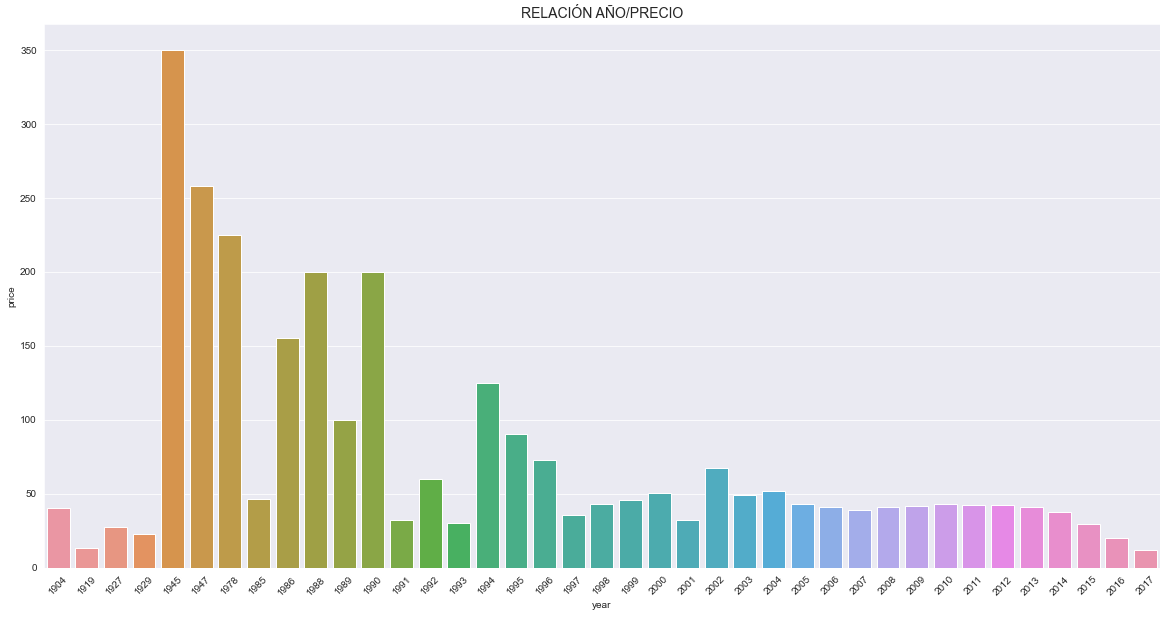

In [442]:
## vamos a graficarlo:

plt.figure(figsize=(20,10))

sns.barplot(x=year_price.index, y=year_price)
plt.xticks(rotation= 45)
plt.title("RELACIÓN AÑO/PRECIO", fontsize=14);

In [83]:
## a ver las puntuaciones respecto a los años:
year_points= df_limpio.groupby("year")["points"].mean()
year_points

year
1904    91.000000
1919    88.000000
1927    95.000000
1929    85.000000
1945    95.000000
1947    93.000000
1978    83.000000
1985    90.500000
1986    92.000000
1988    93.000000
1989    83.000000
1990    84.000000
1991    90.000000
1992    91.250000
1993    84.000000
1994    89.000000
1995    90.375000
1996    89.416667
1997    88.265306
1998    88.346734
1999    88.598684
2000    87.993103
2001    87.590551
2002    88.853659
2003    88.059701
2004    88.769417
2005    88.546275
2006    88.485944
2007    88.256527
2008    88.491341
2009    88.819615
2010    88.982337
2011    88.922479
2012    89.342041
2013    89.363900
2014    89.382896
2015    88.900519
2016    87.807018
2017    84.833333
Name: points, dtype: float64

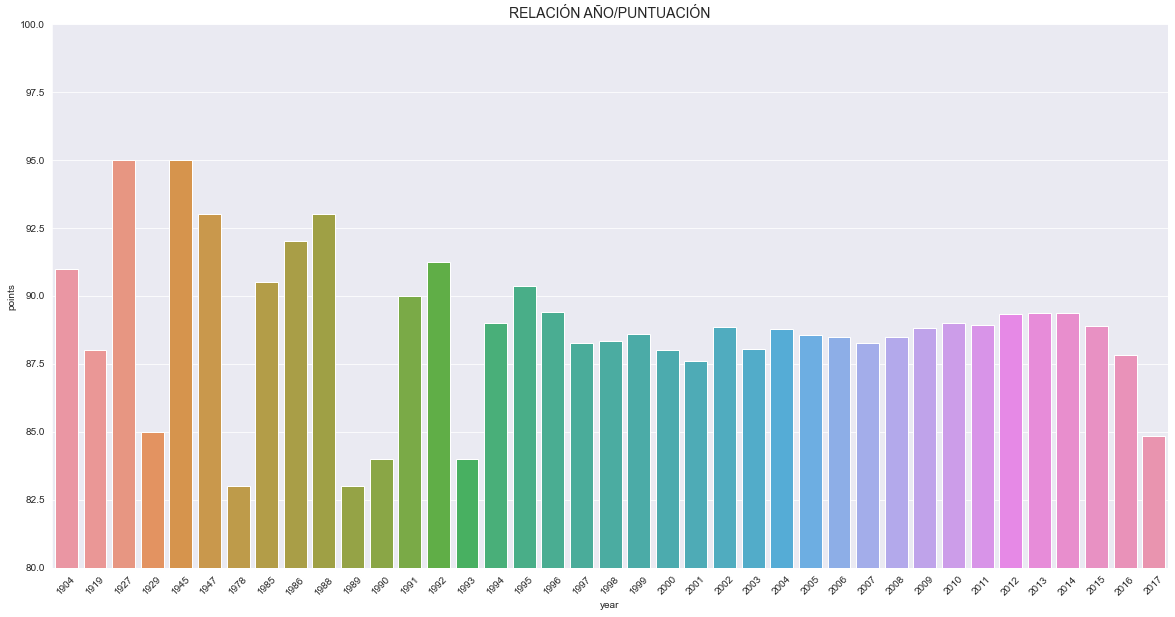

In [443]:
## vamos a graficarlo:

### ATENCIÓN: EL EJE "y" VA DE 80 A 100, O SEA SE CORRESPONE A LAS VALORACIONES, es para visualizar algo mejor las variaciones, puesto que los puntos van de 80 a 100 y si no, si lo hacía empezar en 0, no se notaban tanto los cambios

plt.figure(figsize=(20,10))

grafico = sns.barplot(x=year_points.index, y=year_points)
plt.xticks(rotation= 45)

grafico.set_ylim(80,100)
plt.title("RELACIÓN AÑO/PUNTUACIÓN", fontsize=14);



In [85]:
### CONSIDERACIONES PRECIO/AÑO 
## no es exactamente como me esperaba, que a más antiguo el vino, más precio, ya que los 4 años más antiguos tienen un rango de precio bajo respecto al resto (13$ para vinos del año 1919, por ejemplo. Y justo en ese año hay una puntuación de casi 88)
## pero sí es cierto que, quitando los primeros 4 años del dataframe, los años con los precios decisamente más altos (por encima de los 100$) van de 1945 a 1990 (quitando 1985, que ha sido un año "malo") y luego un repunte aislado en 1994, con un precio medio de 125$


### CONSIDERACIONES PUNTUACIÓN /AÑO
## las puntuaciones fluctuan sin mucha lógica en la primera mitad de los años (aprox) y luego ya se van estabilizando y rondan alrededor de los 87/88 puntos
## Luego de repente en 2017 (el último año de estudio) hay una bajada a 84.83
## las medias más bajas de puntuaciones las tenemos en los años 1978 y 1989
## las medias más altas de puntuaciones las tenemos en los años 1927 y 1945

#### 3  **VARIEDADES DE UVAS**

In [86]:
## quiero ver cuáles son las variedades y qué rango de precios tiene cada una
## hay unas diferencias brutales entre precios mínimos y máximos, por lo tanto en el gráfico usaré las medianas, y así que no influyan tanto los outliers
uvas_precios = df.groupby('variety')['price'].agg([min,max, np.mean, np.median]).sort_values(by=['median'],ascending=False)
uvas_precios

,min,max,mean,median
variety,,,,
Francisa,160.0,160.0,160.000000,160.0
Sherry,155.0,155.0,155.000000,155.0
Cabernet-Shiraz,150.0,150.0,150.000000,150.0
Marzemino,130.0,130.0,130.000000,130.0
Malbec-Cabernet,45.0,165.0,113.333333,130.0
...,...,...,...,...
Merseguera-Sauvignon Blanc,9.0,9.0,9.000000,9.0
Bobal-Cabernet Sauvignon,9.0,9.0,9.000000,9.0
Tinto Velasco,9.0,9.0,9.000000,9.0


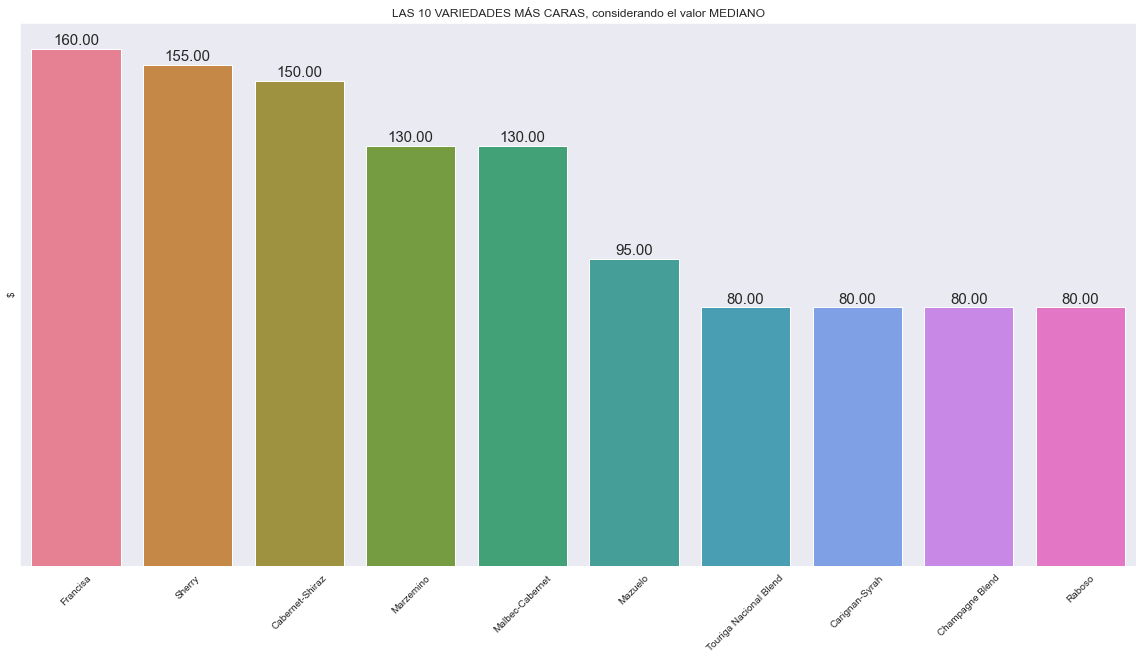

In [449]:
## y aquí lo quiero ver con un gráfico

plt.figure(figsize=(20,10))
plt.xticks(rotation=45)

plots = sns.barplot(x=uvas_precios.index[0:10], y=uvas_precios['median'][0:10], palette="husl")

plt.yticks([])

for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.ylabel('$')
plt.xlabel('')
plt.title('LAS 10 VARIEDADES MÁS CARAS, considerando el valor MEDIANO');

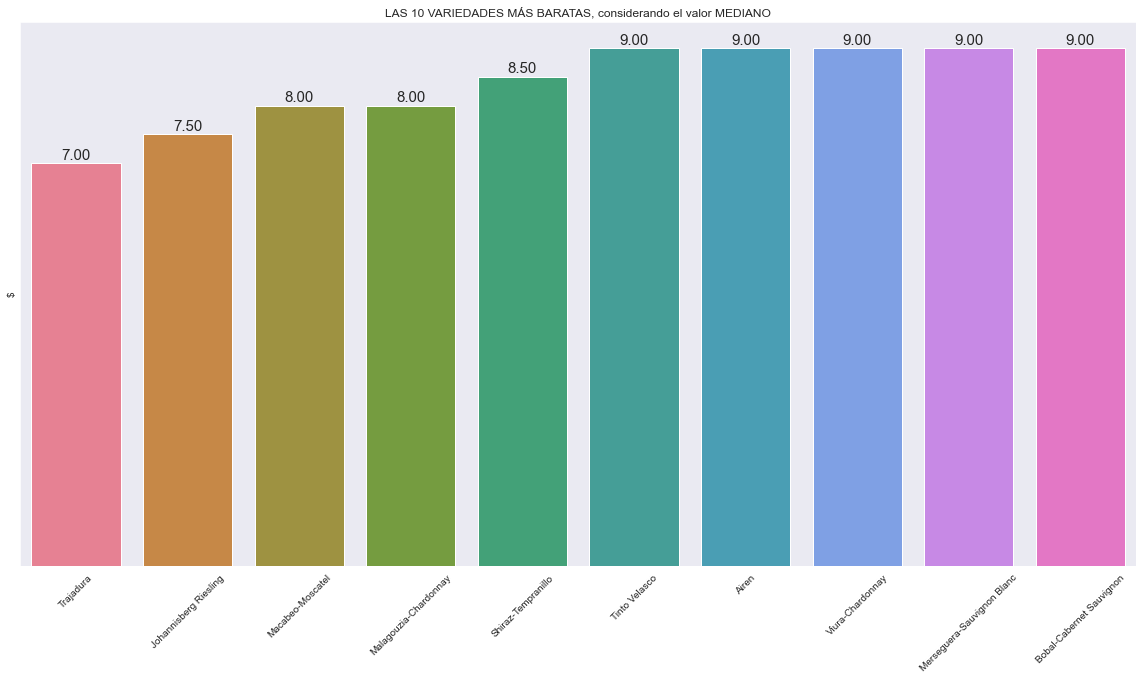

In [451]:
uvas_precios_baratas = df.groupby('variety')['price'].agg([min,max, np.mean, np.median]).sort_values(by=['median'],ascending=True)
## y aquí las mas baratas (siempre considerando el valor mediano, para que no influyan los outliers)

plt.figure(figsize=(20,10))
plt.xticks(rotation=45)

plots = sns.barplot(x=uvas_precios_baratas.index[0:10], y=uvas_precios_baratas['median'][0:10], palette="husl")

plt.yticks([])

for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 
plt.ylabel('$')
plt.xlabel('')
plt.title('LAS 10 VARIEDADES MÁS BARATAS, considerando el valor MEDIANO');

In [89]:
## después de hacer estos últimos 2 gráficos, se me ocurre que podría juntar todos los valores estadísticos en uno

## Primero el dataframe:
uvas= df_limpio.groupby("variety")["price"].describe()
uvas


,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Abouriou,2.0,45.000000,42.426407,15.0,30.00,45.0,60.00,75.0
Aglianico,112.0,44.857143,27.058115,6.0,25.00,40.0,60.00,180.0
Airen,2.0,9.500000,0.707107,9.0,9.25,9.5,9.75,10.0
Albana,12.0,19.750000,7.021072,13.0,15.00,17.5,22.50,38.0
Albanello,1.0,20.000000,NaN,20.0,20.00,20.0,20.00,20.0
...,...,...,...,...,...,...,...,...
White Riesling,2.0,23.500000,23.334524,7.0,15.25,23.5,31.75,40.0
Xarel-lo,16.0,16.875000,4.856267,12.0,13.75,15.0,19.25,30.0
Zibibbo,10.0,34.200000,14.868311,19.0,20.75,32.0,43.50,60.0


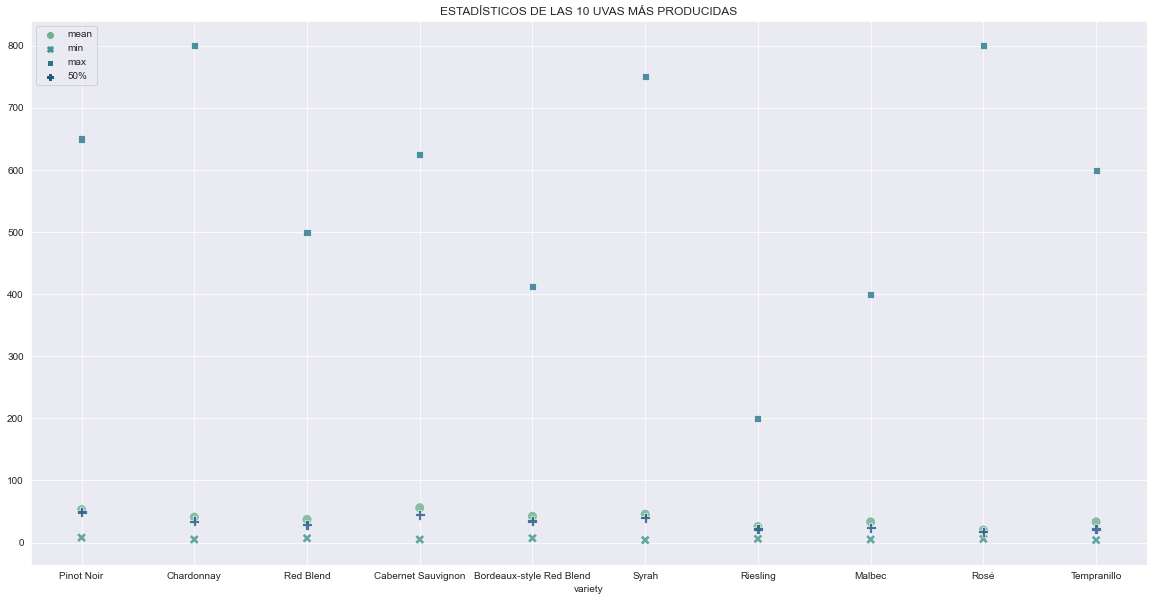

In [90]:
## y ahora con un scatterplot
## al ser más de 400 variedades, es imposible que salga un gráfico claro, así que para el gráfico usaré el top 10 de las variedades, ordenadas por cantidad ( o sea las más usadas)
uvas_top10 = uvas.sort_values(by=["count"],ascending=False)[:10]

fig = plt.figure(figsize=(20,10))
ax = plt.axes()

ax.set_title("ESTADÍSTICOS DE LAS 10 UVAS MÁS PRODUCIDAS");

sns.scatterplot(data=uvas_top10[["mean","min","max", "50%"]], palette="crest", marker= "o", s= 100, alpha=0.8 );

plt.legend(loc="upper left");

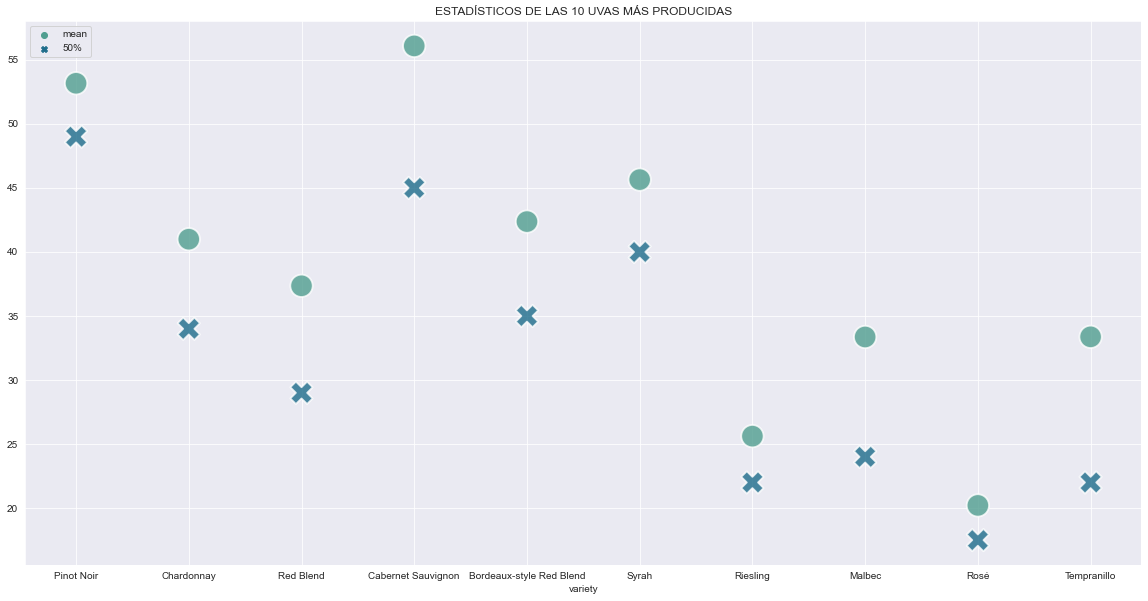

In [91]:
## conservo el anterior gráfico en este notebook para que se vea que, por los outliers, es muy complicado de leerlo (pero NO lo voy a incluir en la presentación)
## en este me quedaré solo con el valor medio y mediano, que se vea la diferencia entre estos 2 valores, debida claramente a los outliers

uvas_top10 = uvas.sort_values(by=["count"],ascending=False)[:10]

fig = plt.figure(figsize=(20,10))
ax = plt.axes()

ax.set_title("ESTADÍSTICOS DE LAS 10 UVAS MÁS PRODUCIDAS");

sns.scatterplot(data=uvas_top10[["mean","50%"]], palette="crest", marker= "o", s= 500, alpha=0.8 );

plt.legend(loc="upper left");

#### 4  **ALGUNA CONSIDERACIÓN GENERAL ORDENANDO Y FILTRANDO EL DATAFRAME, SIN GRÁFICOS**

##### 4.1 PRECIO MÁS ALTO y MÁS BAJO DE LA BOTELLA DE VINO

In [92]:
## quiero ordenar el dataframe según los precios, de mayor a menor
df_limpio.sort_values(by="price", ascending=False).head(6)

## NOTA: aunque Italia sea el País con los vinos más caros DE MEDIA, el vino más caro de este dataframe  es de Australia (580$), pasando Italia a una 6ªposición, con un vino de 800$

## El vino más caro es un Shiraz del 2010, proveniente del Sur de Australia, del viñedo Grange, y producido en la bodega Penfolds. Lo ha valorado Jose Czerwinski, con 99 puntos
## Está a la par con otro vino del Sur de Australia, del mismo viñedo, mismo catador, misma bodega y tipo de uva. Unica diferencia: es del año 2008

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year
21593,Australia,"This inky, embryonic wine deserves to be cellared until at least 2025 and should drink well for at least 25 years after that. It takes its time opening up in the glass to reveal notes of grilled meat, vanilla and plum. In the mouth, it's full bodied and firmly built, with a wall of chewy tannins surrounding a deep ripe core.",Grange,99,850.0,South Australia,South Australia,Joe Czerwinski,Shiraz,Penfolds,2010
28680,Australia,"This has all the size and weight you've come to expect from Australia's most famous wine. Huge fruit and huge oak combine in a full-bodied, richly textured package that delivers waves of toasted coconut, vanilla and intense dark berries yet remains embryonic more than five years after the harvest. That said, the texture isn't quite as tight or as fine as some other vintages—expect this to be early maturing by Grange standards, and best from 2020–2040.",Grange,98,850.0,South Australia,South Australia,Joe Czerwinski,Shiraz,Penfolds,2008
21598,Australia,"Is this the Yin to Grange's Yang? The wines are completely different, yet almost always destined to be discussed together. The 2010 HoG is aromatic and bright, with raspberry and cranberry fruit notes, hints of mint and a pinch of peppery spice. It's full-bodied, but with elegant, supple tannins that ease gently into a long, crisp finish. Drink now–2030.",Hill of Grace,96,820.0,South Australia,Eden Valley,Joe Czerwinski,Shiraz,Henschke,2010
35897,France,"Soft Pinot Noir gives this warm, rounded wine. Red-berry fruits are freshly cut with acidity while keeping the fruitiness to the fore. This bright, juicy wine is ready to drink.",Morogues,87,800.0,Loire Valley,Menetou-Salon,Roger Voss,Rosé,Domaine Pellé,2014
13975,France,"Pure Chardonnay from the walled vineyard in the heart of Le Mesnil, this intense wine from a great vintage is tight and mineral, still showing hints of toast from its barrel fermentation. With its taut texture, complex acidity and crisp citrus, it's very young, but will age indefinitely. Showing the beauty of Chardonnay in Champagne at its best, it will certainly still be impressive come 2030.",Clos du Mesnil Brut Blanc de Blancs,99,800.0,Champagne,Champagne,Roger Voss,Chardonnay,Krug,2002
39794,Italy,"Thanks to having some of the highest vineyards in Montalcino, Biondi Santi was able to make a stunning Riserva in the hot and forward 2007 vintage. It opens with aromas of forest floor and dried rose petals. The palate showcases concentrated wild cherry and cinnamon-spice flavors alongside bracing tannins. The wine already boasts impressive depth and structure as well as remarkable freshness for the vintage, but give it time to fully develop. Drink 2017–2037.",Riserva,94,800.0,Tuscany,Brunello di Montalcino,Kerin O’Keefe,Sangiovese,Biondi Santi,2007


In [93]:
## ahora quiero ordenar el dataframe según los precios de menores a mayores (esto no lo pondré en un gráfico, pero sí que podría señalar, en la presentación, cuál es el vino más caro, cuál el más barato, etc...)
df_limpio.sort_values(by="price", ascending=True).head(6)

## DE LA MEDIA, los vinos más baratos son los de Argentina, seguidos por España, y también aquí ordenados de menor a menor, están España y Argentina con el mismo precio, 4$, y luego en 5ª posición ya a parece USA, on 5$

## No hay 1 solo vino más barato, sino que son estos 4, que valen 4$:
    # proveniencia: Spain (central Spain), Spain (central Spain), Spain (Levante), Argentina (Mendoza)
    # viñedo: Flirty Bird, Flirty Bird, Estate Bottled, Red
    # tipo de uva: Syrah, White Blend, Tempranillo, Malbec-Syrah
    # bodega: Felix Solis, Felix Solis, Terrenal, Broke Ass
    # catador: Michael Schachner (el mismo catador para los 4 vinos)

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year
793,Spain,"Berry and cherry aromas are surprisingly sturdy and clean. Freshness is maintained on the palate, which is honest enough to offer modest tannic bite. Lightly spiced plum and raspberry flavors change little on an easy finish.",Flirty Bird,85,4.0,Central Spain,Vino de la Tierra de Castilla,Michael Schachner,Syrah,Felix Solis,2013
42755,Spain,"Tropical fruit and citrus aromas aren't bad, but the palate is heavy. The flavor profile only offers soap and grassy white-fruit flavors, while a light, flowery finish falls flat.",Flirty Bird,82,4.0,Central Spain,Vino de la Tierra de Castilla,Michael Schachner,White Blend,Felix Solis,2012
41234,Spain,"Nice on the nose, this has a leafy note and a mellow red-berry aroma. Bouncy and rubbery feeling, it has easygoing flavors of raspberry and plum. It's candied and rubbery tasting on the finish, but good overall.",Estate Bottled,84,4.0,Levante,Yecla,Michael Schachner,Tempranillo,Terrenal,2010
11326,Argentina,"Crimson in color but also translucent, with a candied, slightly green nose. Overall this is a simple quaffer with no excess weight and reasonably good flavors of berry and plum. Bland on the finish, but for $4 who's caring about finish?",Red,84,4.0,Mendoza Province,Mendoza,Michael Schachner,Malbec-Syrah,Broke Ass,2009
3215,US,"This wine has a deep-gold color, attractive baking-spice and buttered popcorn aromas, appealing apple and pear flavors and medium body. The texture is soft and easy and the acidity tastes low.",Organic Grapes,85,5.0,California,California,Jim Gordon,Chardonnay,Earth's Harvest,2014
23099,Spain,"Gritty cherry and cranberry aromas and a bright red color announce a spunky, simple wine with little Cabernet character. Juicy and light-bodied, it conveys basic plum and cherry flavors.",Estate Bottled,83,5.0,Levante,Yecla,Michael Schachner,Cabernet Sauvignon,Terrenal,2012


##### 4.2 TIPO DE UVA - VALORES MEDIOS Y MEDIANOS

In [96]:
uvas= df_limpio.groupby("variety")["price"].describe().sort_values(by=["count"],ascending=False)
uvas.head()

### Aquí abajo están las 5 variedades de uva más producidas

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Pinot Noir,6076.0,53.175280,34.236770,8.0,36.0,49.0,61.0,650.0
Chardonnay,4329.0,40.996535,37.101926,5.0,21.0,34.0,48.0,800.0
Red Blend,4248.0,37.359934,32.367382,7.0,20.0,29.0,45.0,500.0
Cabernet Sauvignon,2872.0,56.093663,45.827497,5.0,25.0,45.0,75.0,625.0
Bordeaux-style Red Blend,2044.0,42.374266,32.953494,7.0,20.0,35.0,50.0,412.0


In [97]:
uvas= df_limpio.groupby("variety")["price"].describe().sort_values(by=["50%"],ascending=False)
uvas.head(10)

### Aquí abajo están las 5 variedades de uva de más precio (CONSIDERANDO EL PRECIO MEDIANO)
# EN EL TOP 4 NO VEMOS DIFERENCIA CON LOS PRECIOS ORDENADOS SEGÚN LA MEDIA, PERO YA A PARTIR DEL QUINTO VINO VEMOS QUE SE DIFERENCIA EL ORDEN SI CONSIDERAMOS LA MEDIA O LA MEDIANA

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Francisa,1.0,160.000000,NaN,160.0,160.0,160.0,160.0,160.0
Sherry,1.0,155.000000,NaN,155.0,155.0,155.0,155.0,155.0
Cabernet-Shiraz,1.0,150.000000,NaN,150.0,150.0,150.0,150.0,150.0
Marzemino,1.0,130.000000,NaN,130.0,130.0,130.0,130.0,130.0
Malbec-Cabernet,3.0,113.333333,61.711695,45.0,87.5,130.0,147.5,165.0
Mazuelo,3.0,97.333333,6.806859,92.0,93.5,95.0,100.0,105.0
Touriga Nacional Blend,2.0,80.000000,90.509668,16.0,48.0,80.0,112.0,144.0
Carignan-Syrah,1.0,80.000000,NaN,80.0,80.0,80.0,80.0,80.0
Champagne Blend,343.0,107.553936,82.170746,14.0,60.0,80.0,130.0,600.0


In [98]:
uvas= df_limpio.groupby("variety")["price"].describe().sort_values(by=["mean"],ascending=False)
uvas.head(10)

## aquí se ve el orden considerando la MEDIA

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Francisa,1.0,160.000000,NaN,160.0,160.00,160.0,160.00,160.0
Sherry,1.0,155.000000,NaN,155.0,155.00,155.0,155.00,155.0
Cabernet-Shiraz,1.0,150.000000,NaN,150.0,150.00,150.0,150.00,150.0
Marzemino,1.0,130.000000,NaN,130.0,130.00,130.0,130.00,130.0
Carignan,16.0,114.312500,187.369054,14.0,27.25,62.0,92.25,770.0
Malbec-Cabernet,3.0,113.333333,61.711695,45.0,87.50,130.0,147.50,165.0
Champagne Blend,343.0,107.553936,82.170746,14.0,60.00,80.0,130.00,600.0
Mazuelo,3.0,97.333333,6.806859,92.0,93.50,95.0,100.00,105.0
Mataro,4.0,81.250000,39.449335,40.0,66.25,75.0,90.00,135.0


#### 5  ** GESTIÓN DE OUTLIERS**

In [99]:
## según el boxplot del principio los vinos empezaban a ser outlier a partir de los 90$, voy a hacer un dataframe donde me quedo solo con éstos
df_outliers = df_limpio[df_limpio["price"] >= 90]
df_outliers.head()

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year
20,US,"Syrupy and dense, this wine is jammy in plum and vanilla, with indeterminate structure and plenty of oak. Ripe and full-bodied, it has accents of graphite and leather.",Estate,86,100.0,California,Napa Valley,Virginie Boone,Cabernet Sauvignon,Okapi,2013
73,US,"A fairly elegant expression of the variety, this wine is bright in cherry kirsch and pretty aromas of rose petal and lavender, structured to age and enjoy with food. Rector Creek Vineyard is just north of Yountville and planted in rocky alluvial soils. Drink now through 2022.",Rector Creek Vineyard,91,95.0,California,Napa Valley,Virginie Boone,Merlot,Duckhorn,2012
106,Argentina,"This huge Malbec defines jammy and concentrated. The bouquet is ripe, soft and minty, while the palate echoes the nose with thickness and density. Flavors of prune, raisin, tea and blackberry are borderline syrupy, while the finish is smooth and pure but doesn't offer much spine or foundation. Drink this modern Malbec sooner rather than later.",Marchiori Vineyard Block C2,92,215.0,Mendoza Province,Perdriel,Michael Schachner,Malbec,Viña Cobos,2011
115,Australia,"RunRig is always complex, and the 2012 doesn't disappoint in that regard, mixing bacony-meaty notes with hints of black olives and ripe plums. The tannins are supremely supple, but the acids are crisp, resulting in a long, mouthwatering finish. Drink now–2030.",RunRig,97,225.0,South Australia,Barossa,Joe Czerwinski,Shiraz-Viognier,Torbreck,2012
116,Italy,"After a few minutes in the glass, this stunning wine opens up to reveal classic Nebbiolo aromas of leather, tilled soil, underbrush, fragrant blue flower and ripe berry. The juicy concentrated palate dishes out layers of succulent black cherry, crushed raspberry, anise and pipe tobacco framed in firm, velvety tannins. Drink 2022–2035.",Vignolo Riserva,97,150.0,Piedmont,Barolo,Kerin O’Keefe,Nebbiolo,Cavallotto,2010


In [100]:
df_outliers.describe()

,points,price,year
count,2783.000000,2783.000000,2783.000000
mean,92.293209,138.518146,2010.243263
std,2.529960,77.998062,3.987413
min,81.000000,90.000000,1945.000000
25%,91.000000,99.000000,2009.000000
50%,93.000000,115.000000,2011.000000
75%,94.000000,150.000000,2013.000000
max,100.000000,850.000000,2016.000000


In [101]:
## ahora vuelvo a repetir el gráfico que hice entre precios y años, pero con éstos precios outliers, a ver si sale algo interesante:
year_price_outliers = df_outliers.groupby("year")["price"].mean()
year_price_outliers

year
1945    350.000000
1947    258.000000
1978    225.000000
1986    155.000000
1988    200.000000
1989    100.000000
1990    200.000000
1992     95.000000
1994    195.000000
1995    168.666667
1996    178.571429
1997    120.000000
1998    196.470588
1999    135.181818
2000    166.560000
2001    130.285714
2002    209.480000
2003    181.615385
2004    149.907407
2005    144.176471
2006    143.481818
2007    144.717949
2008    144.781457
2009    141.971698
2010    138.618123
2011    135.354108
2012    130.827292
2013    132.260000
2014    135.297297
2015    135.301587
2016    100.000000
Name: price, dtype: float64

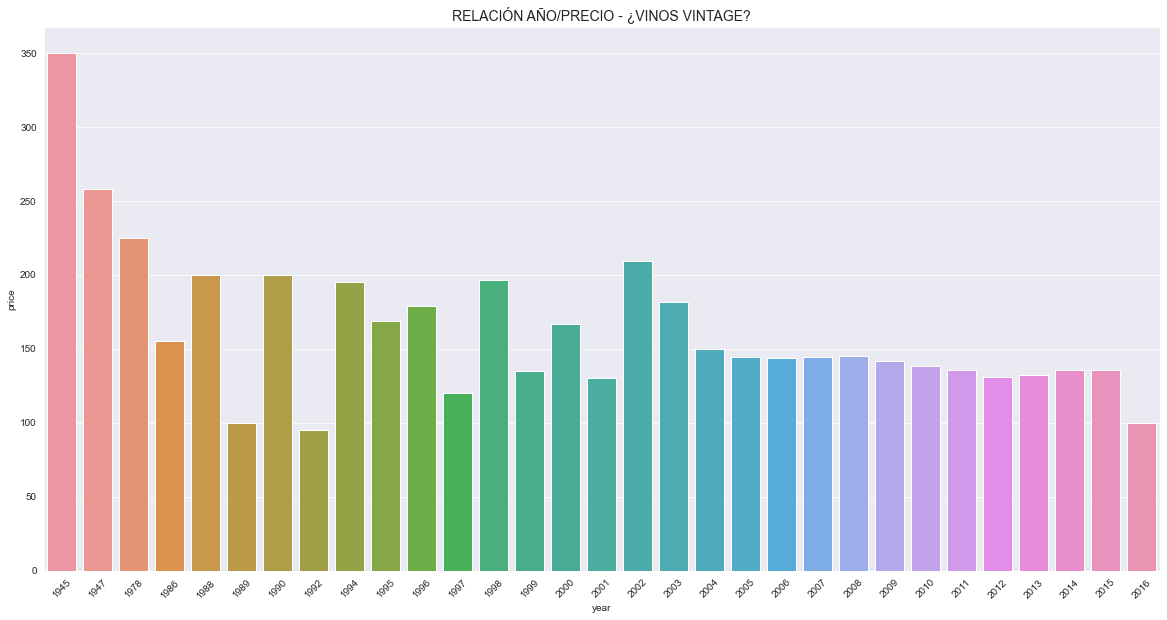

In [102]:
## vamos a graficarlo:

plt.figure(figsize=(20,10))

sns.barplot(x=year_price_outliers.index, y=year_price_outliers)
plt.xticks(rotation= 45)
############################################
### mirar como hacer mas grandes las etiquetas
############################################
plt.title("RELACIÓN AÑO/PRECIO - ¿VINOS VINTAGE?", fontsize=14);

In [103]:
## Con este gráfico puedo confirmar que la hipótesis de que los outliers de precio se correspondieran a los vinos "vintage", no tiene mucho sentido
## puesto que aquí tengo un buen rango de años, que llega hasta el 2016


## voy a ver qué más características tienen estos vinos, a ver si le saco alguna lógica
## por ejemplo voy a ver aquí abajo de qué Países son los precios outliers

In [104]:
precios_outliers_por_pais = df_outliers.groupby("country")["price"].mean().sort_values(ascending=True)
precios_outliers_por_pais

## NOTA: ni me molesto en sacar el gráfico, veo que todos los países de mi dataframe tienen de estos valores outlier de precios

country
Canada        99.000000
Argentina    119.155738
US           124.966777
Italy        137.379934
Spain        150.827731
France       150.967378
Australia    162.490909
Name: price, dtype: float64

In [105]:
## CONCLUSIÓN FINAL SOBRE LOS OUTLIERS DE LOS PRECIOS:
## como no le puedo encontrar ningún patrón para dejarlos para los modelos de ML, puedo confirmar con seguridad que me los quitaré del medio, ya que solo 
## me provocarían ruido, las predicciones terminarían influenciadas por ellos y no serían muy fiables


### 2 **MAPA**

In [106]:
df_limpio["country"].unique()

array(['US', 'Spain', 'Italy', 'France', 'Argentina', 'Australia',
       'Canada'], dtype=object)

In [107]:
country = df_limpio.groupby("country").size().reset_index(name="frecuencia").sort_values("frecuencia", ascending=False)
country

,country,frecuencia
6,US,23239
3,France,9408
4,Italy,6122
5,Spain,4330
0,Argentina,2580
1,Australia,1309
2,Canada,154


In [108]:
# mapa del mundo con la distribución de los vinos por Países (más oscuros, más frecuencia)
px.choropleth(country, locations = 'country', locationmode='country names', color = 'frecuencia', template = 'seaborn',range_color=[2000,15000], color_continuous_scale='redor', width= 1200, height=800)

## **PRUEBAS VARIAS PARA MODELOS DE MACHINE LEARNING** (primer bloque, llego a un RMSE de 21 y pico --> tengo que mejorar el modelo!!!)

Alguna variacion para etiquetar las columnas con sentido para el modelo de ML

#### VARIETY - pasar de string a numéricas
(hay 428 variedades distintas, las etiqueto por orden de frecuencia

In [109]:
df_limpio.head(2)

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year
0,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian,2013
1,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks,2012


In [110]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47142 entries, 0 to 47141
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      47142 non-null  object 
 1   description  47142 non-null  object 
 2   designation  47142 non-null  object 
 3   points       47142 non-null  int64  
 4   price        47142 non-null  float64
 5   province     47142 non-null  object 
 6   region_1     47142 non-null  object 
 7   taster_name  47142 non-null  object 
 8   variety      47142 non-null  object 
 9   winery       47142 non-null  object 
 10  year         47142 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 4.0+ MB


In [111]:
## voy a definir el dataframe que usaré para transformar las variables categóricas a numéricas
## descartaré la columna de la descripción, me quedo con el resto de variables categóricas

### "province", "region_1" de momento NO las incluyo, ya tengo country que las ingloba
clasificador_vinos = df_limpio[["country","designation", "taster_name","variety", "winery", "points", "year", "price"]]
clasificador_vinos

,country,designation,taster_name,variety,winery,points,year,price
0,US,Reserve Late Harvest,Alexander Peartree,Riesling,St. Julian,87,2013,13.0
1,US,Vintner's Reserve Wild Child Block,Paul Gregutt,Pinot Noir,Sweet Cheeks,87,2012,65.0
2,Spain,Ars In Vitro,Michael Schachner,Tempranillo-Merlot,Tandem,87,2011,15.0
3,Italy,Belsito,Kerin O’Keefe,Frappato,Terre di Giurfo,87,2013,16.0
4,France,Les Natures,Roger Voss,Pinot Gris,Jean-Baptiste Adam,87,2012,27.0
...,...,...,...,...,...,...,...,...
47137,France,Brand Grand Cru,Roger Voss,Pinot Gris,Cave de Turckheim,90,2010,57.0
47138,Italy,Sàgana Tenuta San Giacomo,Kerin O’Keefe,Nero d'Avola,Cusumano,90,2012,40.0
47139,France,Seppi Landmann Vallée Noble,Roger Voss,Pinot Gris,Domaine Rieflé-Landmann,90,2013,28.0
47140,France,Kritt,Roger Voss,Gewürztraminer,Domaine Gresser,90,2013,30.0


In [112]:
#### NOTA:
### tengo 428 variedades distintas de vinos, pero sé que de muchas solo hay 1 o 2 o pocos mas valores
### al principio iba a definir una cantidad de corte y quedarme solo con los que tenían mas de 40 unidades por variedad y el resto borrarlo del dataframe
### pero finalmente he cambiado de idea y me quedaré con todos, simplemente asignándole a cada uno un número de 0 a 427, por orden de frecuencia del mayor al menor

In [113]:
### algunos ejemplos:
## hay 96 con 1 unidad por variedad
## hay 151 con 2 unidades por variedad
## hay 187 con 3 unidades por variedad
## hay 206 con 4 unidades por variedad
## hay 225 con 5 unidades por variedad
## hay 233 con 6 unidades por variedad
## hay 275 con 10 unidades por variedad
## hay 350 con 40 unidades por variedad


## PRUEBAS VARIAS ##

# mas_de_100 = pd.DataFrame(df_limpio["variety"].value_counts() < 40)

# mas_de_100

# variedades_comunes = mas_de_100[mas_de_100["variety"] == True]
# variedades_comunes.head()

# variedades_comunes.value_counts()


In [114]:
### ordeno las variedades de uvas segun su frecuencia
## en base a esto le atribuiré un valor numérico para el modelo de ML
frecuencias_variedades =  df_limpio['variety'].value_counts().sort_values(ascending=False)
frecuencias_variedades

Pinot Noir                  6076
Chardonnay                  4329
Red Blend                   4248
Cabernet Sauvignon          2872
Bordeaux-style Red Blend    2044
                            ... 
Picapoll                       1
Syrah-Bonarda                  1
Tinta Madeira                  1
Centesimino                    1
Bobal-Cabernet Sauvignon       1
Name: variety, Length: 428, dtype: int64

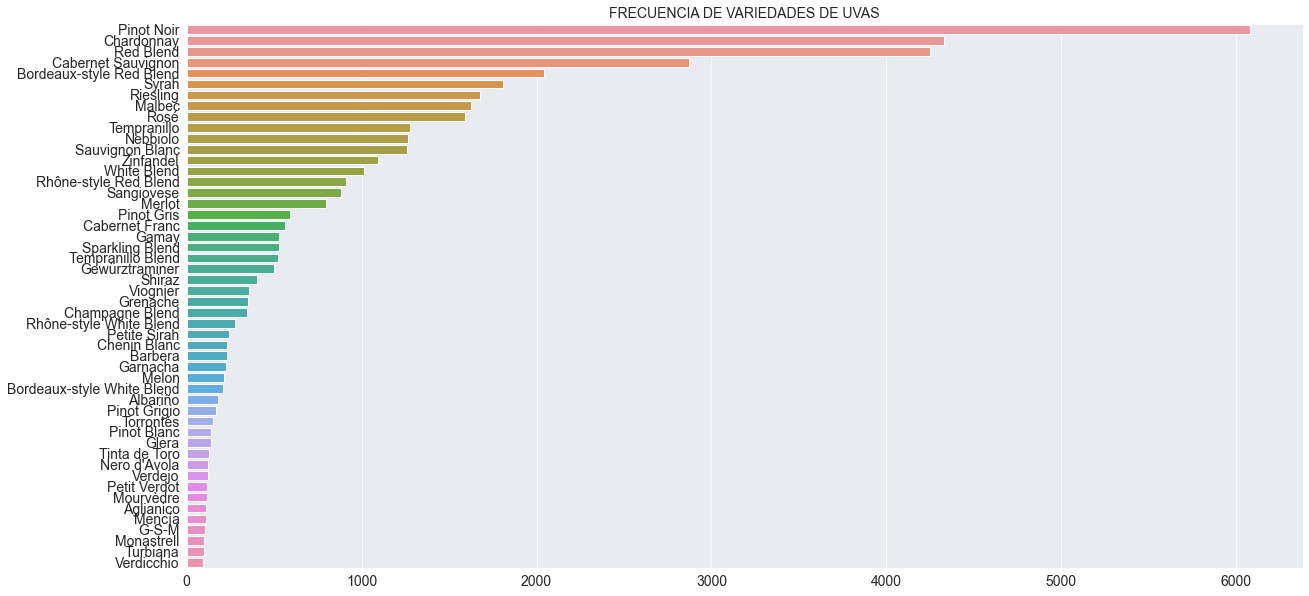

In [115]:
# grafico para ver las cantidades da variedades de uvas tenemos --> POR DEBAJO DE 100 LAS VOY A CATALOGAR COMO "OTHERS"
plt.figure(figsize=(20,10))
sns.barplot(y=frecuencias_variedades.index.values, x=frecuencias_variedades, order=frecuencias_variedades.iloc[:50].index)   ##  voy haciendo varias visualizaciones con el slicing para ver como es el grafico en su totalidad
plt.title("FRECUENCIA DE VARIEDADES DE UVAS", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [116]:
# creo un diccionario con las etiquetas de los vinos y sus respectivos números
# ordenados según la cantidad de cada vino
## en última posición está "others", que se refiere a los vinos de los cuales hay menos de 100 unidades cada uno
char2idx = {u:i for i, u in enumerate(frecuencias_variedades.index)}
print(char2idx)   ### para ver el diccionario que me ha creado

#### AHORA TENGO QUE PASARLOS A DATAFRAME, AL NUEVO DATAFRAME DE TODOS VALORES NUMERICOS
#### QUE USARÉ PARA LOS MODELOS DE MACHINE LEARNING

df_variety_num = pd.DataFrame([[key, char2idx[key]] for key in char2idx.keys()], columns=['variety', 'variety_num'])
df_variety_num.head()
df_variety_num.info()
df_variety_num

{'Pinot Noir': 0, 'Chardonnay': 1, 'Red Blend': 2, 'Cabernet Sauvignon': 3, 'Bordeaux-style Red Blend': 4, 'Syrah': 5, 'Riesling': 6, 'Malbec': 7, 'Rosé': 8, 'Tempranillo': 9, 'Nebbiolo': 10, 'Sauvignon Blanc': 11, 'Zinfandel': 12, 'White Blend': 13, 'Rhône-style Red Blend': 14, 'Sangiovese': 15, 'Merlot': 16, 'Pinot Gris': 17, 'Cabernet Franc': 18, 'Gamay': 19, 'Sparkling Blend': 20, 'Tempranillo Blend': 21, 'Gewürztraminer': 22, 'Shiraz': 23, 'Viognier': 24, 'Grenache': 25, 'Champagne Blend': 26, 'Rhône-style White Blend': 27, 'Petite Sirah': 28, 'Chenin Blanc': 29, 'Barbera': 30, 'Garnacha': 31, 'Melon': 32, 'Bordeaux-style White Blend': 33, 'Albariño': 34, 'Pinot Grigio': 35, 'Torrontés': 36, 'Pinot Blanc': 37, 'Glera': 38, 'Tinta de Toro': 39, "Nero d'Avola": 40, 'Verdejo': 41, 'Petit Verdot': 42, 'Mourvèdre': 43, 'Aglianico': 44, 'Mencía': 45, 'G-S-M': 46, 'Monastrell': 47, 'Turbiana': 48, 'Verdicchio': 49, 'Sauvignon': 50, 'Garganega': 51, 'Primitivo': 52, 'Vermentino': 53, 'Pin

,variety,variety_num
0,Pinot Noir,0
1,Chardonnay,1
2,Red Blend,2
3,Cabernet Sauvignon,3
4,Bordeaux-style Red Blend,4
...,...,...
423,Picapoll,423
424,Syrah-Bonarda,424
425,Tinta Madeira,425
426,Centesimino,426


In [117]:
## quiero mergear esta columna numerica correspondiente a las variedades del vino
df_limpio_num = pd.merge(clasificador_vinos, df_variety_num, how = "left")    ### con el "how=left" mantengo al columna "variety" del df de base clasificador_vinos
df_limpio_num
## ya que cada variedad tiene su numero asociado, aún haciendo el merge no necesito limpiar ningun dato más

,country,designation,taster_name,variety,winery,points,year,price,variety_num
0,US,Reserve Late Harvest,Alexander Peartree,Riesling,St. Julian,87,2013,13.0,6
1,US,Vintner's Reserve Wild Child Block,Paul Gregutt,Pinot Noir,Sweet Cheeks,87,2012,65.0,0
2,Spain,Ars In Vitro,Michael Schachner,Tempranillo-Merlot,Tandem,87,2011,15.0,207
3,Italy,Belsito,Kerin O’Keefe,Frappato,Terre di Giurfo,87,2013,16.0,142
4,France,Les Natures,Roger Voss,Pinot Gris,Jean-Baptiste Adam,87,2012,27.0,17
...,...,...,...,...,...,...,...,...,...
47137,France,Brand Grand Cru,Roger Voss,Pinot Gris,Cave de Turckheim,90,2010,57.0,17
47138,Italy,Sàgana Tenuta San Giacomo,Kerin O’Keefe,Nero d'Avola,Cusumano,90,2012,40.0,40
47139,France,Seppi Landmann Vallée Noble,Roger Voss,Pinot Gris,Domaine Rieflé-Landmann,90,2013,28.0,17
47140,France,Kritt,Roger Voss,Gewürztraminer,Domaine Gresser,90,2013,30.0,22


In [118]:
# por si acaso hago otro info para ver si tengo algun NaN o cosas raras después del merge
df_limpio_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47142 entries, 0 to 47141
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      47142 non-null  object 
 1   designation  47142 non-null  object 
 2   taster_name  47142 non-null  object 
 3   variety      47142 non-null  object 
 4   winery       47142 non-null  object 
 5   points       47142 non-null  int64  
 6   year         47142 non-null  int64  
 7   price        47142 non-null  float64
 8   variety_num  47142 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.6+ MB


In [119]:
### alguna prueba aquí en el notebook para ver que le haya asignado bien los números a cada vino (voy cambiando el nombre y veo que le corresponda su numero) --> OK, lo ha hecho bien
## dejo esta variedad como prueba pero podría dejar cualquiera ya que he comprobado que funciona y tambien los fillna

df_limpio_num[df_limpio_num["variety"] == "Nero d'Avola"][["winery","designation","variety","variety_num"]].head()

## veo que de las variedades, no siempre tiene por que haber la misma designación ni la misma bodega(winery)

,winery,designation,variety,variety_num
12,Canicattì,Aynat,Nero d'Avola,40
382,Brennan,Super Nero,Nero d'Avola,40
429,Baglio di Pianetto,Cembali,Nero d'Avola,40
432,Casa di Grazia,Gradiva Collectio,Nero d'Avola,40
444,Viticultori Associati Canicatti,Aquilae,Nero d'Avola,40


#### Alguna consideración sobre QUÉ columnas usar para el modelo y por lo tanto pasarlas a NUMÉRICAS

In [120]:
## alguna consideración sobre qué columnas usar para mi modelo y cómo transformarlas de categóricas a numéricas
df_limpio_num.describe(include="all")

## "variety": ya lo he hecho, he asignado números según la frecuencia de cada variedad
## "designation": tengo más de 22000 valores únicos, los podría pasar a número pero están tan sumamente conectados a "variety" que tendria seguramente "colinearidad"
                ### de hecho mi idea era asignarle el mismo número a cada tipo de "designation" según de qué variedad de vino era. Claramente el resultado hubiera sido una columna con los mismos numeros que
                ### la de "variety_num", de allí que no tuviera mucho sentido dejarla para la predicción -> LA QUITARÉ DEL DF
## "winery": tengo más de 8000 valores únicos. Mismas consideraciones que con "designation" -> LA QUITARÉ DEL DF
## "country" solo hay 7 valores únicos, les asignaré valores del 0 al 6 siguiendo el orden de frecuencia
## "taster_name" hay 17 únicos, no son pocos pero tampoco una barbaridad, para ello utilizaré el get_dummies

,country,designation,taster_name,variety,winery,points,year,price,variety_num
count,47142,47142,47142,47142,47142,47142.000000,47142.000000,47142.000000,47142.000000
unique,7,22726,17,428,8290,NaN,NaN,NaN,NaN
top,US,Reserve,Roger Voss,Pinot Noir,Columbia Crest,NaN,NaN,NaN,NaN
freq,23239,1062,7433,6076,144,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,89.023185,2011.477154,39.572589,18.540601
std,NaN,NaN,NaN,NaN,NaN,3.013534,3.346880,35.809319,38.169339
min,NaN,NaN,NaN,NaN,NaN,80.000000,1904.000000,4.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,87.000000,2010.000000,20.000000,2.000000
50%,NaN,NaN,NaN,NaN,NaN,89.000000,2012.000000,30.000000,7.000000
75%,NaN,NaN,NaN,NaN,NaN,91.000000,2014.000000,49.000000,18.000000


#### COUNTRY -  - pasar de string a numéricas - (renombro yo según frecuencia, del 0 al 6)

In [121]:
## recordamos cuál era la frecuencia de los countries:
country

,country,frecuencia
6,US,23239
3,France,9408
4,Italy,6122
5,Spain,4330
0,Argentina,2580
1,Australia,1309
2,Canada,154


In [122]:
## defino una función para renombrar
#### esto al final NO lo voy a usar, ya que en el ultimo notebook le aplicaré un get_dummies
#### por lo tanto NO VOY A INCLUIR ESTA FUNCIÓN EN EL ARCHIVO funciones.py

def cambios(x):
    for pos,val in str_to_num.items():
        if x==pos:
            x=val
            return x
    return x

In [123]:
##ordenados por frecuencia, asigno a cada country su número
str_to_num = { "US":0, "France":1, "Italy":2, "Spain":3, "Argentina":4, "Australia":5, "Canada":6}
df_limpio_num["country_num"] = df_limpio_num["country"].apply(cambios)

In [124]:
df_limpio_num
## ok, funciona

,country,designation,taster_name,variety,winery,points,year,price,variety_num,country_num
0,US,Reserve Late Harvest,Alexander Peartree,Riesling,St. Julian,87,2013,13.0,6,0
1,US,Vintner's Reserve Wild Child Block,Paul Gregutt,Pinot Noir,Sweet Cheeks,87,2012,65.0,0,0
2,Spain,Ars In Vitro,Michael Schachner,Tempranillo-Merlot,Tandem,87,2011,15.0,207,3
3,Italy,Belsito,Kerin O’Keefe,Frappato,Terre di Giurfo,87,2013,16.0,142,2
4,France,Les Natures,Roger Voss,Pinot Gris,Jean-Baptiste Adam,87,2012,27.0,17,1
...,...,...,...,...,...,...,...,...,...,...
47137,France,Brand Grand Cru,Roger Voss,Pinot Gris,Cave de Turckheim,90,2010,57.0,17,1
47138,Italy,Sàgana Tenuta San Giacomo,Kerin O’Keefe,Nero d'Avola,Cusumano,90,2012,40.0,40,2
47139,France,Seppi Landmann Vallée Noble,Roger Voss,Pinot Gris,Domaine Rieflé-Landmann,90,2013,28.0,17,1
47140,France,Kritt,Roger Voss,Gewürztraminer,Domaine Gresser,90,2013,30.0,22,1


#### TASTER_NAME -  pasar de string a numéricas - (get_dummies --> 17 valores únicos, 17 nuevas columnas)

In [125]:
df_limpio_num = pd.get_dummies(data = df_limpio_num, columns = ["taster_name"], drop_first=False)

In [126]:
df_limpio_num.head()
## ok, funciona. Y la columna original "taster_name" ya me la ha quitado automáticamente el "get_dummies"

,country,designation,variety,winery,points,year,price,variety_num,country_num,taster_name_Alexander Peartree,...,taster_name_Joe Czerwinski,taster_name_Kerin O’Keefe,taster_name_Lauren Buzzeo,taster_name_Matt Kettmann,taster_name_Michael Schachner,taster_name_Paul Gregutt,taster_name_Roger Voss,taster_name_Sean P. Sullivan,taster_name_Susan Kostrzewa,taster_name_Virginie Boone
0,US,Reserve Late Harvest,Riesling,St. Julian,87,2013,13.0,6,0,1,...,0,0,0,0,0,0,0,0,0,0
1,US,Vintner's Reserve Wild Child Block,Pinot Noir,Sweet Cheeks,87,2012,65.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Spain,Ars In Vitro,Tempranillo-Merlot,Tandem,87,2011,15.0,207,3,0,...,0,0,0,0,1,0,0,0,0,0
3,Italy,Belsito,Frappato,Terre di Giurfo,87,2013,16.0,142,2,0,...,0,1,0,0,0,0,0,0,0,0
4,France,Les Natures,Pinot Gris,Jean-Baptiste Adam,87,2012,27.0,17,1,0,...,0,0,0,0,0,0,1,0,0,0


#### DROP COLUMNAS QUE FINALMENTE NO USARÉ PARA EL MODELO Y LIMPIEZA COLUMNAS "DOBLES" (de las que ahora tengo como numéricas, borraré sus correspondientes categóricas)

In [127]:
df_limpio_num.drop(["country", "designation", "variety", "winery"], inplace=True, axis = 1)

In [128]:
df_limpio_num

,points,year,price,variety_num,country_num,taster_name_Alexander Peartree,taster_name_Anna Lee C. Iijima,taster_name_Anne Krebiehl MW,taster_name_Carrie Dykes,taster_name_Christina Pickard,...,taster_name_Joe Czerwinski,taster_name_Kerin O’Keefe,taster_name_Lauren Buzzeo,taster_name_Matt Kettmann,taster_name_Michael Schachner,taster_name_Paul Gregutt,taster_name_Roger Voss,taster_name_Sean P. Sullivan,taster_name_Susan Kostrzewa,taster_name_Virginie Boone
0,87,2013,13.0,6,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,87,2012,65.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,87,2011,15.0,207,3,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,87,2013,16.0,142,2,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,87,2012,27.0,17,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47137,90,2010,57.0,17,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
47138,90,2012,40.0,40,2,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
47139,90,2013,28.0,17,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
47140,90,2013,30.0,22,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### MATRIZ DE CORRELACION DEL NUEVO DATAFRAME NUMÉRICO

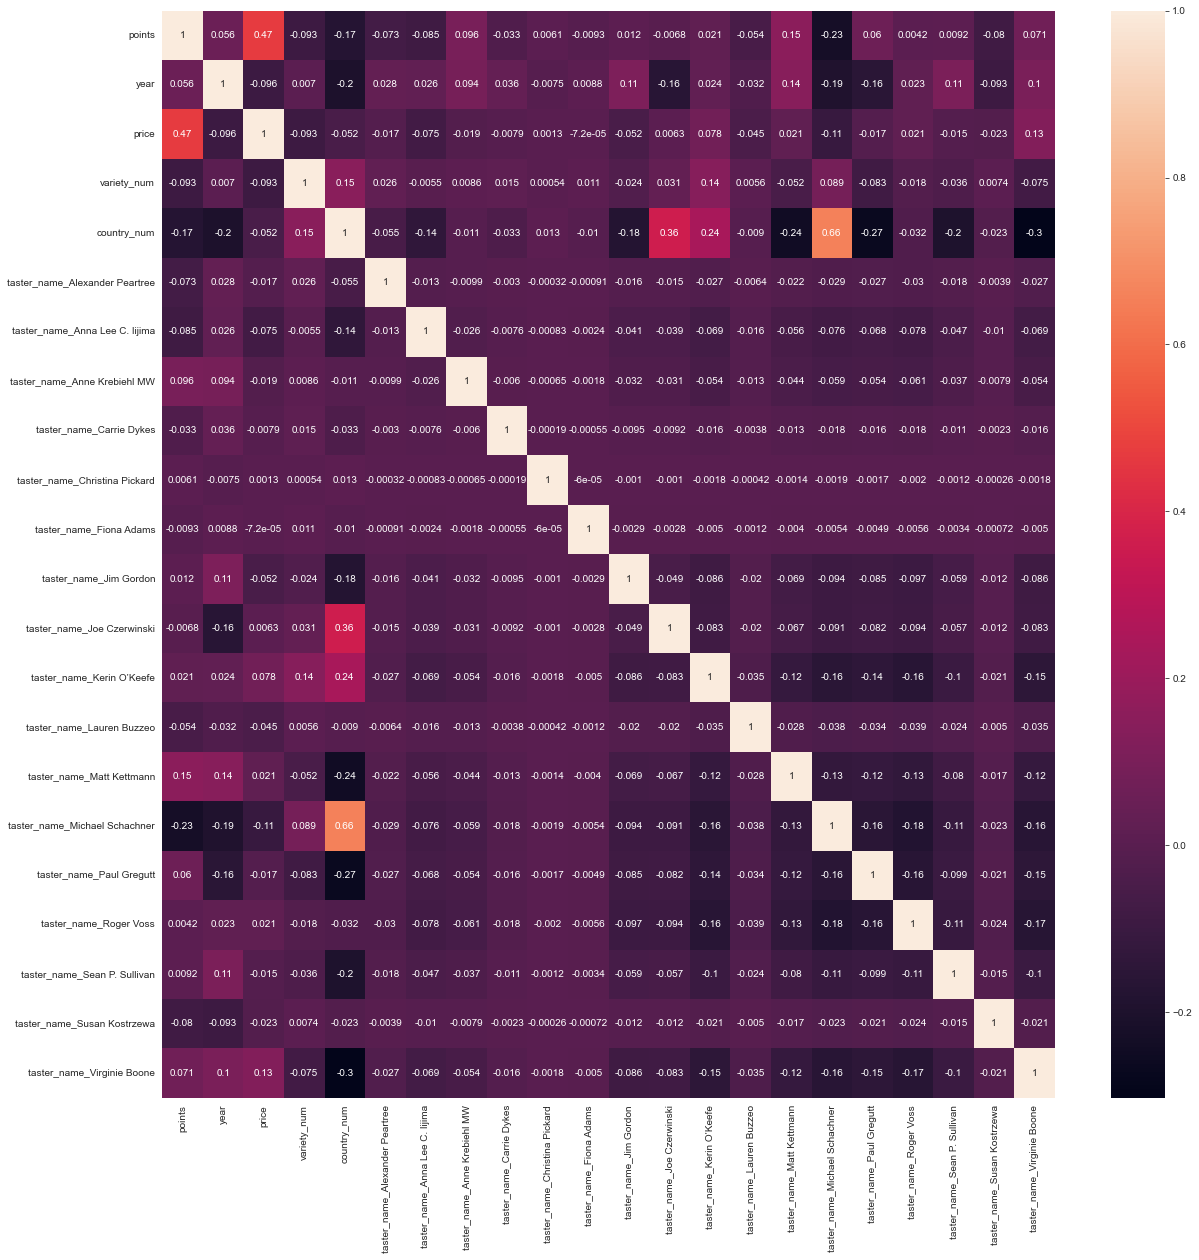

In [134]:
plt.figure(figsize= (20,20))
sns.heatmap(df_limpio_num.corr(), annot=True);

## en realidad veo que el año no correla mucho con nada (¿y si lo quitara del modelo de ML?)
## hay una correlacion relativamente alta (0.66) entre "country_num" y "taster_name_Michael_Schachner" --> no creo que signifique nada, o sea si finalmente decido quitar los catadores, los quito o todos o ninguno
## veo alguna que otra corerlación entre algun otro catador y country, pero por debajo de 0.5, ni los nombro aquí en la nota
## sorprendentemente veo que las variedades de uva no correlan ni con price ni con point(pensaba que algun tipo de uva sería considerado más "exclusivo" y por lo tanto más caro, pero parece que no)
## hay una ligerísima correlación entre country y variedad de uvas, pero es un 0.23 (es algo más respecto al conjunto de la matriz, pero en sí es un valor demasiado bajo como para considerarlo correlación)

## la única correlación algo clara es entre precio y puntuación (como ya me había imaginado y había podido corroborar durante el EDA). Al tener aún los outliers no es tan fuerte (0.47)
## pero luego los quitaré y miraré qué correlación hay sin ellos

### VARIAS PRUEBAS REGESIÓN LINEAL CON OUTLIERS - RESULTADOS PÉSIMOS - NO LA INCLUIRÉ EN EL CONJUNTO DEL TRABAJO, LA DEJARÉ AQUÍ PARA QUE SE VEAN LAS PRUEBAS QUE HE HECHO
Me daba, en el mejor de los casos, un RMSE de 34 y pico

#### 1º MODELO - REGRESIÓN LINEAL - **CON** OUTLIERS Y TODAS LAS COLUMNAS

In [135]:
## voy a probar una regresión lineal conservando outliers y todas las columnas
## ya sé que no va a salir algo bueno, pero es para tener un primer valor de referencia
## de hehco sé que estos outliers no son errores, sino que simplemente hay ciertos vinos que son extremadamente caros
## lo que quiero ver es cómo varían las predicciones (o más bien el score) CON o SIN ellos, así que haré ambas pruebas

In [136]:
## defino "X" e "y"
X = df_limpio_num.drop(["price"], axis = 1)
y = np.array(df_limpio_num["price"]).reshape(-1,1)

In [137]:
print(type(X))
print(type(y))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [135]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [138]:
### escalo los valores (por comodidad, antes escalo toda la X y luego ya la separo en train y test)

stdscal = StandardScaler()
stdscal.fit(X)
X_std = stdscal.transform(X)

In [139]:
## separo en train y test
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.2, random_state=12)

In [140]:
## compruebo las divisiones:
print("Total features shape:", X_std.shape)
print("Train features shape:", X_train.shape)
print("Train target shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test target shape:", y_test.shape)

Total features shape: (47142, 21)
Train features shape: (37713, 21)
Train target shape: (37713, 1)
Test features shape: (9429, 21)
Test target shape: (9429, 1)


In [141]:
from sklearn.linear_model import LinearRegression

## defino el modelo
lin_reg = LinearRegression()

## lo entreno
lin_reg.fit(X_train, y_train)

## hago la predicción
prediccion = lin_reg.predict(X_test)
prediccion

array([[39.71118164],
       [33.31469727],
       [-0.30834961],
       ...,
       [17.50219727],
       [22.95141602],
       [29.81665039]])

In [142]:
# Metricas de regresión
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# print('MAE:', mean_absolute_error(y_test, prediccion))
# print('MSE:', mean_squared_error(y_test, prediccion))
# print('RMSE:', np.sqrt(mean_squared_error(y_test, prediccion)))


print("Score del modelo (R^2):", round(lin_reg.score(X_std, y), 4))
print("R^2 score:", round(r2_score(prediccion, y_test), 4))
print("MAE score:", round(mean_absolute_error(prediccion, y_test), 4))
print("MSE score:", round(mean_squared_error(prediccion, y_test), 4))
print("RMSE score:", round(np.sqrt(mean_squared_error(prediccion, y_test)), 4))

def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("MAPE score:", round(mean_absolute_percentage_error(prediccion, y_test), 4))

## no me parecen valores para nada buenos, voy a quitar el "ruido" poco a poco aquí abajo (de hecho son FATALES)

Score del modelo (R^2): -1.7210181146485273e+25
R^2 score: -0.0001
MAE score: 3420759544825.4263
MSE score: 1.103343473959365e+29
RMSE score: 332166144265089.9
MAPE score: 6841519089668.907


#### 2º MODELO - REGRESIÓN LINEAL - **CON** OUTLIERS - QUITO TASTER_NAMES (17 columnas)

In [143]:
## defino "X" e "y"
X2 = df_limpio_num[["points", "year", "variety_num", "country_num"]]
y2 = np.array(df_limpio_num["price"]).reshape(-1,1)

### escalo los valores (por comodidad, antes escalo toda la X y luego ya la separo en train y test)
stdscal = StandardScaler()
stdscal.fit(X2)
X2_std = stdscal.transform(X2)

## separo en train y test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_std, y2, test_size = 0.2, random_state=12)

In [144]:
## compruebo las divisiones:
print("Total features shape:", X2_std.shape)
print("Train features shape:", X2_train.shape)
print("Train target shape:", y2_train.shape)
print("Test features shape:", X2_test.shape)
print("Test target shape:", y2_test.shape)

Total features shape: (47142, 4)
Train features shape: (37713, 4)
Train target shape: (37713, 1)
Test features shape: (9429, 4)
Test target shape: (9429, 1)


In [145]:
## defino el modelo
lin_reg2 = LinearRegression()

## lo entreno
lin_reg2.fit(X2_train, y2_train)

## hago la predicción
prediccion2 = lin_reg2.predict(X2_test)
prediccion2

array([[29.55527424],
       [41.7976692 ],
       [-1.5409877 ],
       ...,
       [24.19742033],
       [29.69301508],
       [20.1731395 ]])

In [146]:
# Metricas de regresión
# print('MAE:', mean_absolute_error(y2_test, prediccion2))
# print('MSE:', mean_squared_error(y2_test, prediccion2))
# print('RMSE:', np.sqrt(mean_squared_error(y2_test, prediccion2)))

print("Score del modelo (R^2):", round(lin_reg2.score(X2_std, y2), 4))
print("R^2 score:", round(r2_score(prediccion2, y2_test), 4))
print("MAE score:", round(mean_absolute_error(prediccion2, y2_test), 4))
print("MSE score:", round(mean_squared_error(prediccion2, y2_test), 4))
print("RMSE score:", round(np.sqrt(mean_squared_error(prediccion2, y2_test)), 4))

def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("MAPE score:", round(mean_absolute_percentage_error(prediccion2, y2_test), 4))

## esto ya es algo mejor respecto al anterior, pero quiero quitar más ruido aún y probar, aquí abajo, a quitar tambien la columna "country_num"
### SCORE NEGATIVO???????

Score del modelo (R^2): 0.2364
R^2 score: -3.0322
MAE score: 17.9924
MSE score: 1205.2485
RMSE score: 34.7167
MAPE score: 54.2948


#### 3º MODELO - REGRESIÓN LINEAL - **CON** OUTLIERS - QUITO TAMBIÉN COUNTRY_NUM

In [147]:
## defino "X" e "y"
X3 = df_limpio_num[["points", "year", "variety_num"]]
y3 = np.array(df_limpio_num["price"]).reshape(-1,1)

### escalo los valores (por comodidad, antes escalo toda la X y luego ya la separo en train y test)
stdscal = StandardScaler()
stdscal.fit(X3)
X3_std = stdscal.transform(X3)

## separo en train y test
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_std, y3, test_size = 0.2, random_state=12)

In [148]:
## compruebo las divisiones:
print("Total features shape:", X3_std.shape)
print("Train features shape:", X3_train.shape)
print("Train target shape:", y3_train.shape)
print("Test features shape:", X3_test.shape)
print("Test target shape:", y3_test.shape)

Total features shape: (47142, 3)
Train features shape: (37713, 3)
Train target shape: (37713, 1)
Test features shape: (9429, 3)
Test target shape: (9429, 1)


In [149]:
## defino el modelo
lin_reg3 = LinearRegression()

## lo entreno
lin_reg3.fit(X3_train, y3_train)

## hago la predicción
prediccion3 = lin_reg3.predict(X3_test)
prediccion3

array([[29.82245488],
       [41.96714639],
       [-1.47076423],
       ...,
       [24.39537863],
       [29.87509529],
       [20.40125671]])

In [150]:
# Metricas de regresión
# print('MAE:', mean_absolute_error(y3_test, prediccion3))
# print('MSE:', mean_squared_error(y3_test, prediccion3))
# print('RMSE:', np.sqrt(mean_squared_error(y3_test, prediccion3)))


print("Score del modelo (R^2):", round(lin_reg3.score(X3_std, y3), 4))
print("R^2 score:", round(r2_score(prediccion3, y3_test), 4))
print("MAE score:", round(mean_absolute_error(prediccion3, y3_test), 4))
print("MSE score:", round(mean_squared_error(prediccion3, y3_test), 4))
print("RMSE score:", round(np.sqrt(mean_squared_error(prediccion3, y3_test)), 4))

def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("MAPE score:", round(mean_absolute_percentage_error(prediccion3, y3_test), 4))

## pensaba que mejoraría pero ha empeorado un poquito (muy poco) respecto a la versión anterior. Ahora quiero quedarme solo con price y points, a ver qué tal
##### R2 SCORE NEGATIVO??????????

Score del modelo (R^2): 0.2363
R^2 score: -3.0367
MAE score: 17.9768
MSE score: 1205.7537
RMSE score: 34.724
MAPE score: 54.1999


#### 4º MODELO - REGRESIÓN LINEAL - **CON** OUTLIERS Y SOLO LAS COLUMNAS "points" Y "price"

In [151]:
## defino "X" e "y"
X4 = np.array(df_limpio_num["points"]).reshape(-1,1)
y4 = np.array(df_limpio_num["price"]).reshape(-1,1)

### escalo los valores (por comodidad, antes escalo toda la X y luego ya la separo en train y test)
stdscal = StandardScaler()
stdscal.fit(X4)
X4_std = stdscal.transform(X4)

## separo en train y test
X4_train, X4_test, y4_train, y4_test = train_test_split(X4_std, y4, test_size = 0.2, random_state=12)

In [152]:
## compruebo las divisiones:
print("Total features shape:", X4_std.shape)
print("Train features shape:", X4_train.shape)
print("Train target shape:", y4_train.shape)
print("Test features shape:", X4_test.shape)
print("Test target shape:", y4_test.shape)

Total features shape: (47142, 1)
Train features shape: (37713, 1)
Train target shape: (37713, 1)
Test features shape: (9429, 1)
Test target shape: (9429, 1)


In [153]:
## defino el modelo
lin_reg4 = LinearRegression()

## lo entreno
lin_reg4.fit(X4_train, y4_train)

## hago la predicción
prediccion4 = lin_reg4.predict(X4_test)
prediccion4

array([[28.41347532],
       [33.86897514],
       [ 1.13597621],
       ...,
       [28.41347532],
       [33.86897514],
       [22.9579755 ]])

In [154]:
# Metricas de regresión
# print('MAE:', mean_absolute_error(y4_test, prediccion4))
# print('MSE:', mean_squared_error(y4_test, prediccion4))
# print('RMSE:', np.sqrt(mean_squared_error(y4_test, prediccion4)))

print("Score del modelo (R^2):", round(lin_reg4.score(X4_std, y4), 4))
print("R^2 score:", round(r2_score(prediccion4, y4_test), 4))
print("MAE score:", round(mean_absolute_error(prediccion4, y4_test), 4))
print("MSE score:", round(mean_squared_error(prediccion4, y4_test), 4))
print("RMSE score:", round(np.sqrt(mean_squared_error(prediccion4, y4_test)), 4))

def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("MAPE score:", round(mean_absolute_percentage_error(prediccion4, y4_test), 4))

## peor aún. De momento los mejores métricas las tengo con la opción 2
## ahora lo repetiré todo aquí abajo pero antes quitando los outliers de los precios

Score del modelo (R^2): 0.2189
R^2 score: -3.5095
MAE score: 18.1978
MSE score: 1232.4594
RMSE score: 35.1064
MAPE score: 54.6004


#### RESUMEN 1º BLOQUE MODELOS - REGRESIÓN LINEAL - **CON** OUTLIERS

In [155]:
#### podría hacer una tabla con los scores por cada modelo
models = ["lin_reg1", "lin_reg2", "lin_reg3", "lin_reg4"]

dict_values = {"R^2 score": [round(r2_score(prediccion, y_test), 4), 
                        round(r2_score(prediccion2, y2_test), 4),
                        round(r2_score(prediccion3, y3_test), 4),
                        round(r2_score(prediccion4, y4_test), 4)],
               "MAE": [round(mean_absolute_error(prediccion, y_test), 4), 
                        round(mean_absolute_error(prediccion2, y2_test), 4),
                        round(mean_absolute_error(prediccion3, y3_test), 4),
                        round(mean_absolute_error(prediccion4, y4_test), 4)],
               "MSE": [round(mean_squared_error(prediccion, y_test), 4), 
                        round(mean_squared_error(prediccion2, y2_test), 4),
                        round(mean_squared_error(prediccion3, y3_test), 4),
                        round(mean_squared_error(prediccion4, y4_test), 4)],
               "RMSE": [round(np.sqrt(mean_squared_error(prediccion, y_test)), 4), 
                        round(np.sqrt(mean_squared_error(prediccion2, y2_test)), 4),
                        round(np.sqrt(mean_squared_error(prediccion3, y3_test)), 4),
                        round(np.sqrt(mean_squared_error(prediccion4, y4_test)), 4)],
               "MAPE": [round(mean_absolute_percentage_error(prediccion, y_test), 4), 
                        round(mean_absolute_percentage_error(prediccion2, y2_test), 4),
                        round(mean_absolute_percentage_error(prediccion3, y3_test), 4),
                        round(mean_absolute_percentage_error(prediccion4, y4_test), 4)] 
               }

df_score = pd.DataFrame(dict_values, index = models, columns = ["R^2 score", "MAE", "MSE", "RMSE", "MAPE"])
df_score
######### En general los valores son muy malos, no incluiré este modelo en la memoria final, éste tiene todos los outliers. Ha sido una primera prueba para ver cómo iba la cosa

,R^2 score,MAE,MSE,RMSE,MAPE
lin_reg1,-0.0001,3.420760e+12,1.103343e+29,3.321661e+14,6.841519e+12
lin_reg2,-3.0322,1.799240e+01,1.205248e+03,3.471670e+01,5.429480e+01
lin_reg3,-3.0367,1.797680e+01,1.205754e+03,3.472400e+01,5.419990e+01
lin_reg4,-3.5095,1.819780e+01,1.232459e+03,3.510640e+01,5.460040e+01


### **QUITO** OUTLIERS de la columna "price" y a partir de este dataframe montaré mis varios modelos de ML

In [129]:
from scipy.stats import iqr

def outliers_quantie(df_limpio_num, feature, param=1.5):  
        
    iqr_ = iqr(df_limpio_num[feature], nan_policy='omit')
    q1 = np.nanpercentile(df_limpio_num[feature], 25)
    q3 = np.nanpercentile(df_limpio_num[feature], 75)
    
    th1 = q1 - iqr_*param
    th2 = q3 + iqr_*param
    
    return df_limpio_num[(df_limpio_num[feature] >= th1) & (df_limpio_num[feature] <= th2)].reset_index(drop=True)

df_limpio_num_no_out = outliers_quantie(df_limpio_num, 'price', 7)  #### este parametro 7 hace que no me quitara todos los outliers, por defecto es 1.5
print("Len original:", len(df_limpio_num))
print("Len sin outliers en price:", len(df_limpio_num_no_out))


Len original: 47142
Len sin outliers en price: 46989


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



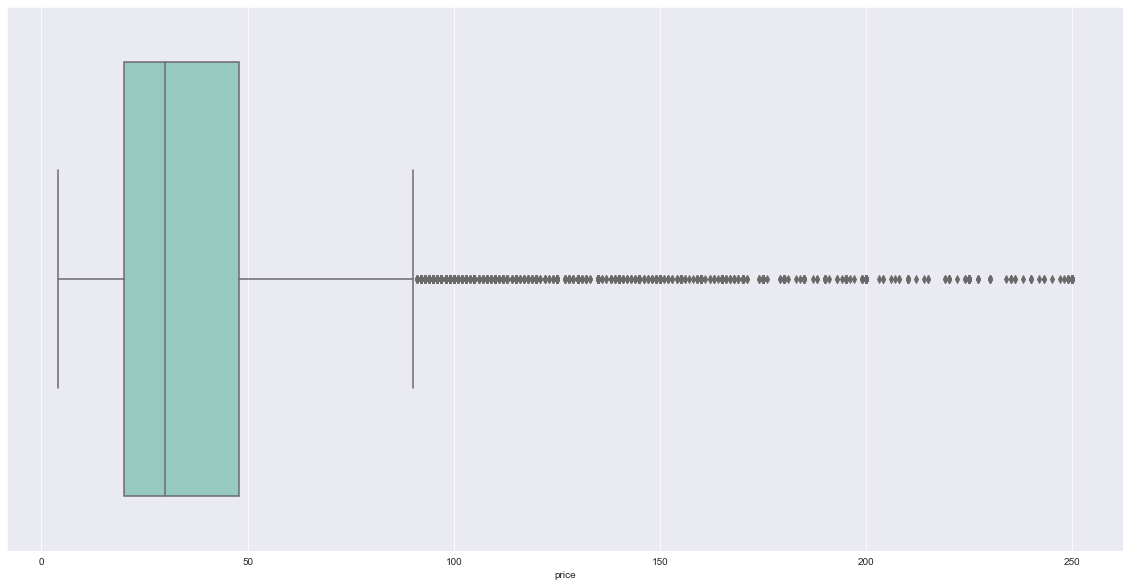

In [130]:
## compruebo boxplot para ver si efectivamente me ha eliminado los outliers:
plt.figure(figsize=(20,10))
sns.boxplot(df_limpio_num_no_out["price"]);
plt.xticks(np.arange(0,300, 50));

### según este diagrama de caja vero que siguen estando algunos, pero me parece que se pueden quedar (segun la linea del diagrama tendrian que ser a partir de 90$ para arriba, mientras que
# aquí veo que me ha quitado los de 250$ para arriba, pero me parece algo mas realista que quitar desde 90$, ademas que esto se supone que se ha hecho con la fórmula del rango itnercuantílico)

In [131]:
### guardo el df sin outlier
df_limpio_num_no_out.to_csv("..\data\\processed\\df_limpio_num_no_out.csv", index=False)  ## todos los csv que cree los guardo en la carpeta "processed"

### REGRESIÓN LINEAL - VARIOS MODELOS
el mejor RMSE de las regresiones lineales es de 23.7588  (NO me quedo con este valor, HAY QUE SEGUIR MEJORÁNDOLO)

#### 1º MODELO - REGRESIÓN LINEAL - **SIN** OUTLIERS Y TODAS LAS COLUMNAS

In [132]:
## defino "X" e "y"  --->> "so" estaría por "sin outlier", para no hacerlo demasiado largo
X_so = df_limpio_num_no_out.drop(["price"], axis = 1)
y_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,1)

In [133]:

### escalo los valores (por comodidad, antes escalo toda la X y luego ya la separo en train y test)
## en una primera prueba los escalé ANTES de hacer el train test split. Ahora dejaré el scaler para después

# stdscal = StandardScaler()
# stdscal.fit(X_so)
# X_so_std = stdscal.transform(X_so)

In [137]:
## separo en train y test
X_so_train, X_so_test, y_so_train, y_so_test = train_test_split(X_so, y_so, test_size = 0.2, random_state=12)

In [138]:
## compruebo las divisiones:
print("Total features shape:", X_so.shape)
print("Train features shape:", X_so_train.shape)
print("Train target shape:", y_so_train.shape)
print("Test features shape:", X_so_test.shape)
print("Test target shape:", y_so_test.shape)

Total features shape: (46989, 21)
Train features shape: (37591, 21)
Train target shape: (37591, 1)
Test features shape: (9398, 21)
Test target shape: (9398, 1)


In [142]:
## defino el modelo
lin_reg_so = LinearRegression()

# Creo el scaler con los datos de train
scal = StandardScaler() # Declaro el scaler
scal.fit(X_so_train) # Lo "entreno". Calculo su media y std para cada feature
X_so_train = scal.transform(X_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X_so_test = scal.transform(X_so_test)

## lo entreno
lin_reg_so.fit(X_so_train, y_so_train)

## hago la predicción
prediccion_so = lin_reg_so.predict(X_so_test)
prediccion_so

array([[41.33689292],
       [16.50095542],
       [25.51462729],
       ...,
       [25.98923667],
       [56.10788901],
       [46.50095542]])

In [143]:
# Metricas de regresión  --->> compruebo las métricas en los datos de test
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


print("Score del modelo (R^2):", round(lin_reg_so.score(X_so_test, y_so_test), 4))  
print("R^2 score:", round(r2_score(y_so_test, prediccion_so), 4))
print("MAE score:", round(mean_absolute_error(y_so_test, prediccion_so), 4))
print("MSE score:", round(mean_squared_error(y_so_test, prediccion_so), 4))
print("RMSE score:", round(np.sqrt(mean_squared_error(y_so_test, prediccion_so)), 4))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("MAPE score:", round(mean_absolute_percentage_error(y_so_test, prediccion_so), 4))

Score del modelo (R^2): 0.3235
R^2 score: 0.3235
MAE score: 15.7668
MSE score: 564.4828
RMSE score: 23.7588
MAPE score: 50.7795


#### 2º MODELO - REGRESIÓN LINEAL - **SIN** OUTLIERS - QUITO TASTER_NAMES (17 columnas)

In [144]:
## defino "X" e "y"
X2_so = df_limpio_num_no_out[["points", "year", "variety_num", "country_num"]]
y2_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,1)

## separo en train y test
X2_so_train, X2_so_test, y2_so_train, y2_so_test = train_test_split(X2_so, y2_so, test_size = 0.2, random_state=12)

In [145]:
## compruebo las divisiones:
print("Total features shape:", X2_so.shape)
print("Train features shape:", X2_so_train.shape)
print("Train target shape:", y2_so_train.shape)
print("Test features shape:", X2_so_test.shape)
print("Test target shape:", y2_so_test.shape)

Total features shape: (46989, 4)
Train features shape: (37591, 4)
Train target shape: (37591, 1)
Test features shape: (9398, 4)
Test target shape: (9398, 1)


In [146]:
## defino el modelo
lin_reg2_so = LinearRegression()

# Creo el scaler con los datos de train
scal = StandardScaler() # Declaro el scaler
scal.fit(X2_so_train) # Lo "entreno". Calculo su media y std para cada feature
X2_so_train = scal.transform(X2_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X2_so_test = scal.transform(X2_so_test)

## lo entreno
lin_reg2_so.fit(X2_so_train, y2_so_train)

## hago la predicción
prediccion2_so = lin_reg2_so.predict(X2_so_test)
prediccion2_so

array([[43.81701637],
       [26.23458898],
       [28.01064906],
       ...,
       [26.51092588],
       [46.56690221],
       [46.27454361]])

In [147]:
# Metricas de regresión

print("Score del modelo (R^2):", round(lin_reg2_so.score(X2_so_test, y2_so_test), 4))  
print("R^2 score:", round(r2_score(y2_so_test, prediccion2_so), 4))
print("MAE score:", round(mean_absolute_error(y2_so_test, prediccion2_so), 4))
print("MSE score:", round(mean_squared_error(y2_so_test, prediccion2_so), 4))
print("RMSE score:", round(np.sqrt(mean_squared_error(y2_so_test, prediccion2_so)), 4))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("MAPE score:", round(mean_absolute_percentage_error(y2_so_test, prediccion2_so), 4))

## score un poco peor pero RMSE y MAPE algo mejor que el anterior modelo

Score del modelo (R^2): 0.2855
R^2 score: 0.2855
MAE score: 16.1666
MSE score: 596.1389
RMSE score: 24.416
MAPE score: 52.2299


#### 3º MODELO - REGRESIÓN LINEAL - **SIN** OUTLIERS - QUITO TAMBIÉN COUNTRY_NUM

In [148]:
## defino "X" e "y"
X3_so = df_limpio_num_no_out[["points", "year", "variety_num"]]
y3_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,1)

## separo en train y test
X3_so_train, X3_so_test, y3_so_train, y3_so_test = train_test_split(X3_so, y3_so, test_size = 0.2, random_state=12)

In [149]:
## compruebo las divisiones:
print("Total features shape:", X3_so.shape)
print("Train features shape:", X3_so_train.shape)
print("Train target shape:", y3_so_train.shape)
print("Test features shape:", X3_so_test.shape)
print("Test target shape:", y_so_test.shape)

Total features shape: (46989, 3)
Train features shape: (37591, 3)
Train target shape: (37591, 1)
Test features shape: (9398, 3)
Test target shape: (9398, 1)


In [150]:
## defino el modelo
lin_reg3_so = LinearRegression()

# Creo el scaler con los datos de train
scal = StandardScaler() # Declaro el scaler
scal.fit(X3_so_train) # Lo "entreno". Calculo su media y std para cada feature
X3_so_train = scal.transform(X3_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X3_so_test = scal.transform(X3_so_test)

## lo entreno
lin_reg3_so.fit(X3_so_train, y3_so_train)

## hago la predicción
prediccion3_so = lin_reg3_so.predict(X3_so_test)
prediccion3_so

array([[43.71700732],
       [26.2327028 ],
       [27.89617129],
       ...,
       [26.51230353],
       [46.49166314],
       [46.20933452]])

In [151]:
# Metricas de regresión

print("Score del modelo (R^2):", round(lin_reg3_so.score(X3_so_test, y3_so_test), 4))  
print("R^2 score:", round(r2_score(y3_so_test, prediccion3_so), 4))
print("MAE score:", round(mean_absolute_error(y3_so_test, prediccion3_so), 4))
print("MSE score:", round(mean_squared_error(y3_so_test, prediccion3_so), 4))
print("RMSE score:", round(np.sqrt(mean_squared_error(y3_so_test, prediccion3_so)), 4))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("MAPE score:", round(mean_absolute_percentage_error(y3_so_test, prediccion3_so), 4))

## el score es idéntico al anterior, el RMSE y MAPE un poquitñin mejor que el anterior

Score del modelo (R^2): 0.2855
R^2 score: 0.2855
MAE score: 16.1768
MSE score: 596.1996
RMSE score: 24.4172
MAPE score: 52.2997


#### 4º MODELO - REGRESIÓN LINEAL - **SIN** OUTLIERS Y SOLO LAS COLUMNAS "points" Y "price"

In [152]:
## defino "X" e "y"
X4_so = np.array(df_limpio_num_no_out["points"]).reshape(-1,1)
y4_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,1)

## separo en train y test
X4_so_train, X4_so_test, y4_so_train, y4_so_test = train_test_split(X4_so, y4_so, test_size = 0.2, random_state=12)

In [153]:
## compruebo las divisiones:
print("Total features shape:", X4_so.shape)
print("Train features shape:", X4_so_train.shape)
print("Train target shape:", y4_so_train.shape)
print("Test features shape:", X4_so_test.shape)
print("Test target shape:", y4_so_test.shape)

Total features shape: (46989, 1)
Train features shape: (37591, 1)
Train target shape: (37591, 1)
Test features shape: (9398, 1)
Test target shape: (9398, 1)


In [154]:
## defino el modelo
lin_reg4_so = LinearRegression()

# Creo el scaler con los datos de train
scal = StandardScaler() # Declaro el scaler
scal.fit(X4_so_train) # Lo "entreno". Calculo su media y std para cada feature
X4_so_train = scal.transform(X4_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X4_so_test = scal.transform(X4_so_test)

## lo entreno
lin_reg4_so.fit(X4_so_train, y4_so_train)

## hago la predicción
prediccion4_so = lin_reg4_so.predict(X4_so_test)
prediccion4_so

array([[43.33711748],
       [28.58502196],
       [28.58502196],
       ...,
       [28.58502196],
       [48.25448266],
       [43.33711748]])

In [155]:
# Metricas de regresión

print("Score del modelo (R^2):", round(lin_reg4_so.score(X4_so_test, y4_so_test), 4))  
print("R^2 score:", round(r2_score(y4_so_test, prediccion4_so), 4))
print("MAE score:", round(mean_absolute_error(y4_so_test, prediccion4_so), 4))
print("MSE score:", round(mean_squared_error(y4_so_test, prediccion4_so), 4))
print("RMSE score:", round(np.sqrt(mean_squared_error(y4_so_test, prediccion4_so)), 4))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("MAPE score:", round(mean_absolute_percentage_error(y4_so_test, prediccion4_so), 4))

## score un pelín peor que el anterior modelo, RMSE y MAPE mejor que el anterior

Score del modelo (R^2): 0.268
R^2 score: 0.268
MAE score: 16.4135
MSE score: 610.7877
RMSE score: 24.7141
MAPE score: 52.9565


#### RESUMEN MODELOS de REGRESIÓN LINEAL - **SIN** OUTLIERS

In [156]:
#### podría hacer una tabla con los scores por cada modelo
models_so = ["lin_reg1_so", "lin_reg2_so", "lin_reg3_so", "lin_reg4_so"]

dict_values_so = {"R^2 score_so": [round(r2_score(y_so_test, prediccion_so), 4), 
                        round(r2_score(y2_so_test, prediccion2_so), 4),
                        round(r2_score(y3_so_test, prediccion3_so), 4),
                        round(r2_score(y4_so_test, prediccion4_so), 4)],
               "MAE_so": [round(mean_absolute_error(y_so_test, prediccion_so), 4), 
                        round(mean_absolute_error(y2_so_test, prediccion2_so), 4),
                        round(mean_absolute_error(y3_so_test, prediccion3_so), 4),
                        round(mean_absolute_error(y4_so_test, prediccion4_so), 4)],
               "MSE_so": [round(mean_squared_error(y_so_test, prediccion_so), 4), 
                        round(mean_squared_error(y2_so_test, prediccion2_so), 4),
                        round(mean_squared_error(y3_so_test, prediccion3_so), 4),
                        round(mean_squared_error(y4_so_test, prediccion4_so), 4)],
               "RMSE_so": [round(np.sqrt(mean_squared_error(y_so_test, prediccion_so)), 4), 
                        round(np.sqrt(mean_squared_error(y2_so_test, prediccion2_so)), 4),
                        round(np.sqrt(mean_squared_error(y3_so_test, prediccion3_so)), 4),
                        round(np.sqrt(mean_squared_error(y4_so_test, prediccion4_so)), 4)],
               "MAPE_so": [round(mean_absolute_percentage_error(y_so_test, prediccion_so), 4), 
                        round(mean_absolute_percentage_error(y2_so_test, prediccion2_so), 4),
                        round(mean_absolute_percentage_error(y3_so_test, prediccion3_so), 4),
                        round(mean_absolute_percentage_error(y4_so_test, prediccion4_so), 4)] 
               }

df_score_so= pd.DataFrame(dict_values_so, index = models_so, columns = ["R^2 score_so", "MAE_so", "MSE_so", "RMSE_so", "MAPE_so"])
df_score_so

### 

,R^2 score_so,MAE_so,MSE_so,RMSE_so,MAPE_so
lin_reg1_so,0.3235,15.7668,564.4828,23.7588,50.7795
lin_reg2_so,0.2855,16.1666,596.1389,24.4160,52.2299
lin_reg3_so,0.2855,16.1768,596.1996,24.4172,52.2997
lin_reg4_so,0.2680,16.4135,610.7877,24.7141,52.9565


In [157]:
#### NOTAS VARIAS sobre regresión lineal

#### Definitivamente tengo que usar dataframe sin outlier (HECHO)
#### Sin dudas tengo que prescindir de las columnas de los catadores, solo me provocan ruido y tengo las peores predicciones
#### El resto de resultados (modelo 2, 3, y 4) están bastante igualados, se diferencian de algún punto en los decimales
#### Aunque en la regresión lineal el mejor resultado lo obtengo con el modelo 4 (solo points y price), la diferencia con el resto es tan pequeña y yo creo que las variedades de uva sí son importantes para el modelo
########### y también me interesa incluir el año, así que para los siguientes modelos usaré las columnas usadas en el modelo 3: [points, year, variety_num] para X (claramente para la "y" es siempre "price")

### REGULARIZACIÓN (ridge) respecto a regresión lineal (no he mejorado el mejor RMSE de la regr lineal)
RMSE: 24.4172

#### 5º MODELO - AÑADO UNA REGULARIZACIÓN RIDGE 

- Score del modelo: 0.2855
- MAE: 16.1768
- MSE: 596.1998
- RMSE: 24.4172
- MAPE score: 52.2997

In [158]:
## defino "X" e "y"
X5_so = df_limpio_num_no_out[["points", "year", "variety_num"]]
y5_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,1)

## separo en train y test
X5_so_train, X5_so_test, y5_so_train, y5_so_test = train_test_split(X5_so, y5_so, test_size = 0.2, random_state=12)

In [159]:
X5_so_train

,points,year,variety_num
46945,90,2012,4
43167,80,2014,7
17766,85,2012,9
13170,83,2009,1
38487,93,2010,10
...,...,...,...
36482,88,2014,3
40177,89,2016,8
19709,93,2010,21
38555,87,2014,0


In [160]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

# Creo el scaler con los datos de train
scal = StandardScaler() # Declaro el scaler
scal.fit(X5_so_train) # Lo "entreno". Calculo su media y std para cada feature
X5_so_train = scal.transform(X5_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X5_so_test = scal.transform(X5_so_test)


cv_scores = cross_val_score(
                estimator = Ridge(alpha = 0.5),
                X         = X5_so_train,
                y         = y5_so_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 20
             )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-23.54837342 -24.63219734 -25.28556562 -24.15479637 -23.99835143
 -22.28200489 -24.53735074 -24.37122509 -24.61126284 -24.4108025
 -24.22445011 -24.35838625 -23.14852004 -23.90772069 -23.59715736
 -22.88147714 -23.97887036 -23.08044555 -25.67800863 -23.44581149]
Média métricas de validación cruzada: -24.006638894144608


In [161]:
## entreno el modelo
ridge = Ridge()
ridge.fit(X5_so_train,y5_so_train)
predictions5_so = ridge.predict(X5_so_test)
predictions5_so

array([[43.71688707],
       [26.23305689],
       [27.89648712],
       ...,
       [26.51265625],
       [46.49148005],
       [46.20905145]])

In [162]:
# Metricas
print('Score del modelo:', round(ridge.score(X5_so_test, y5_so_test),4))
print('MAE:', round(mean_absolute_error(y5_so_test, predictions5_so),4))
print('MSE:', round(mean_squared_error(y5_so_test, predictions5_so),4))
print('RMSE:', round(np.sqrt(mean_squared_error(y5_so_test, predictions5_so)),4))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("MAPE score:", round(mean_absolute_percentage_error(y5_so_test, predictions5_so), 4))

Score del modelo: 0.2855
MAE: 16.1768
MSE: 596.1998
RMSE: 24.4172
MAPE score: 52.2997


In [163]:
#### para ver el valor óptimo de alpha
n_alphas = 1000
alphas = np.logspace(-4, 3, n_alphas) 
baseline_error = mean_squared_error(y5_so_test, predictions5_so)

coef_ridge = []
err_ridge = []
baseline = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X5_so_train, y5_so_train)
    
    coef_ridge.append(ridge.coef_)
    
    predictions5_so = ridge.predict(X5_so_test)
    ridge_error = mean_squared_error(predictions5_so, y5_so_test)
    
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

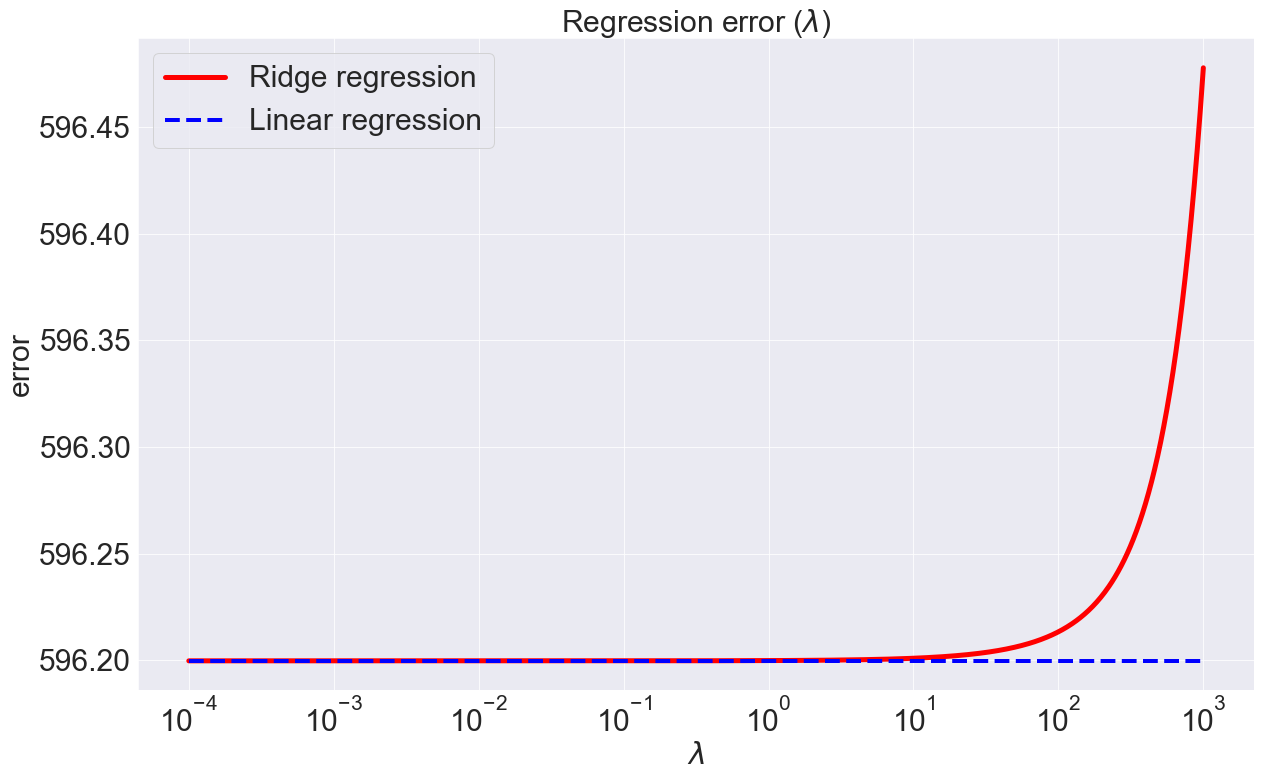

In [164]:
### según este gráfico parece se 10
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [165]:
#### He querido aplicar a la regresión lineal una regularización con Ridge pero no me ha cambiado absolutamente nada
#### Al principio probé con unvalor de alpha = 150, luego usé la función para calcular el valor óptimo y probé con 10, pero no cambiaba tampoco nada
#### Finalmente he probado con 0.5 y tampoco... Del gráfico también se puede ver que éste no es la solución ideal para mi modelo, así que abandono y pruebo con un random forest

### RANDOM FOREST - VARIAS PRUEBAS
De las varias pruebas de random forest el mejor RMSE es 22.2123

#### 6º MODELO - RANDOM FOREST 

La mejor de las varias pruebas es esta, con un RMSE de  22.21 (añun así MUY MEJORABLE) 

- Score del modelo: 0.4087
- MAE: 14.084
- MSE: 493.3844
- RMSE: 22.2123
- MAPE score: 36.4681

##### PRUEBA 1  RANDOM FOREST  ---> por lo pronto, de random forest es la mejor
(La he "mejorado" ligeramente con los parámetros encontrados en la prueba2, relativa al 7ºmodelo)

- Score del modelo: 0.4087
- MAE: 14.084
- MSE: 493.3844
- RMSE: 22.2123
- MAPE score: 36.4681

In [166]:
## defino "X" e "y"
X6_so = df_limpio_num_no_out[["points", "year", "variety_num"]]
y6_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,)

## separo en train y test
X6_so_train, X6_so_test, y6_so_train, y6_so_test = train_test_split(X6_so, y6_so, test_size = 0.2, random_state=12)

In [167]:
## compruebo las divisiones:
print("Total features shape:", X6_so.shape)
print("Train features shape:", X6_so_train.shape)
print("Train target shape:", y6_so_train.shape)
print("Test features shape:", X6_so_test.shape)
print("Test target shape:", y6_so_test.shape)

Total features shape: (46989, 3)
Train features shape: (37591, 3)
Train target shape: (37591,)
Test features shape: (9398, 3)
Test target shape: (9398,)


In [168]:
import warnings
warnings.filterwarnings('once')

In [169]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## con el random forest no hace falta que escale pero anteriormente hice una prueba sin escalar y salió muy mal, así que hago un StandardScaler

scal = StandardScaler() # Declaro el scaler
scal.fit(X6_so_train) # Lo "entreno". Calculo su media y std para cada feature
X6_so_train = scal.transform(X6_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X6_so_test = scal.transform(X6_so_test)

# Creación del modelo
rnd_for6_so = RandomForestRegressor(n_estimators = 150,   ## nº de árboles
                                    oob_score=True,        ## si está en True, es para calcular el out-of-bag R^2
                                    max_leaf_nodes = 80,   ## número máximo de nodos terminales que pueden tener los árboles
                                    max_depth= 10,     ## profundidad max que pueden alcanzar los árboles
                                    max_features = 3,  ## número de predictores considerados a en cada división
                                    random_state= 42) 

rnd_for6_so.fit(X6_so_train,y6_so_train)


RandomForestRegressor(max_depth=10, max_features=3, max_leaf_nodes=80,
                      n_estimators=150, oob_score=True, random_state=42)

In [170]:
## hacer la prediccion
predictions6_so = rnd_for6_so.predict(X6_so_test)
predictions6_so


array([49.67851068, 22.52853253, 34.96586773, ..., 20.31372069,
       68.46503479, 36.80417158])

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# calcular el MAPE
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape6 = round(mean_absolute_percentage_error(y6_so_test, predictions6_so), 4)


print('Score del modelo:', round(rnd_for6_so.score(X6_so_test, y6_so_test),4))
print('MAE:', round(mean_absolute_error(y6_so_test, predictions6_so),4))
print('MSE:', round(mean_squared_error(y6_so_test, predictions6_so),4))
print('RMSE:', round(np.sqrt(mean_squared_error(y6_so_test, predictions6_so)),4))
print("MAPE score:", mape6 )

Accuracy:  63.53 %
Score del modelo: 0.4087
MAE: 14.084
MSE: 493.3844
RMSE: 22.2123
MAPE score: 36.4681


In [172]:
### los mejores datos que había sacado eran estos:

# Score del modelo: 0.2855  ---> con Random Forest mejor (0.4084)
# MAE: 16.1768               ---> con Random Forest peor (14.0872)
# MSE: 596.1998              ---> con Random Forest mejor (493.3844)
# RMSE: 24.4172              ---> con Random Forest mejor, tengo menos error (22.2123)
# MAPE score: 52.2997        ---> con Random Forest peor (36.4681)

## NO CONSIGO VER SI EL RANDOM FOREST ES UNA ELECCIÓN MEJOR O PEOR
## LUEGO EL ACCURACY ME LO DA DEL 63.52 %, ASÍ QUE AUNQUE NO SEA UN VALOR IDEAL, PERO TAMPOCO PARECE TAN MAL

##### 7º MODELO - RANDOM FOREST (prueba2) -   muchas pruebas para tener un RMSE de 22.857
El error (rmse) de test es: 22.857236046926666

In [173]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')


In [174]:
## defino "X" e "y"
X6_so = df_limpio_num_no_out[["points", "year", "variety_num"]]
y6_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,)

In [175]:
## compruebo las divisiones:
print("Total features shape:", X6_so.shape)
print("Train features shape:", X6_so_train.shape)
print("Train target shape:", y6_so_train.shape)
print("Test features shape:", X6_so_test.shape)
print("Test target shape:", y6_so_test.shape)

Total features shape: (46989, 3)
Train features shape: (37591, 3)
Train target shape: (37591,)
Test features shape: (9398, 3)
Test target shape: (9398,)


In [176]:
# División de los datos en train y test
# ==============================================================================
X6_so_train, X6_so_test, y6_so_train, y6_so_test = train_test_split(X6_so, y6_so, test_size = 0.2, random_state=12)

# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 42
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X6_so_train, y6_so_train)


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.



RandomForestRegressor(criterion='mse', n_estimators=10, n_jobs=-1,
                      random_state=42)

In [177]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X6_so_test)

rmse = mean_squared_error(
        y_true  = y6_so_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 23.07669360298595


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:442: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:553: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\l

Valor óptimo de n_estimators: 146


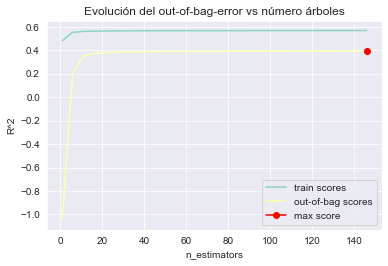

In [178]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42
             )
    modelo.fit(X6_so_train, y6_so_train)
    train_scores.append(modelo.score(X6_so_train, y6_so_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalen

Valor óptimo de n_estimators: 116


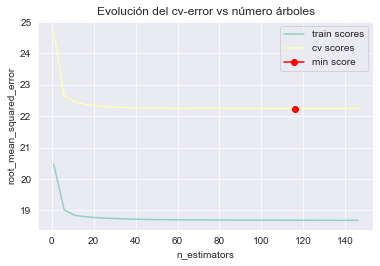

In [179]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 42
             )
    
    # Error de train
    modelo.fit(X6_so_train, y6_so_train)
    predicciones = modelo.predict(X = X6_so_train)
    rmse = mean_squared_error(
            y_true  = y6_so_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X6_so_train,
                y         = y6_so_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:442: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:442: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_for

Valor óptimo de max_features: 3


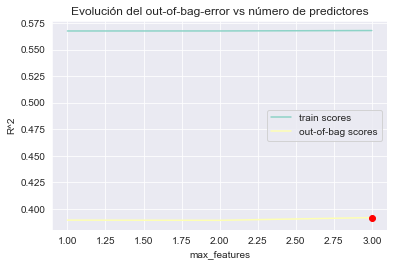

In [180]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X6_so_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42
             )
    modelo.fit(X6_so_train, y6_so_train)
    train_scores.append(modelo.score(X6_so_train, y6_so_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:442: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:442: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_for

Valor óptimo de max_features: 3


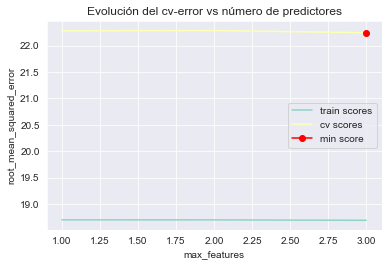

In [181]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X6_so_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42
             )
    
    # Error de train
    modelo.fit(X6_so_train, y6_so_train)
    predicciones = modelo.predict(X = X6_so_train)
    rmse = mean_squared_error(
            y_true  = y6_so_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X6_so_train,
                y         = y6_so_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

In [182]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [3],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42,
                ** params
             )
    
    modelo.fit(X6_so_train, y6_so_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:442: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



Modelo: {'max_depth': None, 'max_features': 3, 'n_estimators': 150} ✓


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:442: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



Modelo: {'max_depth': 3, 'max_features': 3, 'n_estimators': 150} ✓


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:442: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



Modelo: {'max_depth': 10, 'max_features': 3, 'n_estimators': 150} ✓


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:442: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



Modelo: {'max_depth': 20, 'max_features': 3, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
2,0.426005,10.0,3.0,150.0
3,0.396970,20.0,3.0,150.0
0,0.393251,NaN,3.0,150.0
1,0.318300,3.0,3.0,150.0


In [183]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.4260050142314594 : 0.4260050142314594 R2


In [184]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [3],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 42),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X6_so_train, y = y6_so_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
2,10,3,150,-21.601686,0.302089,-20.195367,0.079270
3,20,3,150,-22.252278,0.321313,-18.509027,0.067345
0,None,3,150,-22.307241,0.325192,-18.457605,0.066283
1,3,3,150,-23.461240,0.311761,-23.392875,0.087681


In [185]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 10, 'max_features': 3, 'n_estimators': 150} : -21.60168615518803 neg_root_mean_squared_error


In [186]:
# Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. 
# Si en el GridSearchCV() se indica refit=True, 
# este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [187]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_  ## aquí tengo almacenado el modelo con los mejores parametros definidos
predicciones = modelo.predict(X = X6_so_test)
rmse = mean_squared_error(
        y_true  = y6_so_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 22.857236046926666


In [188]:
# Importancia de predictores

In [189]:
modelo.feature_importances_

array([0.52684365, 0.17643339, 0.29672296])

In [190]:
df_limpio_num_no_out[["points", "year", "variety_num"]].columns

Index(['points', 'year', 'variety_num'], dtype='object')

In [191]:
# Importancia por pureza de nodos (ya veo por la celda anterior que es "points", pero lo voy a poner mas visual)

importancia_predictores = pd.DataFrame(
                            {'predictor': df_limpio_num_no_out[["points", "year", "variety_num"]].columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,points,0.526844
2,variety_num,0.296723
1,year,0.176433


In [192]:
# Importancia por permutación
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X6_so_train,
                y            = y6_so_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 42
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X6_so_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
0,10.175033,0.035082,points
2,4.469770,0.030249,variety_num
1,2.940537,0.048521,year


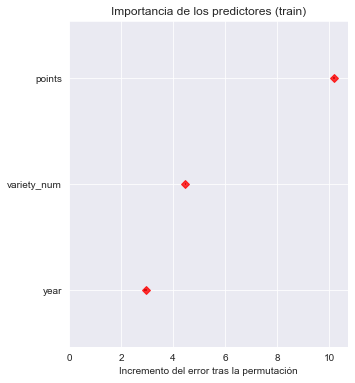

In [193]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

##### prueba3  RANDOM FOREST  solo con "points"   ---> da PEORES resultados que con las 3 columnas clásicas así que DESCARTO este modelo

- Score del modelo: 0.3052
- MAE: 15.7886
- MSE: 579.7368
- RMSE: 24.0777
- MAPE score: 41.6905

In [194]:
## defino "X" e "y"
X7_so = np.array(df_limpio_num_no_out["points"]).reshape(-1,1)
y7_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,)

## separo en train y test
X7_so_train, X7_so_test, y7_so_train, y7_so_test = train_test_split(X7_so, y7_so, test_size = 0.2, random_state=12)

In [195]:
## compruebo las divisiones:
print("Total features shape:", X7_so.shape)
print("Train features shape:", X7_so_train.shape)
print("Train target shape:", y7_so_train.shape)
print("Test features shape:", X7_so_test.shape)
print("Test target shape:", y7_so_test.shape)

Total features shape: (46989, 1)
Train features shape: (37591, 1)
Train target shape: (37591,)
Test features shape: (9398, 1)
Test target shape: (9398,)


In [196]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## con el random forest no hace falta que escale pero anteriormente hice una prueba sin escalar y salió muy mal, así que hago un StandardScaler

scal = StandardScaler() # Declaro el scaler
scal.fit(X7_so_train) # Lo "entreno". Calculo su media y std para cada feature
X7_so_train = scal.transform(X7_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X7_so_test = scal.transform(X7_so_test)

# Creación del modelo
rnd_for7_so = RandomForestRegressor(n_estimators = 100, oob_score=True, max_leaf_nodes = 80, random_state= 42) 

rnd_for7_so.fit(X7_so_train,y7_so_train)

RandomForestRegressor(max_leaf_nodes=80, oob_score=True, random_state=42)

In [197]:
## hacer la prediccion
predictions7_so = rnd_for7_so.predict(X7_so_test)
predictions7_so

array([39.56199694, 26.86618191, 26.86618191, ..., 26.86618191,
       45.24505854, 39.56199694])

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# calcular el MAPE
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape7 = round(mean_absolute_percentage_error(y7_so_test, predictions7_so), 4)


print('Score del modelo:', round(rnd_for7_so.score(X7_so_test, y7_so_test),4))
print('MAE:', round(mean_absolute_error(y7_so_test, predictions7_so),4))
print('MSE:', round(mean_squared_error(y7_so_test, predictions7_so),4))
print('RMSE:', round(np.sqrt(mean_squared_error(y7_so_test, predictions7_so)),4))
print("MAPE score:", mape7 )

In [199]:
# ### valores con las 3 columnas de points, variety y year
# Score del modelo: 0.4081
# MAE: 14.0872
# MSE: 493.8676
# RMSE: 22.2231
# MAPE score: 36.4808

### SVM - VARIAS PRUEBAS - el PEOR modelo de todos
De las varias pruebas, el mejor RMSE es se 25.2927

#### 8º MODELO - SVM   -->mejor valores con kernel = "linear", pero aún así es de los peores modelos
svr8_so = SVR(kernel='linear', C=100, epsilon=0.2)
- Score del modelo: 0.2333
- MAE: 15.2674
- MSE: 639.7182
- RMSE: 25.2927
- MAPE score: 62.3392


svr8_so = SVR(kernel='poly', C=100, epsilon=0.2, gamma="scale")  
- Score del modelo: 0.1078
- MAE: 16.9258
- MSE: 744.424
- RMSE: 27.2841
- MAPE score: 77.5738

svr8_so = SVR(kernel='rbf', C=1.0, epsilon=0.2)
- Score del modelo: -0.0714
- MAE: 18.7309
- MSE: 893.9124
- RMSE: 29.8984
- MAPE score: 62.2804

svr8_so = SVR(kernel='sigmoid', C=1.0, epsilon=0.2) 
- Score del modelo: -0.0814
- MAE: 18.9063
- MSE: 902.2902
- RMSE: 30.0381
- MAPE score: 62.8891


In [200]:
## defino "X" e "y"
X8_so = df_limpio_num_no_out[["points", "year", "variety_num"]]
y8_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,)

## separo en train y test
X8_so_train, X8_so_test, y8_so_train, y8_so_test = train_test_split(X8_so, y8_so, test_size = 0.2, random_state=12)

In [201]:
## escalo los datos, SVM es muy sensible a esto
scal = StandardScaler() # Declaro el scaler
scal.fit(X8_so_train) # Lo "entreno". Calculo su media y std para cada feature
X8_so_train = scal.transform(X8_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X8_so_test = scal.transform(X8_so_test)

from sklearn.svm import SVR
#Defino el algoritmo a utilizar
# svr8_so = SVR(kernel='linear', C=100, epsilon=0.2)  ### resultado RMSE: 25.2927
svr8_so = SVR(kernel='poly', C=100, epsilon=0.2, gamma="scale")      ### resultado RMSE: 27.2841  (he mejorado 2 puntos respecto a C= 1 pero sigue siendo un error alto)
# svr8_so = SVR(kernel='rbf', C=1.0, epsilon=0.2)      ### resultado RMSE:  29.8984
# svr8_so = SVR(kernel='sigmoid', C=1.0, epsilon=0.2)       ### resultado RMSE: 30.0381


#Entreno el modelo
svr8_so.fit(X8_so_train, y8_so_train)


KeyboardInterrupt: 

In [ ]:
#Realizo una predicción
predictions8_so = svr8_so.predict(X8_so_test)
predictions8_so

array([31.96437656, 30.05953931, 30.63056032, ..., 30.15059951,
       32.66724576, 32.11979804])

In [ ]:
print('DATOS DEL MODELO VECTORES DE SOPORTE REGRESIÓN')

# calcular el MAPE
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape8 = round(mean_absolute_percentage_error(y8_so_test, predictions8_so), 4)


print('Score del modelo:', round(svr8_so.score(X8_so_test, y8_so_test),4))
print('MAE:', round(mean_absolute_error(y8_so_test, predictions8_so),4))
print('MSE:', round(mean_squared_error(y8_so_test, predictions8_so),4))
print('RMSE:', round(np.sqrt(mean_squared_error(y8_so_test, predictions8_so)),4))
print("MAPE score:", mape8 )

DATOS DEL MODELO VECTORES DE SOPORTE REGRESIÓN
Accuracy:  22.43 %
Score del modelo: 0.1078
MAE: 16.9258
MSE: 744.424
RMSE: 27.2841
MAPE score: 77.5738


### HIST GRADIENT BOOSTING REGRESSOR
RMSE  21.6216

#### 9º MODELO - HIST GRADIENT BOOSTING REGRESSOR

- Score del modelo: 0.4397
- MAE: 13.5945
- MSE: 467.4915
- RMSE  21.6216
- MAPE score: 34.7052

In [202]:
## defino "X" e "y"
X9_so = df_limpio_num_no_out[["points", "year", "variety_num"]]
y9_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,)

## separo en train y test
X9_so_train, X9_so_test, y9_so_train, y9_so_test = train_test_split(X9_so, y9_so, test_size = 0.2, random_state=12)

In [203]:
## escalo los datos, SVM es muy sensible a esto
scal = StandardScaler() # Declaro el scaler
scal.fit(X9_so_train) # Lo "entreno". Calculo su media y std para cada feature
X9_so_train = scal.transform(X9_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X9_so_test = scal.transform(X9_so_test)

from sklearn.ensemble import HistGradientBoostingRegressor
HGB_9_so = HistGradientBoostingRegressor(learning_rate=0.2)
HGB_9_so.fit(X9_so_train, y9_so_train)

HistGradientBoostingRegressor(learning_rate=0.2)

In [204]:
predictions9_so = HGB_9_so.predict(X = X9_so_test)
predictions9_so

array([52.24125569, 23.88298446, 35.22164706, ..., 18.11874399,
       64.88694569, 43.36522659])

In [205]:
# calcular el MAPE
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape9 = round(mean_absolute_percentage_error(y9_so_test, predictions9_so), 4)


print('Score del modelo:', round(HGB_9_so.score(X9_so_test, y9_so_test),4))
print('MAE:', round(mean_absolute_error(y9_so_test, predictions9_so),4))
print('MSE:', round(mean_squared_error(y9_so_test, predictions9_so),4))
print('RMSE ', round(np.sqrt(mean_squared_error(y9_so_test, predictions9_so)),4))
print("MAPE score:", mape9 )

Score del modelo: 0.4395
MAE: 13.5869
MSE: 467.6408
RMSE  21.625
MAPE score: 34.6199


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



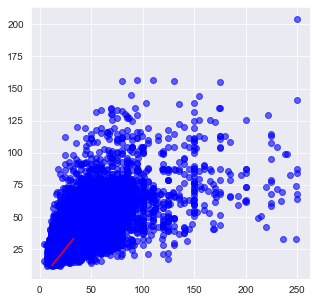

In [206]:
plt.figure(figsize=(5,5))
sns.regplot(y9_so_test, predictions9_so, color='blue', scatter_kws={'alpha':0.6}, fit_reg=False);
sns.lineplot([12, 33], [12, 33], color='red');

### este sería el regplot con el histgradientboost

### EXTRA TREE REGRESSOR
RMSE  22.9485    --> parecido al random forest, pero algo peor


#### 10º MODELO - EXTRA TREE REGRESSOR

- Score del modelo: 0.3688
- MAE: 14.2842
- MSE: 526.6342
- RMSE  22.9485
- MAPE score: 36.5763

In [207]:
## defino "X" e "y"
X10_so = df_limpio_num_no_out[["points", "year", "variety_num"]]
y10_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,)

## separo en train y test
X10_so_train, X10_so_test, y10_so_train, y10_so_test = train_test_split(X10_so, y10_so, test_size = 0.2, random_state=12)

In [208]:
## escalo los datos, SVM es muy sensible a esto
scal = StandardScaler() # Declaro el scaler
scal.fit(X10_so_train) # Lo "entreno". Calculo su media y std para cada feature
X10_so_train = scal.transform(X10_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X10_so_test = scal.transform(X10_so_test)

In [209]:
from sklearn.ensemble import ExtraTreesRegressor
# Creación del modelo
# ==============================================================================
extraTree10_so = ExtraTreesRegressor(
            n_estimators = 150,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            bootstrap = True,
            oob_score    = True,
            n_jobs       = -1,
            random_state = 42
         )

# Entrenamiento del modelo
# ==============================================================================
extraTree10_so.fit(X10_so_train, y10_so_train)

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py:391: FutureWarning:

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.



ExtraTreesRegressor(bootstrap=True, criterion='mse', n_estimators=150,
                    n_jobs=-1, oob_score=True, random_state=42)

In [210]:
predictions10_so = extraTree10_so.predict(X = X10_so_test)
predictions10_so

array([53.94371761, 25.49928033, 31.36117559, ..., 18.14954981,
       67.42368577, 26.02722222])

In [211]:
# calcular el MAPE
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape10 = round(mean_absolute_percentage_error(y10_so_test, predictions10_so), 4)


print('Score del modelo:', round(extraTree10_so.score(X10_so_test, y10_so_test),4))
print('MAE:', round(mean_absolute_error(y10_so_test, predictions10_so),4))
print('MSE:', round(mean_squared_error(y10_so_test, predictions10_so),4))
print('RMSE ', round(np.sqrt(mean_squared_error(y10_so_test, predictions10_so)),4))
print("MAPE score:", mape10 )

Score del modelo: 0.3688
MAE: 14.2842
MSE: 526.6342
RMSE  22.9485
MAPE score: 36.5763


### MÁS PRUEBAS DE BOOSTING (ADABOOST, GRADIENTBOOST, XGBOOST)
El mejor RMSE es RMSE  21.4679, relativo a gradientboost - De momento (24/11 h 17:57) es el mejor de los modelos

#### 11º MODELO - ADABOOST

- Score del modelo: 0.274
- MAE: 17.4905
- MSE: 605.7591
- RMSE  24.6122
- MAPE score: 40.7513

In [212]:
## defino "X" e "y"
X11_so = df_limpio_num_no_out[["points", "year", "variety_num"]]
y11_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,)

## separo en train y test
X11_so_train, X11_so_test, y11_so_train, y11_so_test = train_test_split(X11_so, y11_so, test_size = 0.2, random_state=12)

In [213]:
## escalo los datos, 
scal = StandardScaler() # Declaro el scaler
scal.fit(X11_so_train) # Lo "entreno". Calculo su media y std para cada feature
X11_so_train = scal.transform(X11_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X11_so_test = scal.transform(X11_so_test)

In [214]:
from sklearn.ensemble import AdaBoostRegressor

adaboost11_so = AdaBoostRegressor(n_estimators=200,
                                random_state=42)

adaboost11_so.fit(X11_so_train, y11_so_train)

predictions11_so = adaboost11_so.predict(X11_so_test)
predictions11_so


array([57.49347303, 34.08001952, 34.08001952, ..., 34.08001952,
       54.68426873, 44.12821284])

In [215]:
# calcular el MAPE
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape11 = round(mean_absolute_percentage_error(y11_so_test, predictions11_so), 4)


print('Score del modelo:', round(adaboost11_so.score(X11_so_test, y11_so_test),4))
print('MAE:', round(mean_absolute_error(y11_so_test, predictions11_so),4))
print('MSE:', round(mean_squared_error(y11_so_test, predictions11_so),4))
print('RMSE ', round(np.sqrt(mean_squared_error(y11_so_test, predictions11_so)),4))
print("MAPE score:", mape11 )

Score del modelo: 0.274
MAE: 17.4905
MSE: 605.7591
RMSE  24.6122
MAPE score: 40.7513


#### 12º MODELO - GRADIENTBOOSTING

- Score del modelo: 0.4476
- MAE: 13.5141
- MSE: 460.8724
- RMSE  21.4679
- MAPE score: 34.4819

In [216]:
## defino "X" e "y"
X12_so = df_limpio_num_no_out[["points", "year", "variety_num"]]
y12_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,)

## separo en train y test
X12_so_train, X12_so_test, y12_so_train, y12_so_test = train_test_split(X12_so, y12_so, test_size = 0.2, random_state=12)

In [217]:
## escalo los datos
scal = StandardScaler() # Declaro el scaler
scal.fit(X12_so_train) # Lo "entreno". Calculo su media y std para cada feature
X12_so_train = scal.transform(X12_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X12_so_test = scal.transform(X12_so_test)

In [218]:
from sklearn.ensemble import GradientBoostingRegressor

grboost12_so = GradientBoostingRegressor(max_depth=5,
                                 n_estimators=200,
                                 learning_rate=0.1,
                                 random_state=42)

grboost12_so.fit(X12_so_train, y12_so_train)


predictions12_so = grboost12_so.predict(X12_so_test)
predictions12_so

array([50.6603356 , 23.30378056, 35.60156157, ..., 18.59168975,
       68.85397253, 37.10375324])

In [219]:
# calcular el MAPE
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape12 = round(mean_absolute_percentage_error(y12_so_test, predictions12_so), 4)


print('Score del modelo:', round(grboost12_so.score(X12_so_test, y12_so_test),4))
print('MAE:', round(mean_absolute_error(y12_so_test, predictions12_so),4))
print('MSE:', round(mean_squared_error(y12_so_test, predictions12_so),4))
print('RMSE ', round(np.sqrt(mean_squared_error(y12_so_test, predictions12_so)),4))
print("MAPE score:", mape12 )

Score del modelo: 0.4476
MAE: 13.5141
MSE: 460.8724
RMSE  21.4679
MAPE score: 34.4819


#### 13º MODELO - XGBOOST

- Score del modelo: 0.4446
- MAE: 13.5279
- MSE: 463.3992
- RMSE  21.5267
- MAPE score: 34.4696

In [220]:
## defino "X" e "y"
X13_so = df_limpio_num_no_out[["points", "year", "variety_num"]]
y13_so = np.array(df_limpio_num_no_out["price"]).reshape(-1,)

## separo en train y test
X13_so_train, X13_so_test, y13_so_train, y13_so_test = train_test_split(X13_so, y13_so, test_size = 0.2, random_state=12)

In [221]:
## escalo los datos
scal = StandardScaler() # Declaro el scaler
scal.fit(X13_so_train) # Lo "entreno". Calculo su media y std para cada feature
X13_so_train = scal.transform(X13_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X13_so_test = scal.transform(X13_so_test)

In [222]:
import xgboost

xgb13_so = xgboost.XGBRegressor(max_depth=5,
                                 n_estimators=200,
                                 learning_rate=0.1,
                                random_state=42)

xgb13_so.fit(X13_so_train, y13_so_train)

predictions13_so = xgb13_so.predict(X13_so_test)
predictions13_so

array([50.639217, 23.517605, 35.433624, ..., 18.910158, 69.74089 ,
       37.764267], dtype=float32)

In [223]:
# calcular el MAPE
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape13 = round(mean_absolute_percentage_error(y13_so_test, predictions13_so), 4)


print('Score del modelo:', round(xgb13_so.score(X13_so_test, y13_so_test),4))
print('MAE:', round(mean_absolute_error(y13_so_test, predictions13_so),4))
print('MSE:', round(mean_squared_error(y13_so_test, predictions13_so),4))
print('RMSE ', round(np.sqrt(mean_squared_error(y13_so_test, predictions13_so)),4))
print("MAPE score:", mape13 )

Score del modelo: 0.4446
MAE: 13.5279
MSE: 463.3992
RMSE  21.5267
MAPE score: 34.4696


## ----

--------------------------------------------

### VUELVO A LA EDICIÓN DE COLUMNAS/CREACIÓN NUEVAS VARIABLES
Después de probar todos estos modelos, no consigo mejorar el RMSE de 21.4679
Así que "vuelvo atrás" a mi dataframe inicial (él que ya estaba limpio, sin NaNs ni duplicados) y pruebo
a mirar las columnas para ver hubiera alguna correlación que me he perdido por el camino.
Antes usaré la matriz Phik para ver si hubiera alguna correlación entre alguna variable categórica

Sucesivamente, volveré a borrar outliers y a ejecutar los 3 modelos que mejor resultado me dieron hasta ahora, 
con mi nuevo dataframe

A ver qué tal

In [470]:
## vuelvo a cargarme el dataframe para tenerlo a mano:
df_limpio2 = pd.read_csv("..\\data\\processed\\vinos_editado.csv")
df_limpio2.head(3)

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year
0,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian,2013
1,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks,2012
2,Spain,"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tempranillo-Merlot,Tandem,2011


In [277]:
# no_descr = df_limpio2.drop(["description"], axis = 1)
# no_descr

,country,designation,points,price,province,region_1,taster_name,variety,winery,year
0,US,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian,2013
1,US,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks,2012
2,Spain,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tempranillo-Merlot,Tandem,2011
3,Italy,Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Frappato,Terre di Giurfo,2013
4,France,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Pinot Gris,Jean-Baptiste Adam,2012
...,...,...,...,...,...,...,...,...,...,...
47137,France,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Pinot Gris,Cave de Turckheim,2010
47138,Italy,Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Nero d'Avola,Cusumano,2012
47139,France,Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Pinot Gris,Domaine Rieflé-Landmann,2013
47140,France,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Gewürztraminer,Domaine Gresser,2013


In [226]:
# # # # ## le paso la matriz Phik para ver las correlaciones entre variables categóricas
# # # # import phik
# # # # phik_matrix = no_descr.phik_matrix()

# # # # plt.figure(figsize=(20,20))
# # # # sns.heatmap(phik_matrix,
# # # #             vmin=-1,
# # # #             vmax=1,
# # # #             center=0,
# # # #             cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
# # # #             square=True,
# # # #             annot=True,
# # # #             linewidths=.5);

#### NO EJECUTAR!!!! DESPUÉS DE 14h EJECUTÁNDOSE HE TENIDO QUE ABANDONAR LA IDEA

In [279]:
### quito ya los catadores, he visto a lo largo del análisis que no me sirven para el modelo de ML
df_limpio_num2 = df_limpio_num[["country_num","variety_num", "points", "year", "price"]]
df_limpio_num2

,country_num,variety_num,points,year,price
0,0,6,87,2013,13.0
1,0,0,87,2012,65.0
2,3,207,87,2011,15.0
3,2,142,87,2013,16.0
4,1,17,87,2012,27.0
...,...,...,...,...,...
47137,1,17,90,2010,57.0
47138,2,40,90,2012,40.0
47139,1,17,90,2013,28.0
47140,1,22,90,2013,30.0


In [280]:
### finalmente NO voy a ir por este camino en mi notebook final así que 
### NO VOY A INCLUIR ESTA FUNCIÓN EN EL ARCHIVO funciones.py


## Voy a simplificar la columna "points", metiendo las puntuaciones de 80 a 100 dentro de un rango que irá de 1 a 5
# # 1 ->  80 - 84 
# # 2 ->  84 - 88
# # 3 ->  88 - 92 
# # 4 ->  92 - 96 
# # 5 ->  96 - 100 

### lo haré en el dataframe numérico que tenía hasta ahora, el df_limpio_num


def points_to_ratings(points):
    if points < 84:
        return 1
    elif points >= 84 and points < 88:
        return 2 
    elif points >= 88 and points < 92:
        return 3 
    elif points >= 92 and points < 96:
        return 4 
    else:
        return 5

### aplico la función y creo nueva columna con los nuevos valores, que llamaré "ratings"
df_limpio_num2 = df_limpio_num2.assign(ratings = df_limpio_num2['points'].apply(points_to_ratings))
df_limpio_num2.head()

,country_num,variety_num,points,year,price,ratings
0,0,6,87,2013,13.0,2
1,0,0,87,2012,65.0,2
2,3,207,87,2011,15.0,2
3,2,142,87,2013,16.0,2
4,1,17,87,2012,27.0,2


In [284]:
df_limpio_num2.info()
## compruebo que siga todo en orden

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47142 entries, 0 to 47141
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country_num  47142 non-null  int64  
 1   variety_num  47142 non-null  int64  
 2   points       47142 non-null  int64  
 3   year         47142 non-null  int64  
 4   price        47142 non-null  float64
 5   ratings      47142 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 2.5 MB


In [285]:
## ya puedo prescindir de la columna "points", ahora tengo "ratings" con la que haré las siguientes pruebas
df_limpio_num2.drop(["points"], axis = 1, inplace= True)

In [286]:
df_limpio_num2

,country_num,variety_num,year,price,ratings
0,0,6,2013,13.0,2
1,0,0,2012,65.0,2
2,3,207,2011,15.0,2
3,2,142,2013,16.0,2
4,1,17,2012,27.0,2
...,...,...,...,...,...
47137,1,17,2010,57.0,3
47138,2,40,2012,40.0,3
47139,1,17,2013,28.0,3
47140,1,22,2013,30.0,3


In [ ]:
#### sobre este último df con los ratings, vuelvo a quitar los outliers de "price", y luego los quito también de "year"
### luego saco diagramas de caja y bigote para ver si efectivamente se me han quitado

In [288]:
df_limpio_num2

,country_num,variety_num,year,price,ratings
0,0,6,2013,13.0,2
1,0,0,2012,65.0,2
2,3,207,2011,15.0,2
3,2,142,2013,16.0,2
4,1,17,2012,27.0,2
...,...,...,...,...,...
47137,1,17,2010,57.0,3
47138,2,40,2012,40.0,3
47139,1,17,2013,28.0,3
47140,1,22,2013,30.0,3


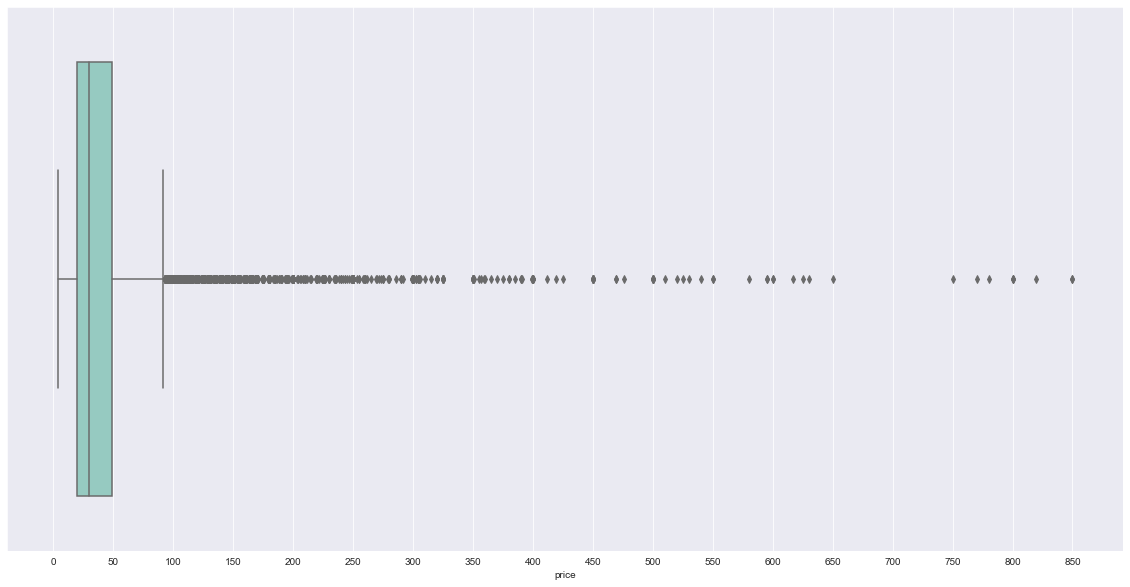

In [295]:
### boxplot ANTES de quitar OUTLIERS
plt.figure(figsize=(20,10))
sns.boxplot(df_limpio_num2["price"]);
plt.xticks(np.arange(0,900, 50));

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



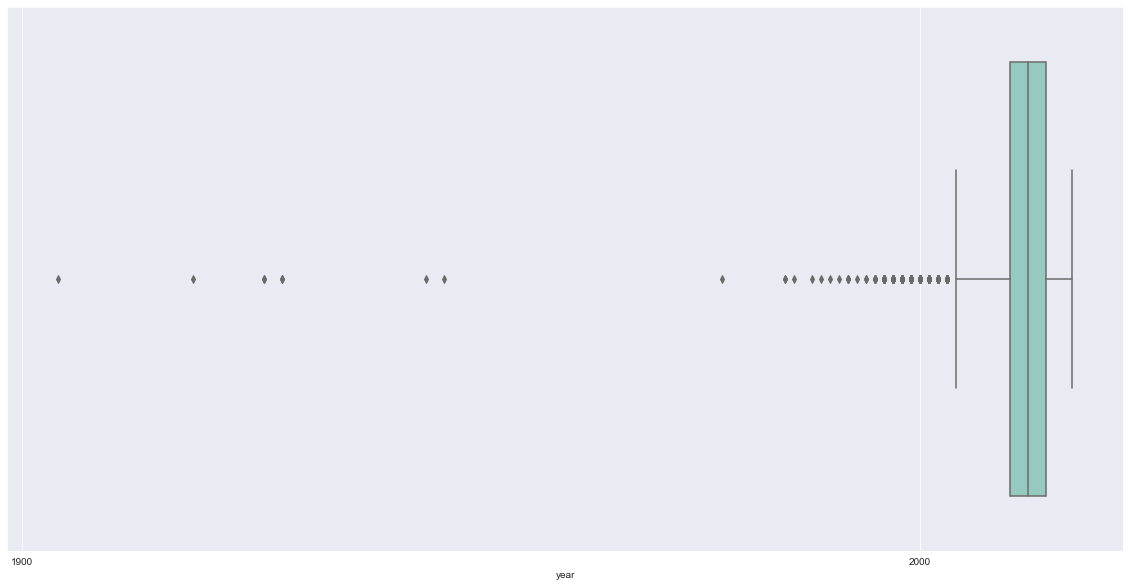

In [296]:
### boxplot ANTES de quitar OUTLIERS
plt.figure(figsize=(20,10))
sns.boxplot(df_limpio_num2["year"]);
plt.xticks(np.arange(1900,2020, 100));

In [299]:
#### quito outliers de la columna "price"
from scipy.stats import iqr

def outliers_quantie(df, feature, param=1.5):  
        
    iqr_ = iqr(df[feature], nan_policy='omit')
    q1 = np.nanpercentile(df[feature], 25)
    q3 = np.nanpercentile(df[feature], 75)
    
    th1 = q1 - iqr_*param
    th2 = q3 + iqr_*param
    
    return df[(df[feature] >= th1) & (df[feature] <= th2)].reset_index(drop=True)

df_no_out_price = outliers_quantie(df_limpio_num2, 'price', 7)
print("Len original:", len(df_limpio_num2))
print("Len sin outliers en price:", len(df_no_out_price))

Len original: 47142
Len sin outliers en price: 46989


In [301]:
#### ahora lo hago con la columna "year", partiendo del df con los outliers de precio quitados
from scipy.stats import iqr

def outliers_quantie(df, feature, param=1.5):  
        
    iqr_ = iqr(df[feature], nan_policy='omit')
    q1 = np.nanpercentile(df[feature], 25)
    q3 = np.nanpercentile(df[feature], 75)
    
    th1 = q1 - iqr_*param
    th2 = q3 + iqr_*param
    
    return df[(df[feature] >= th1) & (df[feature] <= th2)].reset_index(drop=True)

df_no_outliers = outliers_quantie(df_no_out_price, 'year', 7)
print("Len original:", len(df_no_out_price))
print("Len sin outliers en price:", len(df_no_outliers))

Len original: 46989
Len sin outliers en price: 46982


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



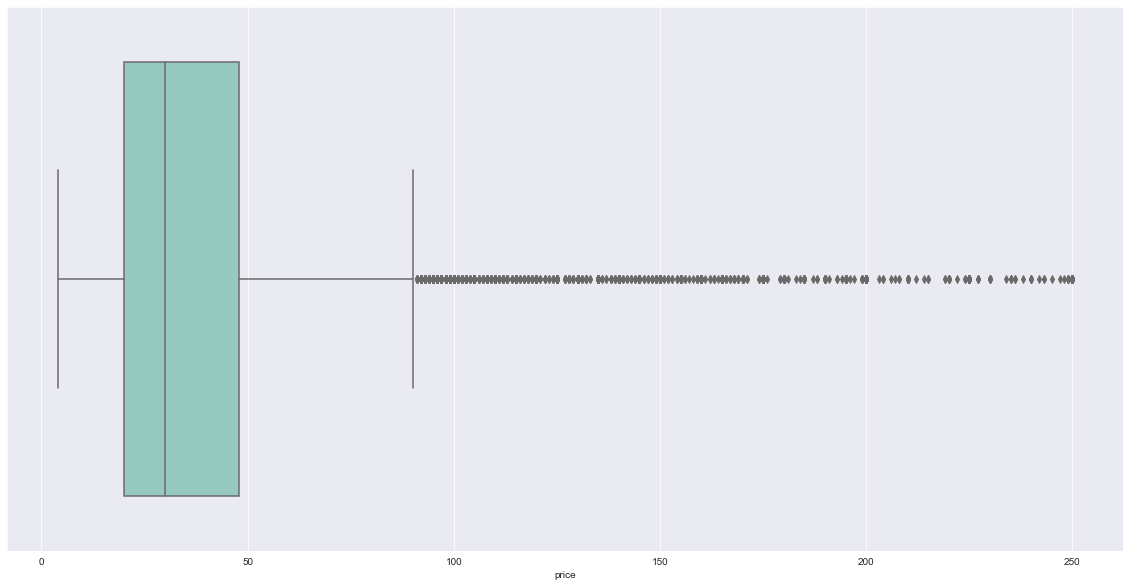

In [304]:
### vuelvo a sacar lo gráficos de caja y bigote
plt.figure(figsize=(20,10))
sns.boxplot(df_no_outliers["price"]);
plt.xticks(np.arange(0,300, 50));

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



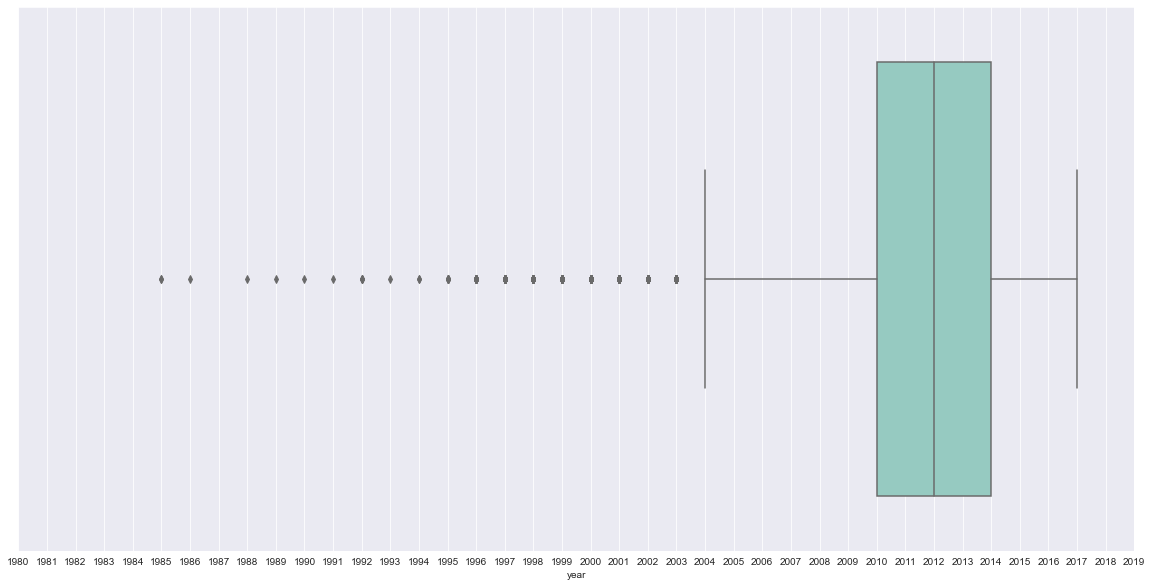

In [308]:
### boxplot ANTES de quitar OUTLIERS
plt.figure(figsize=(20,10))
sns.boxplot(df_no_outliers["year"]);
plt.xticks(np.arange(1980,2020, 1));

In [ ]:
##### NOTA sobre OUTLIERS:
## de price me ha quitado los precios de 250 $ para arriba
## de year solo me ha quitado 6 valores, los que estaban demasiado alejados. Ahora el rango de años va de 1985 a 2017 (originalmente había vinos de 1904)

In [ ]:
## una vez quitado los outliers hago una prueba de volver a ejecutar el mejor modelo hasta ahora (gradientBoosting)
## miro el resultado
### luego ya pruebo la escala logarítmica

In [309]:
################ nuevas pruebas ML sobre este df: df_no_outliers ############
df_no_outliers

,country_num,variety_num,year,price,ratings
0,0,6,2013,13.0,2
1,0,0,2012,65.0,2
2,3,207,2011,15.0,2
3,2,142,2013,16.0,2
4,1,17,2012,27.0,2
...,...,...,...,...,...
46977,1,17,2010,57.0,3
46978,2,40,2012,40.0,3
46979,1,17,2013,28.0,3
46980,1,22,2013,30.0,3


#### 12_Bº MODELO - GRADIENTBOOSTING (segunda prueba) -- PEORES RESULTADOS
- Score del modelo: 0.4141
- MAE: 13.9987
- MSE: 492.9354
- RMSE  22.2021
- MAPE score: 36.1036

In [313]:
## defino "X" e "y"
X12b_so = df_no_outliers[["ratings", "year", "variety_num"]]  ## ojo! "ratings", no "points"
y12b_so = np.array(df_no_outliers["price"]).reshape(-1,)

## separo en train y test
X12b_so_train, X12b_so_test, y12b_so_train, y12b_so_test = train_test_split(X12b_so, y12b_so, test_size = 0.2, random_state=12)


## escalo los datos
scal = StandardScaler() # Declaro el scaler
scal.fit(X12b_so_train) # Lo "entreno". Calculo su media y std para cada feature
X12b_so_train = scal.transform(X12b_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X12b_so_test = scal.transform(X12b_so_test)


grboost12b_so = GradientBoostingRegressor(max_depth=5,
                                 n_estimators=200,
                                 learning_rate=0.1,
                                 random_state=42)

grboost12b_so.fit(X12b_so_train, y12b_so_train)


predictions12b_so = grboost12b_so.predict(X12b_so_test)
predictions12b_so


# funcion para calcular el MAPE
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape12b = round(mean_absolute_percentage_error(y12b_so_test, predictions12b_so), 4)


print('Score del modelo:', round(grboost12b_so.score(X12b_so_test, y12b_so_test),4))
print('MAE:', round(mean_absolute_error(y12b_so_test, predictions12b_so),4))
print('MSE:', round(mean_squared_error(y12b_so_test, predictions12b_so),4))
print('RMSE ', round(np.sqrt(mean_squared_error(y12b_so_test, predictions12b_so)),4))
print("MAPE score:", mape12b )

Score del modelo: 0.4141
MAE: 13.9987
MSE: 492.9354
RMSE  22.2021
MAPE score: 36.1036


#### 13_Bº MODELO - XGBOOSTING (segunda prueba) -- PEORES RESULTADOS
- Score del modelo: 0.4149
- MAE: 14.0036
- MSE: 492.3369
- RMSE  22.1887
- MAPE score: 36.0882

In [314]:

## defino "X" e "y"
X13b_so = df_no_outliers[["ratings", "year", "variety_num"]]  ## ojo! "ratings", no "points"
y13b_so = np.array(df_no_outliers["price"]).reshape(-1,)

## separo en train y test
X13b_so_train, X13b_so_test, y13b_so_train, y13b_so_test = train_test_split(X13b_so, y13b_so, test_size = 0.2, random_state=12)


## escalo los datos, SVM es muy sensible a esto
scal = StandardScaler() # Declaro el scaler
scal.fit(X13b_so_train) # Lo "entreno". Calculo su media y std para cada feature
X13b_so_train = scal.transform(X13b_so_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X13b_so_test = scal.transform(X13b_so_test)


xgb13b_so = xgboost.XGBRegressor(max_depth=5,
                                 n_estimators=200,
                                 learning_rate=0.1,
                                random_state=42)

xgb13b_so.fit(X13b_so_train, y13b_so_train)

predictions13b_so = xgb13b_so.predict(X13b_so_test)
predictions13b_so


# funcion para calcular el MAPE
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape13b = round(mean_absolute_percentage_error(y13b_so_test, predictions13b_so), 4)


print('Score del modelo:', round(xgb13b_so.score(X13b_so_test, y13b_so_test),4))
print('MAE:', round(mean_absolute_error(y13b_so_test, predictions13b_so),4))
print('MSE:', round(mean_squared_error(y13b_so_test, predictions13b_so),4))
print('RMSE ', round(np.sqrt(mean_squared_error(y13b_so_test, predictions13b_so)),4))
print("MAPE score:", mape13b )

Score del modelo: 0.4149
MAE: 14.0036
MSE: 492.3369
RMSE  22.1887
MAPE score: 36.0882


#### Me está dando peores resultados, no sigo por este camino. Hago la transformación logarítmica o box cox y a ver qué tal

In [346]:
df_no_outliers
### sobre las columnas de este df voy a ver los gráficos de la columna original, con transformacion logarítmica y con transformación box cox

,country_num,variety_num,year,price,ratings
0,0,7,2013,13.0,2
1,0,1,2012,65.0,2
2,3,208,2011,15.0,2
3,2,143,2013,16.0,2
4,1,18,2012,27.0,2
...,...,...,...,...,...
46977,1,18,2010,57.0,3
46978,2,41,2012,40.0,3
46979,1,18,2013,28.0,3
46980,1,23,2013,30.0,3


##### TRANSFORMACIONES SOBRE COLUMNA PRICE

In [347]:
from scipy.stats import shapiro
from scipy.stats import skew

wine_target = df_no_outliers["price"]

# Muy por debajo del nivel de significación (0.05) no se considera distribución normal.
print("Saphiro:", shapiro(wine_target).pvalue)

# Para comprobar la asimetría de una variable siempre podemos calcular su valor skew
# 0 si es simetrica, >0 cola hacia la derecha, <0 cola hacia la izquierda
print("Asimetria:", skew(wine_target))

Saphiro: 0.0
Asimetria: 2.4682263473875588


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



p-value Shapiro test Original:  0.0
Asimetria: 2.4682263473875588
p-value Shapiro test Logaritmic:  1.401298464324817e-45
Asimetria: 0.2852177513434488
p-value Shapiro test Box-cox:  4.021603109743133e-34


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Asimetria: 0.01603797218908142


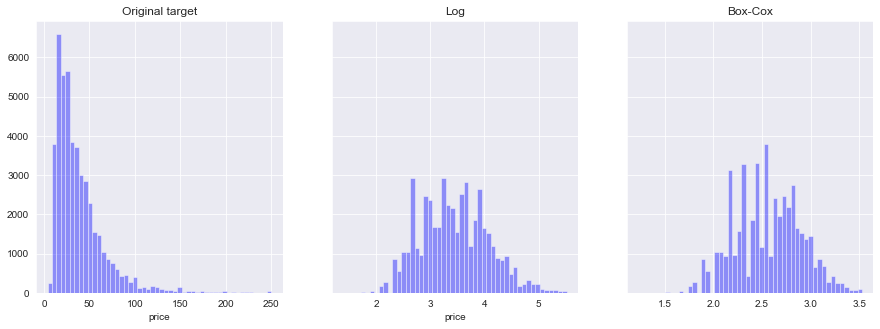

In [348]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Original target
print("p-value Shapiro test Original: ", shapiro(wine_target).pvalue)
sns.distplot(wine_target, kde=False, color= "b", ax=axes[0])
axes[0].set_title("Original target")
print("Asimetria:", skew(wine_target))

# Logaritmic
print("p-value Shapiro test Logaritmic: ", shapiro(np.log(wine_target),).pvalue)
sns.distplot(np.log(wine_target),kde=False, color= "b", ax=axes[1])
axes[1].set_title("Log")
print("Asimetria:", skew(np.log(wine_target)))

# Box-cox
print("p-value Shapiro test Box-cox: ", shapiro(stats.boxcox(wine_target)[0]).pvalue)
sns.distplot(stats.boxcox(wine_target)[0],kde=False,color= "b",  ax=axes[2])
axes[2].set_title("Box-Cox");
print("Asimetria:", skew(stats.boxcox(wine_target)[0]));

##### TRANSFORMACIONES SOBRE COLUMNA RATINGS   ---> no veo muchos cambios, creo que no la usaré para esta

In [349]:
wine_ratings = df_no_outliers["ratings"]

# Muy por debajo del nivel de significación (0.05) no se considera distribución normal.
print("Saphiro:", shapiro(wine_ratings).pvalue)

# Para comprobar la asimetría de una variable siempre podemos calcular su valor skew
# 0 si es simetrica, >0 cola hacia la derecha, <0 cola hacia la izquierda
print("Asimetria:", skew(wine_ratings))

Saphiro: 0.0
Asimetria: -0.09434907689425912


p-value Shapiro test Original:  0.0
Asimetria: -0.09434907689425912
p-value Shapiro test Logaritmic:  0.0
Asimetria: -1.0050564605651
p-value Shapiro test Box-cox:  0.0
Asimetria: -0.052104661329565476


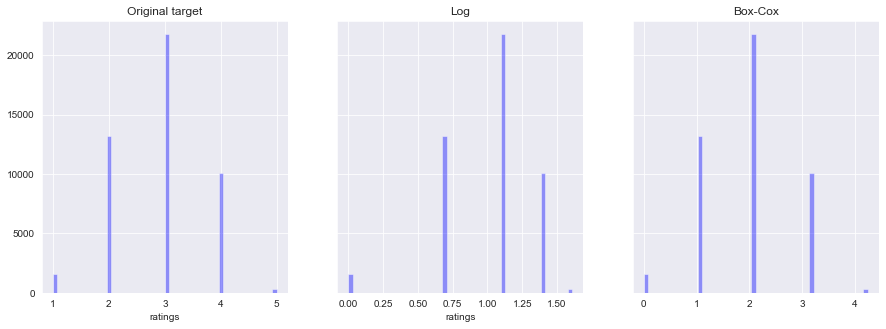

In [350]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Original target
print("p-value Shapiro test Original: ", shapiro(wine_ratings).pvalue)
sns.distplot(wine_ratings, kde=False, color= "b", ax=axes[0])
axes[0].set_title("Original target")
print("Asimetria:", skew(wine_ratings))

# Logaritmic
print("p-value Shapiro test Logaritmic: ", shapiro(np.log(wine_ratings),).pvalue)
sns.distplot(np.log(wine_ratings),kde=False, color= "b", ax=axes[1])
axes[1].set_title("Log")
print("Asimetria:", skew(np.log(wine_ratings)))

# Box-cox
print("p-value Shapiro test Box-cox: ", shapiro(stats.boxcox(wine_ratings)[0]).pvalue)
sns.distplot(stats.boxcox(wine_ratings)[0],kde=False,color= "b",  ax=axes[2])
axes[2].set_title("Box-Cox");
print("Asimetria:", skew(stats.boxcox(wine_ratings)[0]));

##### TRANSFORMACIONES SOBRE COLUMNA YEARS

In [351]:
wine_years = df_no_outliers["year"]

# Muy por debajo del nivel de significación (0.05) no se considera distribución normal.
print("Saphiro:", shapiro(wine_years).pvalue)

# Para comprobar la asimetría de una variable siempre podemos calcular su valor skew
# 0 si es simetrica, >0 cola hacia la derecha, <0 cola hacia la izquierda
print("Asimetria:", skew(wine_years))

Saphiro: 0.0
Asimetria: -1.4716884764433904


p-value Shapiro test Original:  0.0
Asimetria: -1.4716884764433904
p-value Shapiro test Logaritmic:  0.0
Asimetria: -1.4793710807840654


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\morestats.py:912: RuntimeWarning:

overflow encountered in power

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning:

overflow encountered in multiply

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:244: RuntimeWarning:

overflow encountered in reduce



p-value Shapiro test Box-cox:  1.0


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\stats.py:961: RuntimeWarning:

overflow encountered in multiply

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning:

invalid value encountered in reduce



Asimetria: nan


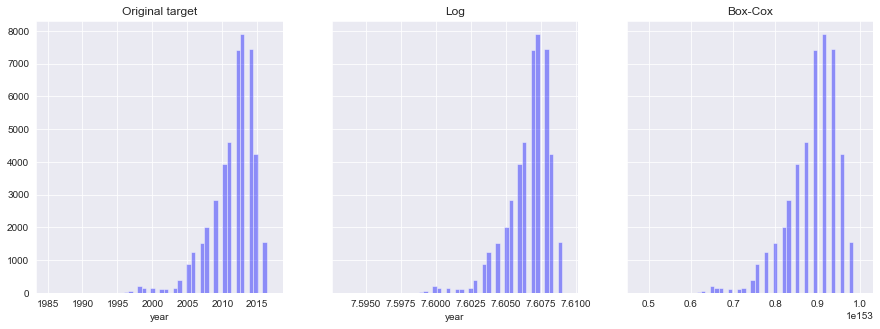

In [352]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Original target
print("p-value Shapiro test Original: ", shapiro(wine_years).pvalue)
sns.distplot(wine_years, kde=False, color= "b", ax=axes[0])
axes[0].set_title("Original target")
print("Asimetria:", skew(wine_years))

# Logaritmic
print("p-value Shapiro test Logaritmic: ", shapiro(np.log(wine_years),).pvalue)
sns.distplot(np.log(wine_years),kde=False, color= "b", ax=axes[1])
axes[1].set_title("Log")
print("Asimetria:", skew(np.log(wine_years)))

# Box-cox
print("p-value Shapiro test Box-cox: ", shapiro(stats.boxcox(wine_years)[0]).pvalue)
sns.distplot(stats.boxcox(wine_years)[0],kde=False,color= "b",  ax=axes[2])
axes[2].set_title("Box-Cox");
print("Asimetria:", skew(stats.boxcox(wine_years)[0]));

##### TRANSFORMACIONES SOBRE COLUMNA VARIETY

In [340]:
## las transformaciones me dan fallos porque hay valores = 0 (era lo que tenía asignado el Pinot Noir)
## voy a crear otra columna incrementado de 1 esos valores, a ver si me resuelve algo
df_no_outliers["variety_num"].sort_values()

## nota: ahora ya empieza por 1 porque ejecuté la celda mas abajo de la transformacion y luego he vuelto a ejecutar esta

26895      1
27491      1
27490      1
27489      1
27488      1
        ... 
37893    424
32989    425
38563    426
38604    427
46735    428
Name: variety_num, Length: 46982, dtype: int64

In [345]:
# df_no_outliers["variety_num"] = (df_no_outliers["variety_num"] + 1)
# df_no_outliers.sort_values(by= "variety_num")

### una vez hecho esta transformación voy a comentar la celda, porque si se vuelve a ejecutar me incrementará de 1 cada vez la columna


,country_num,variety_num,year,price,ratings
26895,0,1,2012,35.0,3
27491,1,1,1999,52.0,3
27490,1,1,1999,65.0,3
27489,1,1,1999,52.0,4
27488,1,1,1999,65.0,4
...,...,...,...,...,...
37893,3,424,2008,21.0,1
32989,4,425,2010,13.0,2
38563,0,426,2013,45.0,3
38604,2,427,2015,36.0,4


In [354]:
wine_variety = df_no_outliers["variety_num"]

# Muy por debajo del nivel de significación (0.05) no se considera distribución normal.
print("Saphiro:", shapiro(wine_variety).pvalue)

# Para comprobar la asimetría de una variable siempre podemos calcular su valor skew
# 0 si es simetrica, >0 cola hacia la derecha, <0 cola hacia la izquierda
print("Asimetria:", skew(wine_variety))

Saphiro: 0.0
Asimetria: 4.93718310217423


p-value Shapiro test Original:  0.0
Asimetria: 4.93718310217423
p-value Shapiro test Logaritmic:  0.0
Asimetria: 0.28812421447996434
p-value Shapiro test Box-cox:  0.0
Asimetria: 0.02644674661704777


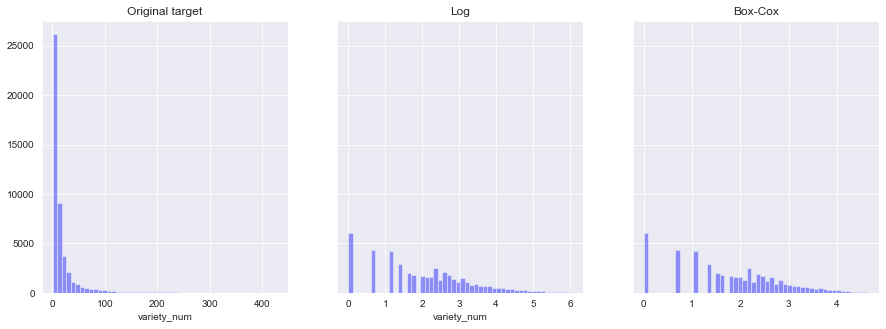

In [355]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Original target
print("p-value Shapiro test Original: ", shapiro(wine_variety).pvalue)
sns.distplot(wine_variety, kde=False, color= "b", ax=axes[0])
axes[0].set_title("Original target")
print("Asimetria:", skew(wine_variety))

# Logaritmic
print("p-value Shapiro test Logaritmic: ", shapiro(np.log(wine_variety),).pvalue)
sns.distplot(np.log(wine_variety),kde=False, color= "b", ax=axes[1])
axes[1].set_title("Log")
print("Asimetria:", skew(np.log(wine_variety)))

# Box-cox
print("p-value Shapiro test Box-cox: ", shapiro(stats.boxcox(wine_variety)[0]).pvalue)
sns.distplot(stats.boxcox(wine_variety)[0],kde=False,color= "b",  ax=axes[2])
axes[2].set_title("Box-Cox");
print("Asimetria:", skew(stats.boxcox(wine_variety)[0]));

#### Aplicaré transformación BOX COX al dataframe  "df_no_outliers "

In [ ]:
### vuelvo a guardar el dataframe con la columna "variety_num" actualizada (ya no hay 0, los números van de 1  a 428 )

#### voy a guardar este df como csv para que sea más cómodo luego cargarlo y usarlo para mis modelos de ML
## 
df_no_outliers.to_csv("..\\data\\processed\\df_no_outliers.csv", index=False)  ## todos los csv que cree los guardo en la carpeta "processed"


In [357]:
df_no_outliers

,country_num,variety_num,year,price,ratings
0,0,7,2013,13.0,2
1,0,1,2012,65.0,2
2,3,208,2011,15.0,2
3,2,143,2013,16.0,2
4,1,18,2012,27.0,2
...,...,...,...,...,...
46977,1,18,2010,57.0,3
46978,2,41,2012,40.0,3
46979,1,18,2013,28.0,3
46980,1,23,2013,30.0,3


In [359]:
### finalmente NO la voy a usar en mi proyecto, en el notebook 3 que es el enfoque definitivo
#### por lo tanto NO LA INCLUYO EN EL ARCHIVO clases.py


### aquí tengo una clase para aplicar transformaciones y también su inverso 
##### (fuente: https://ichi.pro/es/desequilibrio-de-datos-en-regresion-252653835692039)

class Transformer():
    '''
    This class can be used for applying transformations and inverse transformations to the target variable.
    Supported transformations:
        -> square root
        -> log
        -> box cox
    '''
    def __init__(self):
        self._lambda = 0 # init lambda -> required for box cox inverse transformation
    
    def apply_transformation(self, data_in, transform_key):
        '''
        This function applies the transformation according to transformer_key to the provided input.
        
        Args:
            data_in (np.array): Input data to transform
            transform_key (string): Key which transformation to apply (can be: square_root, log, boxcox, no_transformation)
        
        Returns: 
            data_transformed (np.array): The transformed data
        '''
        if transform_key == "no_transformation":
            data_transformed = data_in
        elif transform_key == "square_root":
            data_transformed = np.sqrt(data_in)
        elif transform_key == "log":
            data_transformed = np.log(data_in)
        elif transform_key == "boxcox":
            data_transformed, self._lambda = stats.boxcox(data_in)
        else:
            raise ValueError(f"{transform_key} is an invalid option!")
        
        return data_transformed
    
    def apply_inverse_transformation(self, data_in, transform_key):
        '''
        This function applies the inverse transformation according to transformer_key to the provided input.
        
        Args:
            data_in (np.array): Input data to transform
            transform_key (string): Key which transformation to apply (can be: square_root, log, boxcox, no_transformation)
        
        Returns: 
            data_transformed (np.array): The transformed data
        '''
        if transform_key == "no_transformation":
            data_transformed = data_in
        elif transform_key == "square_root":
            data_transformed = data_in**2
        elif transform_key == "log":
            data_transformed = np.exp(data_in)
        elif transform_key == "boxcox":
            data_transformed = special.inv_boxcox(data_in, self._lambda)
        else:
            raise ValueError(f"{transform_key} is an invalid option!")
        
        return data_transformed

In [360]:
#### ahora entreno el modelo que me dió mejor RMSE hasta ahora, le aplicaré estas transformaciones y verè cuál de ma mejores resultados
## este código lo encontré en la misma web de la celda anterior, pero ahora lo edito para adaptarlo a mi proyecto

##################
### recordar!!!!: el dataframe que estoy usando para los modelos es este:   df_no_outliers
################## tiene los valores numéricos (ya no hay palabras) y está sin outliers


# iterate over different transformations and train model plus get error
transformations_list = [
    "no_transformation",
    "square_root",
    "log",
    "boxcox"
]

X = df_no_outliers.drop(columns="price").to_numpy()    
y = df_no_outliers["price"].to_numpy()

# get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# use StandardScaler to scale training data and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


results_dict = {}
for transformation in transformations_list:
    
    transformer = Transformer()
    
    y_train_transformed = transformer.apply_transformation(y_train, transformation)    #### veo que solo se transforma la y, o sea el target, no el dataframe entero
    
    # creo el modelo y lo entreno
    grboost12b_so = GradientBoostingRegressor(max_depth=5,
                                 n_estimators=200,
                                 learning_rate=0.1,
                                 random_state=42)

    grboost12b_so.fit(X_train, y_train_transformed)
    
    # create predictions on test set
    preds = grboost12b_so.predict(X_test)
    
    # transform back
    preds = transformer.apply_inverse_transformation(preds, transformation)
    
    # get mse and r2
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    ### ya paso de calcular el MAPE (y en realidad lo que voy a mirar para ver si mi modelo es bueno o no, es solo el RMSE)
    
    # store in results dict
    results_dict[transformation] = [r2, mae, mse, rmse]

df_results = pd.DataFrame.from_dict(results_dict, orient="index", columns=["R2-Score", "MAE" ,"MSE", "RMSE"])


In [361]:
df_results

,R2-Score,MAE,MSE,RMSE
no_transformation,0.441584,13.507507,458.430036,21.410979
square_root,0.435012,13.146706,463.825649,21.536612
log,0.418625,12.991436,477.278612,21.846707
boxcox,0.405878,13.027119,487.742829,22.084900


In [ ]:

######## tengo que estar haciendo algo mal... pensaba que mejoraría algo con el escalado, pero EMPEORA (EMPEORA LA SEGUNDA PRUEBA DE GRADIENTBOOST, que era con este mismo 
# df pero sin escalar, pero mejora algo el anterior dataframe, él que tenia la columna "points" tal cual, y no la de "rating")

In [ ]:
#### voy a volver al dataframe con la columna points (él que usé para los primeros 13 modelos) y le aplico estas transformaciones.. a ver si mejora algo
### me quedaré con las columnas que me daban "mejores" resultados: "variety_num", "points", "year", "price"

In [363]:
df_limpio_num.head(3)

,points,year,price,variety_num,country_num,taster_name_Alexander Peartree,taster_name_Jim Gordon,taster_name_Joe Czerwinski,taster_name_Kerin O’Keefe,taster_name_Lauren Buzzeo,taster_name_Matt Kettmann,taster_name_Michael Schachner,taster_name_Paul Gregutt,taster_name_Roger Voss,taster_name_Sean P. Sullivan,taster_name_Susan Kostrzewa,taster_name_Virginie Boone
0,87,2013,13.0,6,0,1,0,0,0,0,0,0,0,0,0,0,0
1,87,2012,65.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,87,2011,15.0,207,3,0,0,0,0,0,0,1,0,0,0,0,0


In [365]:
df_limpio_num3 = df_limpio_num[["variety_num", "points", "year", "price"]]
df_limpio_num3.head(3)

,variety_num,points,year,price
0,6,87,2013,13.0
1,0,87,2012,65.0
2,207,87,2011,15.0


In [ ]:
## antes de volver a probar el modelo con las transformaciones, voy a quitar nuevamente los outliers y lo guardaré en un nuvo csv

In [366]:
### 1. primero quito los outliers de "price"


def outliers_quantie(df, feature, param=1.5):  
        
    iqr_ = iqr(df[feature], nan_policy='omit')
    q1 = np.nanpercentile(df[feature], 25)
    q3 = np.nanpercentile(df[feature], 75)
    
    th1 = q1 - iqr_*param
    th2 = q3 + iqr_*param
    
    return df[(df[feature] >= th1) & (df[feature] <= th2)].reset_index(drop=True)

df_no_out_price3 = outliers_quantie(df_limpio_num3, 'price', 7)
print("Len original:", len(df_limpio_num3))
print("Len sin outliers en price:", len(df_no_out_price3))

Len original: 47142
Len sin outliers en price: 46989


In [367]:
### 2. luego quito los outliers de "year"

##no vuelvo a copiar la funcion "outliers_quantie", la tengo justo aquí arriba (y luego seguramente para la presentación mueva todas las funciones a un archivo utils.py)

df_no_outliers3 = outliers_quantie(df_no_out_price3, 'year', 7)
print("Len original:", len(df_no_out_price3))
print("Len sin outliers en price:", len(df_no_outliers3))

Len original: 46989
Len sin outliers en price: 46982


In [368]:
### ya no vuelvo a sacar los gráficos, sé ya lo que me hace.
### las pruebas de ML que haga a partir de aquí (y hasta nuevos cambios) se harán sobre este df  >>>>>> df_no_outliers3 <<<<<<<<
df_no_outliers3

,variety_num,points,year,price
0,6,87,2013,13.0
1,0,87,2012,65.0
2,207,87,2011,15.0
3,142,87,2013,16.0
4,17,87,2012,27.0
...,...,...,...,...
46977,17,90,2010,57.0
46978,40,90,2012,40.0
46979,17,90,2013,28.0
46980,22,90,2013,30.0


In [369]:
### vuelvo a probar la transformacion
transformations_list = [
    "no_transformation",
    "square_root",
    "log",
    "boxcox"
]

X = df_no_outliers3.drop(columns="price").to_numpy()    #### ojo! ahora con df_no_outliers3 (vuelvo a mantener "points", y aque con el cambio a "ratings" no he visto mejoras)
y = df_no_outliers3["price"].to_numpy()

# get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# use StandardScaler to scale training data and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


results_dict = {}
for transformation in transformations_list:
    
    transformer = Transformer()
    
    y_train_transformed = transformer.apply_transformation(y_train, transformation)    
    
    # creo el modelo y lo entreno
    grboost12b_so = GradientBoostingRegressor(max_depth=5,
                                 n_estimators=200,
                                 learning_rate=0.1,
                                 random_state=42)

    grboost12b_so.fit(X_train, y_train_transformed)
    
    # create predictions on test set
    preds = grboost12b_so.predict(X_test)
    
    # transform back
    preds = transformer.apply_inverse_transformation(preds, transformation)
    
    # get mse and r2
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    ### ya paso de calcular el MAPE (y en realidad lo que voy a mirar para ver si mi modelo es bueno o no, es solo el RMSE)
    
    # store in results dict
    results_dict[transformation] = [r2, mae, mse, rmse]

df_results = pd.DataFrame.from_dict(results_dict, orient="index", columns=["R2-Score", "MAE" ,"MSE", "RMSE"])

In [370]:
df_results

## han mejorado algo las transformaciones pero sigue estando mejor el modelo sin transformar
## respecto al mejor modelo de ayer ha mejorado minimamente: antes tenía 21.4679 y ahora 21.4203

,R2-Score,MAE,MSE,RMSE
no_transformation,0.441094,13.687536,458.832894,21.420385
square_root,0.437104,13.292259,462.107849,21.496694
log,0.419008,13.122877,476.963646,21.839497
boxcox,0.409479,13.118379,484.786396,22.017865


In [ ]:

######## se me ocurre hacer otra prueba y cuando quito los outliers de precio, quitarlos manualmente, y asi quedarme solo con los precios hasta 90$ (ahora mantiene hasta 250$)
### NO, usaré otro enfoque y lo voy a meter en el siguiente notebook

### CONCLUSIONES FINALES DE ESTE NOTEBOOK (PARTE 1)

Llegado a este punto, veo que no consigo mejorar el score (0.44 el mejor) y el RMSE (21.42 el mejor) así que voy a tener que cambiar el enfoque.
Probaré 2 vías:
1. Seguir con REGRESIÓN pero acotar el dataframe quedándome sólo con los vinos de menos de 50$ 
            
            (basándome en mi story telling... 
            Ahora con la pandemia la gente más que quedar en bares queda en las casas y lleva la clásica botella de vino. 
            Quiero crear un recomendador que, introduciendo la puntuación de un vino, el año de producción y la variedad, 
            me prediga el precio, para yo saber sobre qué rango moverme si voy a casa de un amigo y le quiero regalar algun vino bueno. 
            Y por supuesto, por mucho que quiera a este amigo, sé que nunca me gastaría más de 50$ para ello. 
            O mismamente si la quiero usar para recomendar a gente ciertos vinos y decirle sobre qué precio se podría mover la cosa, 
            sé que en general un tope de 50$ sería más que suficiente por el entorno en el que me muevo)
            

2. Cambiar a CLASIFICACIÓN, tener como variable target la variedad del vino y predecirla gracias a las variables country, designation y winery

            (Aquí también puedo basarme en mi story telling para justificar esta elección.
            Siempre fiel al hilo de querer crear un recomendador de vinos, esta vez quiero predecir la variedad del vino, 
            igual para recomendar a amigos, y por supuesto no quiero recomendar vinos que sean super raros y difíciles de encontrar. 
            Por lo tanto acotaré primero por el "variety", quedándome SOLO con aquellas variedades de las que hay más de 100.
            Depues, analizaré el nuevo dataframe que se ha quedado y veré si allí quedan "designation" o "winery" también poco frecuentes, 
            y si se diera el caso, cortaría también de allí)

            Finalmente, con estos datos relimpiados y recortados, escogería los 3 mejores modelos de los que ya tenía de antes (de regresión), 
            y los pasaría a clasificación